In [1]:
import torch
from torch import nn
from torch import optim
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from nltk.classify.megam import numpy
from scipy import interp
from itertools import cycle
import time

In [2]:
import numpy as np
import os
import math
import random
import torch
# from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy import stats
import plotly.graph_objects as go

from sklearn.utils import shuffle
import torch.nn as nn
!pip install torchsummary
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

You should consider upgrading via the '/Users/pro/Documents/Sklearn/venv/bin/python -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

USE_CUDA = True

In [4]:
from sklearn.model_selection import KFold

# 1.数据集处理

In [9]:
dataset = pd.read_csv('../capsule_code/data_new.csv')
dataset


,Unnamed: 0,0,1,2,label
0,0,-0.307202,0.315577,-0.361374,11
1,1,-0.307202,0.315577,-0.361374,11
2,2,-0.307202,0.315577,-0.361374,11
3,3,-0.307202,0.315577,-0.361374,11
4,4,-0.307202,0.315577,-0.361374,11
...,...,...,...,...,...
13995,13995,-0.349396,-0.063816,-0.399994,0
13996,13996,-0.349396,-0.065149,-0.399994,0
13997,13997,-0.349396,-0.064816,-0.399994,0
13998,13998,-0.349396,-0.063149,-0.399994,0


In [31]:
all_data = shuffle(dataset)
data = all_data[['0','1','2']]
label = all_data['label']
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [61]:
X_train, X_test, X_valid = np.array(X_train).reshape(-1, 3), np.array(X_test).reshape(-1, 3), np.array(X_valid).reshape(-1, 3)
y_train, y_test, y_valid = np.array(y_train).reshape(-1, 1), np.array(y_test).reshape(-1, 1), np.array(y_valid).reshape(-1, 1)

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, X_valid, X_test = torch.FloatTensor(X_train), torch.FloatTensor(X_valid), torch.FloatTensor(X_test)
y_train, y_valid, y_test = torch.FloatTensor(y_train), torch.FloatTensor(y_valid), torch.FloatTensor(y_test)

In [63]:
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
  # 'Characterizes a dataset for PyTorch'
    def __init__(self, data, labels):
        # 'Initialization'
        self.labels = labels
        self.data = data

    def __len__(self):
        # 'Denotes the total number of samples'
        return len(self.data)

    def __getitem__(self, index):
        # 'Generates one sample of data'
        # Select sample
        return self.data[index], self.labels[index]

In [64]:
config = {
    'batch_size': 100,
    'shuffle': True,
    'drop_last': False
}

In [65]:
train_set = Dataset(X_train, y_train)
train_loader = DataLoader(
    train_set,
    batch_size=config['batch_size'],
    shuffle=config['shuffle'],
#     num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

validation_set = Dataset(X_valid, y_valid)
validation_loader = DataLoader(
    validation_set,
    batch_size=config['batch_size'],
    shuffle=config['shuffle'],
#     num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

test_set = Dataset(X_test, y_test)
test_loader = DataLoader(
    test_set,
    batch_size=config['batch_size'],
    shuffle=config['shuffle'],
#     num_workers=config['num_workers'],
    drop_last=config['drop_last']
)

# 2.胶囊网络

In [66]:
def squash(x, dim=-1):
    squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1 + squared_norm)
    return scale * x / (squared_norm.sqrt() + 1e-8)

In [67]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.1 特征提取层 

In [68]:
class ConvLayer(nn.Module):
    
    def __init__(self, in_channels=3, out_channels=32):
        '''Constructs the ConvLayer with a specified input and output size.
           param in_channels: input depth of an image, default value = 1
           param out_channels: output depth of the convolutional layer, default value = 256
           '''
        super(ConvLayer, self).__init__()

        # defining a convolutional layer of the specified size
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=64, 
                              kernel_size=1, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, 
                              kernel_size=1, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, 
                              kernel_size=1, stride=1, padding=1)
        self.conv4 = nn.Conv1d(in_channels=256, out_channels=512, 
                              kernel_size=1, stride=1, padding=1)
#         self.conv5 = nn.Conv1d(in_channels=512, out_channels=1024, 
#                               kernel_size=3, stride=1, padding=2)
#         self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        '''Defines the feedforward behavior.
           param x: the input to the layer; an input image
           return: a relu-activated, convolutional layer
           '''
        # 将 ReLu 激活应用于 conv 层的输出
        features = self.conv1(x)
#         print(features.shape)
        features = self.conv2(features)
        features = self.conv3(features)
        features = self.conv4(features)
#         features = self.conv5(features)
        features = F.relu(features) # will have dimensions (batch_size, 20, 20, 256)
        return features

In [69]:
cnn = ConvLayer()
for batch_i, (batch_data, batch_labels) in enumerate(train_loader):
    batch_data = batch_data.unsqueeze(0)
    batch_data = batch_data.permute(1,2,0)
    output = cnn(batch_data)

In [70]:
output.shape

torch.Size([100, 512, 9])

## 2.2 子胶囊层

In [71]:
class PrimaryCaps(nn.Module):
    """Primary capsule layer."""

    def __init__(self, num_conv_units, in_channels, out_channels, kernel_size, stride, padding):
        super(PrimaryCaps, self).__init__()

        # Each conv unit stands for a single capsule.
        self.conv = nn.Conv1d(in_channels=in_channels,
                              out_channels=out_channels * num_conv_units,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding = padding
                             )
        self.out_channels = out_channels

    def forward(self, x):
        # Shape of x: (batch_size, in_channels, height, weight)
        # Shape of out: out_capsules * (batch_size, out_channels, height, weight)
        out = self.conv(x)
        # Flatten out: (batch_size, out_capsules * height * weight, out_channels)
        batch_size = out.shape[0]
        return squash(out.contiguous().view(batch_size, -1, self.out_channels), dim=-1)

In [72]:
cnn = ConvLayer()
primaryCaps = PrimaryCaps(num_conv_units=16,
                                        in_channels=512,
                                        out_channels=4,
                                        kernel_size=2,
                                        stride=1,
                                        padding = 1
                         )

for batch_i, (batch_data, batch_labels) in enumerate(train_loader):
    batch_data = batch_data.unsqueeze(0)
    batch_data = batch_data.permute(1,2,0)
    output = cnn(batch_data)
    primaryCaps_output = primaryCaps(output)

In [73]:
output.shape

torch.Size([100, 512, 9])

In [74]:
primaryCaps_output.shape, primaryCaps_output

(torch.Size([100, 160, 4]),
 tensor([[[ 6.2874e-04,  6.7787e-04,  4.2898e-04,  6.1399e-04],
          [ 2.3697e-03,  2.2733e-03,  2.0581e-03,  7.5540e-04],
          [ 7.3038e-04,  7.4757e-04, -1.5665e-04, -5.2133e-04],
          ...,
          [-2.4770e-03, -1.7483e-03, -1.2744e-03, -2.1872e-03],
          [-1.8240e-03, -2.2547e-03, -6.7000e-05, -1.5654e-03],
          [ 1.0488e-05, -1.7158e-03, -1.3268e-03, -1.6707e-03]],
 
         [[ 6.2874e-04,  6.7787e-04,  4.2898e-04,  6.1399e-04],
          [ 2.4765e-03,  2.5828e-03,  2.1320e-03,  7.8251e-04],
          [ 7.3038e-04,  7.4757e-04, -1.5665e-04, -5.2133e-04],
          ...,
          [-2.4770e-03, -1.7483e-03, -1.2744e-03, -2.1872e-03],
          [-1.8096e-03, -2.2368e-03,  7.2971e-04, -1.3090e-03],
          [ 1.0488e-05, -1.7158e-03, -1.3268e-03, -1.6707e-03]],
 
         [[ 6.2874e-04,  6.7787e-04,  4.2898e-04,  6.1399e-04],
          [ 2.3826e-03,  2.1411e-03,  2.0375e-03,  7.4782e-04],
          [ 7.3038e-04,  7.4757e-04, -1.

## 2.3 父胶囊层

In [75]:
class DigitCaps(nn.Module):
    """Digit capsule layer."""

    def __init__(self, in_dim, in_caps, out_caps, out_dim, num_routing):
        """
        Initialize the layer.
        Args:
            in_dim: 		Dimensionality of each capsule vector.
            in_caps: 		Number of input capsules if digits layer.
            out_caps: 		Number of capsules in the capsule layer
            out_dim: 		Dimensionality, of the output capsule vector.
            num_routing:	Number of iterations during routing algorithm
        """
        super(DigitCaps, self).__init__()
        self.in_dim = in_dim
        self.in_caps = in_caps
        self.out_caps = out_caps
        self.out_dim = out_dim
        self.num_routing = num_routing
#         self.device = device
        self.W = nn.Parameter(0.01 * torch.randn(1, out_caps, in_caps, out_dim, in_dim),
                              requires_grad=True)

    def forward(self, x):
        batch_size = x.size(0)
        # (batch_size, in_caps, in_dim) -> (batch_size, 1, in_caps, in_dim, 1)
        x = x.unsqueeze(1).unsqueeze(4)
        # W @ x =
        # (1, out_caps, in_caps, out_dim, in_dim) @ (batch_size, 1, in_caps, in_dim, 1) =
        # (batch_size, out_caps, in_caps, out_dims, 1)
        u_hat = torch.matmul(self.W, x)
        # (batch_size, out_caps, in_caps, out_dim)
        u_hat = u_hat.squeeze(-1)
        # detach u_hat during routing iterations to prevent gradients from flowing
        temp_u_hat = u_hat.detach()

        b = torch.zeros(batch_size, self.out_caps, self.in_caps, 1)

        for route_iter in range(self.num_routing - 1):
            # (batch_size, out_caps, in_caps, 1) -> Softmax along out_caps
            c = b.softmax(dim=1)

            # element-wise multiplication
            # (batch_size, out_caps, in_caps, 1) * (batch_size, in_caps, out_caps, out_dim) ->
            # (batch_size, out_caps, in_caps, out_dim) sum across in_caps ->
            # (batch_size, out_caps, out_dim)
            s = (c * temp_u_hat).sum(dim=2)
            # apply "squashing" non-linearity along out_dim
            v = squash(s)
            # dot product agreement between the current output vj and the prediction uj|i
            # (batch_size, out_caps, in_caps, out_dim) @ (batch_size, out_caps, out_dim, 1)
            # -> (batch_size, out_caps, in_caps, 1)
            uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
            b += uv

        # last iteration is done on the original u_hat, without the routing weights update
        c = b.softmax(dim=1)
        s = (c * u_hat).sum(dim=2)
        # apply "squashing" non-linearity along out_dim
        v = squash(s)

        return v


In [76]:
cnn = ConvLayer()
primaryCaps = PrimaryCaps(num_conv_units=16,
                                        in_channels=512,
                                        out_channels=4,
                                        kernel_size=2,
                                        stride=1,
                                        padding = 1
                         )

digit_caps = DigitCaps(in_dim=4,
                                    in_caps=160,
                                    out_caps=16,
                                    out_dim=8,
                                    num_routing=3)

for batch_i, (batch_data, batch_labels) in enumerate(train_loader):
    batch_data = batch_data.unsqueeze(0)
    batch_data = batch_data.permute(1,2,0)
    output = cnn(batch_data)
    primaryCaps_output = primaryCaps(output)
    digit_output = digit_caps(primaryCaps_output)

In [77]:
digit_output.shape, digit_output

(torch.Size([100, 16, 8]),
 tensor([[[ 8.3364e-09,  1.6207e-09,  8.3661e-09,  ..., -3.5687e-09,
           -1.1721e-10,  5.8457e-10],
          [-2.6624e-09, -5.8274e-09, -3.5469e-09,  ...,  1.4217e-09,
           -3.2849e-09,  2.5591e-09],
          [-2.2391e-09,  1.3627e-08,  4.9008e-09,  ...,  6.6708e-09,
           -4.8235e-10,  3.1595e-09],
          ...,
          [-6.6515e-09,  9.3551e-10, -9.6401e-09,  ...,  2.5348e-09,
           -4.0504e-09, -2.6202e-09],
          [-4.7444e-09, -5.3615e-11, -1.4228e-08,  ...,  2.3678e-11,
            1.1753e-09,  8.0438e-09],
          [-2.2155e-09,  1.0475e-08,  7.1526e-10,  ...,  4.1254e-09,
           -5.5451e-10, -9.9803e-09]],
 
         [[ 6.7020e-09, -2.7754e-09,  7.9757e-09,  ..., -8.6658e-10,
            3.7749e-09,  7.3400e-09],
          [-6.9319e-09, -7.2677e-09, -4.5398e-09,  ...,  3.5868e-09,
           -3.8262e-09,  4.2104e-09],
          [ 1.2957e-08,  2.0062e-08,  2.7699e-08,  ...,  1.8907e-08,
            1.1637e-08,  4.237

## 2.4 胶囊网络层

In [78]:
class CapsNet(nn.Module):
    """Basic implementation of capsule network layer."""

    def __init__(self):
        super(CapsNet, self).__init__()

        # Conv1d layer
        # 提取特征层
        self.conv = ConvLayer()

        # Primary capsule
        # 子胶囊层
        self.primary_caps = PrimaryCaps(num_conv_units=16,
                                        in_channels=512,
                                        out_channels=4,
                                        kernel_size=2,
                                        stride=1,
                                        padding = 1)

        # Digit capsule
        # 父胶囊层
        self.digit_caps = DigitCaps(in_dim=4,
                                    in_caps=160,
                                    out_caps=16,
                                    out_dim=8,
                                    num_routing=3)

        # Reconstruction layer
        # 重构层
        self.decoder = nn.Sequential(
            nn.Linear(16*8, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 3),
            nn.Sigmoid())

    def forward(self, x):
        out = self.conv(x)
        out = self.primary_caps(out)
        out = self.digit_caps(out)

        # Shape of logits: (batch_size, out_capsules)
        logits = torch.norm(out, dim=-1)
        pred = torch.eye(16).index_select(dim=0, index=torch.argmax(logits, dim=1))

        # Reconstruction
        batch_size = out.shape[0]
        reconstruction = self.decoder((out * pred.unsqueeze(2)).contiguous().view(batch_size, -1))

        return logits, reconstruction


In [79]:
cnn = CapsNet()
for batch_i, (batch_data, batch_labels) in enumerate(train_loader):
    batch_data = batch_data.unsqueeze(0)
    batch_data = batch_data.permute(1,2,0)
    logits, reconstruction = cnn(batch_data)

In [80]:
logits.shape,logits,reconstruction.shape, reconstruction

(torch.Size([100, 16]),
 tensor([[8.6130e-09, 1.2976e-08, 1.3550e-08,  ..., 4.4446e-09, 5.9113e-09,
          1.0212e-08],
         [8.7160e-09, 1.3276e-08, 1.3831e-08,  ..., 4.5183e-09, 5.9227e-09,
          1.0520e-08],
         [8.2687e-09, 1.2935e-08, 1.2516e-08,  ..., 4.8776e-09, 6.5605e-09,
          9.9792e-09],
         ...,
         [8.1543e-09, 1.3266e-08, 1.1621e-08,  ..., 6.1537e-09, 7.6983e-09,
          9.4058e-09],
         [8.1122e-09, 1.2768e-08, 1.1790e-08,  ..., 5.8154e-09, 6.9762e-09,
          9.4171e-09],
         [8.1382e-09, 1.3000e-08, 1.1722e-08,  ..., 5.9544e-09, 7.3057e-09,
          9.4001e-09]], grad_fn=<CopyBackwards>),
 torch.Size([100, 3]),
 tensor([[0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
         [0.5041, 0.5002, 0.5119],
   

## 2.5 损失函数

In [81]:
class CapsuleLoss(nn.Module):
    """Combine margin loss & reconstruction loss of capsule network."""

    def __init__(self, upper_bound=0.9, lower_bound=0.1, lmda=0.5):
        super(CapsuleLoss, self).__init__()
        self.upper = upper_bound
        self.lower = lower_bound
        self.lmda = lmda
        self.reconstruction_loss_scalar = 5e-4
        self.mse = nn.MSELoss(reduction='sum')

    def forward(self, images, labels, logits, reconstructions):
        # Shape of left / right / labels: (batch_size, num_classes)
        left = (self.upper - logits).relu() ** 2  # True negative
        right = (logits - self.lower).relu() ** 2  # False positive
        margin_loss = torch.sum(labels * left) + self.lmda * torch.sum((1 - labels) * right)

        # Reconstruction loss
        reconstruction_loss = self.mse(reconstructions.contiguous().view(images.shape), images)

        # Combine two losses
        return margin_loss + self.reconstruction_loss_scalar * reconstruction_loss

# 3.训练异常检测模型

## 3.1 优化器、损失函数

In [82]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
capsule_net = CapsNet()
criterion = CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)

## 3.2 训练、验证模型

In [83]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
def One_hot(labels):
    num_class=16
    lb=LabelBinarizer().fit(np.array(range(num_class)))
    labels=lb.transform(labels)
    return labels


In [84]:
def precision_recall_curve(y, y_pred):
    y_pred_class,precision,recall = [],[],[]
    thresholds = [0.1, 0.2, 0.3, 0.6, 0.65]
    for thresh in thresholds:
        for i in y_pred:     #y_pred holds prob value for class 1
            if i>=thresh: y_pred_class.append(1)
            else: y_pred_class.append(0)
        precision.append(calculate_precision(y, y_pred_class))
        recall.append(calculate_recall(y, y_pred_class))
    return recall, precisionplt.plot(recall, precision)

In [85]:
def train(capsule_net, criterion, optimizer, 
          n_epochs, print_every=len(train_loader)):
    '''Trains a capsule network and prints out training batch loss statistics.
       Saves model parameters if *validation* loss has decreased.
       param capsule_net: trained capsule network
       param criterion: capsule loss function
       param optimizer: optimizer for updating network weights
       param n_epochs: number of epochs to train for
       param print_every: batches to print and save training loss, default = 100
       return: list of recorded training losses
       '''

    # track training loss over time
    train_losses = []
    valid_losses = []
    trainAcc1, trainAcc2, trainAcc3, trainAcc4, trainAcc5 = [], [], [], [], []
    valAcc1, valAcc2, valAcc3, valAcc4, valAcc5 = [], [], [], [], []
    trainPre, trainRecall, trainf1 = [],[],[]
    valPre, valRecall, valf1 = [],[],[]
    # one epoch = one pass over all training data 
    for epoch in range(1, n_epochs+1):
        print("-------第 {} 轮训练开始-------".format(epoch))
        '''
        使用训练集训练
        '''
        # initialize training loss
        train_loss = 0.0
        train_acc = 0.0
        train_accs = []
        capsule_net.train() # set to train mode
        train_preds = []
        train_trues = []
        correct_5 = 0.0
        correct_4 = 0.0
        correct_2 = 0.0
        correct_3 = 0.0
        correct_1 = 0.0
        count = 0
        train_acc_1, train_acc_2, train_acc_3, train_acc_4, train_acc_5 = 0.0, 0.0 ,0.0, 0.0, 0.0
        # get batches of training image data and targets
        for batch_i, (batch_data, batch_labels) in enumerate(train_loader):
            
#             print("batch_labels:", batch_labels)
            batch_data = batch_data.unsqueeze(0)
            batch_data = batch_data.permute(1,2,0)
            batch_labels = batch_labels.squeeze()
            
            batch_labels = One_hot(batch_labels)
            # 转tensor，batch_labels: torch.Size([32, 16])
            batch_labels = torch.from_numpy(batch_labels) 
            
            # zero out gradients
            optimizer.zero_grad()
            # get model outputs
            # logits为输出的各标签概率值
            logits, reconstruction = capsule_net(batch_data)

            # calculate loss
            loss = criterion(batch_data, batch_labels, logits, reconstruction)
            # perform backpropagation and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item() # accumulated training loss
            
            # 根据概率值对标签进行排序
            # 计算topk准确率，k=1-5
            _, pred = logits.topk(5, 1, largest=True, sorted=True)
            _, labels = torch.max(batch_labels.data.cpu(), 1)
            labels = labels.view(labels.size(0), -1).expand_as(pred)
            count += labels.shape[0]
            correct = pred.eq(labels).float()
#             print("correct:", correct)
            correct_5 += correct[:, :5].sum()
#             print("correct_5:", correct_5)
            correct_4 += correct[:, :4].sum()
#             print("correct_4:", correct_4)
            correct_3 += correct[:, :3].sum()
#             print("correct_3:", correct_3)
            correct_2 += correct[:, :2].sum()
#             print("correct_2:", correct_2)
            correct_1 += correct[:, :1].sum()
#             print("correct_1:", correct_1)
            
            _, train_outputs = torch.max(logits.data.cpu(), 1)
#             print("train_outputs:", train_outputs)
            _, batch_labels = torch.max(batch_labels.data.cpu(), 1)
#             print("batch_labels:", batch_labels)
            train_trues.append(batch_labels.cpu().detach().numpy())
            train_preds.append(train_outputs.cpu().detach().numpy())
        
            accuracy =(train_outputs.data.numpy() == batch_labels.data.numpy()).astype(int).sum()/float(batch_labels.numpy().size)
#             print("accuracy:", accuracy)
            train_accs.append(accuracy)

        train_acc1 = correct_1/count
        train_acc2 = correct_2/count
        train_acc3 = correct_3/count
        train_acc4 = correct_4/count
        train_acc5 = correct_5/count
        
        trainAcc1.append(train_acc1)
        trainAcc2.append(train_acc2)
        trainAcc3.append(train_acc3)
        trainAcc4.append(train_acc4)
        trainAcc5.append(train_acc5)
        
        y_true = np.concatenate(train_trues)
        y_pred = np.concatenate(train_preds)
        
#         ans = classification_report(y_true, y_pred,digits=5) # 小数点后保留5位有效数字
#         print("训练集各标签分类情况：", ans)
        
        precision, recall, f1 = precision_recall_fscore_support(y_true,y_pred,average='macro')[:-1]
        
        trainPre.append(precision)
        trainRecall.append(recall)
        trainf1.append(f1)
        
        # train_outputs和batch_labels输出值是什么
        # 加一个AUC
        # 查一下accuracy_score这几个。
        # 设置模式，是2分类还是多分类
        # 图像显示
        
        '''
        使用验证集验证
        '''
        capsule_net.eval()
        val_loss = 0.0
        val_accs = []
        val_acc = 0.0
        val_trues, val_preds = [],[]
        val_correct = 0.0
        val_correct5 = 0.0
        val_correct4 = 0.0
        val_correct2 = 0.0
        val_correct3 = 0.0
        val_correct1 = 0.0
        
        val_count = 0
        val_acc1, val_acc2, val_acc3, val_acc4, val_acc5 = 0.0, 0.0 ,0.0, 0.0, 0.0
        
        for val_i, (val_data, val_labels) in enumerate(validation_loader):
            
            val_data = val_data.unsqueeze(0)
            val_data = val_data.permute(1,2,0)
            val_labels = val_labels.squeeze()
            val_labels = One_hot(val_labels)
            # 转tensor，batch_labels: torch.Size([32, 16])
            val_labels = torch.from_numpy(val_labels) 
            # get model outputs
            logits, reconstruction = capsule_net(val_data)
            
            # 计算topk准确率，k=1-5
            _, pred = logits.topk(5, 1, largest=True, sorted=True)
            _, labels = torch.max(val_labels.data.cpu(), 1)
            labels = labels.view(labels.size(0), -1).expand_as(pred)
            
            val_count += labels.shape[0]
            
            val_correct = pred.eq(labels).float()
            val_correct5 += val_correct[:, :5].sum()
            val_correct4 += val_correct[:, :4].sum()
            val_correct3 += val_correct[:, :3].sum()
            val_correct2 += val_correct[:, :2].sum()
            val_correct1 += val_correct[:, :1].sum()
            
            _, val_output = torch.max(logits.data.cpu(), 1)
#             print("train_outputs:", train_outputs)
            _, val_label = torch.max(val_labels.data.cpu(), 1)
#             print("batch_labels:", batch_labels)
            val_trues.append(val_label.cpu().detach().numpy())
            val_preds.append(val_output.cpu().detach().numpy())
            
            # calculate loss
            val_losses = criterion(val_data, val_labels , logits, reconstruction)

            val_loss += val_losses.item() # accumulated training loss
            

        val_acc1 = val_correct1/val_count
        val_acc2 = val_correct2/val_count
        val_acc3 = val_correct3/val_count
        val_acc4 = val_correct4/val_count
        val_acc5 = val_correct5/val_count
        
        valAcc1.append(val_acc1)
        valAcc2.append(val_acc2)
        valAcc3.append(val_acc3)
        valAcc4.append(val_acc4)
        valAcc5.append(val_acc5)
        
        y_val_true = np.concatenate(val_trues)
        y_val_pred = np.concatenate(val_preds)
        
#         val_ans = classification_report(y_val_true, y_val_pred,digits=5) # 小数点后保留5位有效数字
#         print("验证集各标签分类情况：", val_ans)
        
        val_precision, val_recall, val_f1 = precision_recall_fscore_support(y_val_true,y_val_pred,average='macro')[:-1]
#         val_AUC = roc_auc_score(y_val_true, y_val_preds, multi_class='ovo')
        
        valPre.append(val_precision)
        valRecall.append(val_recall)
        valf1.append(val_f1)
    
        train_loss = train_loss/len(train_loader)
        train_loss = train_loss/100.0
        train_losses.append(train_loss)
        val_loss = val_loss/ len(validation_loader)
        val_loss = val_loss/100.0
        valid_losses.append(val_loss)
        print('train Loss: {:.4f} \t valid Loss: {:.4f}'.format(train_loss, val_loss))
        print('train acc1: {:.4f} \t valid acc1: {:.4f}'.format(train_acc1, val_acc1))
        print('train acc2: {:.4f} \t valid acc2: {:.4f}'.format(train_acc2, val_acc2))
        print('train acc3: {:.4f} \t valid acc3: {:.4f}'.format(train_acc3, val_acc3))
        print('train acc4: {:.4f} \t valid acc4: {:.4f}'.format(train_acc4, val_acc4))
        print('train acc5: {:.4f} \t valid acc5: {:.4f}'.format(train_acc5, val_acc5))
        print('train precision: {:.4f} \t valid precision: {:.4f}'.format(precision, val_precision))
        print('train recall: {:.4f} \t valid recall: {:.4f}'.format(recall, val_recall))
        print('train f1-score: {:.4f} \t valid f1-score: {:.4f}'.format(f1, val_f1))
    
    # 画出训练损失和验证损失曲线
    x= range(n_epochs)
    plt.plot(x, train_losses, color='coral', label='Training loss')
    plt.plot(x, valid_losses, color='#054E9F', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # 画出训练集topk准确率
    plt.plot(x, trainAcc1, color='coral', label='Training acc1')
    plt.plot(x, trainAcc2, color='#054E9F', label='Training acc2')
    plt.plot(x, trainAcc3, color='#CD853F', label='Training acc3')
    plt.plot(x, trainAcc4, color='#FFC0CB', label='Training acc4')
    plt.plot(x, trainAcc5, color='#4169E1', label='Training acc5')
    plt.title('Training top5 acc')
    plt.xlabel('Epoch')
    plt.ylabel('top5 acc')
    plt.legend()
    plt.show()
    
    # 画出验证集topk准确率
    plt.plot(x, valAcc1, color='coral', label='validation acc1')
    plt.plot(x, valAcc2, color='#054E9F', label='validation acc2')
    plt.plot(x, valAcc3, color='#CD853F', label='validation acc3')
    plt.plot(x, valAcc4, color='#FFC0CB', label='validation acc4')
    plt.plot(x, valAcc5, color='#4169E1', label='validation acc5')
    plt.title('validation top5 acc')
    plt.xlabel('Epoch')
    plt.ylabel('top5 acc')
    plt.legend()
    plt.show()
    
    # 画出训练集和验证集的precision\recall\f1-score
    plt.plot(x, trainPre, color='coral', label='Training precision')
    plt.plot(x, valPre, color='#054E9F', label='Validation precision')
    plt.title('Training and validation precision')
    plt.xlabel('Epoch')
    plt.ylabel('precision')
    plt.legend()
    plt.show()
    
    # 画出训练集和验证集的precision\recall\f1-score
    plt.plot(x, trainRecall, color='coral', label='Training Recall')
    plt.plot(x, valRecall, color='#054E9F', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()
    plt.show()
    
    # 画出训练集和验证集的precision\recall\f1-score
    plt.plot(x, trainf1, color='coral', label='Training f1-score')
    plt.plot(x, valRecall, color='#054E9F', label='Validation f1-score')
    plt.title('Training and validation f1-score')
    plt.xlabel('Epoch')
    plt.ylabel('f1-score')
    plt.legend()
    plt.show()
    
#         print('train AUC: {:.4f} \t valid AUC: {:.4f}'.format(AUC, val_AUC))

### 去除时间

1636794809.637759
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.4486 	 valid Loss: 0.3239
train acc1: 0.4402 	 valid acc1: 0.5821
train acc2: 0.5269 	 valid acc2: 0.7282
train acc3: 0.5865 	 valid acc3: 0.8093
train acc4: 0.6438 	 valid acc4: 0.8482
train acc5: 0.7001 	 valid acc5: 0.8954
train precision: 0.2349 	 valid precision: 0.2999
train recall: 0.1284 	 valid recall: 0.2644
train f1-score: 0.1212 	 valid f1-score: 0.1916
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.3013 	 valid Loss: 0.2916
train acc1: 0.6348 	 valid acc1: 0.6568
train acc2: 0.7467 	 valid acc2: 0.7421
train acc3: 0.8275 	 valid acc3: 0.8350
train acc4: 0.8745 	 valid acc4: 0.8868
train acc5: 0.9108 	 valid acc5: 0.9146
train precision: 0.3569 	 valid precision: 0.4198
train recall: 0.3518 	 valid recall: 0.4243
train f1-score: 0.3340 	 valid f1-score: 0.4031
-------第 3 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2733 	 valid Loss: 0.2635
train acc1: 0.6764 	 valid acc1: 0.6718
train acc2: 0.7804 	 valid acc2: 0.7879
train acc3: 0.8594 	 valid acc3: 0.8632
train acc4: 0.9005 	 valid acc4: 0.9246
train acc5: 0.9350 	 valid acc5: 0.9546
train precision: 0.4357 	 valid precision: 0.4385
train recall: 0.4460 	 valid recall: 0.4554
train f1-score: 0.4332 	 valid f1-score: 0.4382
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2472 	 valid Loss: 0.2385
train acc1: 0.6823 	 valid acc1: 0.6764
train acc2: 0.8145 	 valid acc2: 0.8382
train acc3: 0.8923 	 valid acc3: 0.8993
train acc4: 0.9304 	 valid acc4: 0.9286
train acc5: 0.9560 	 valid acc5: 0.9543
train precision: 0.4446 	 valid precision: 0.4427
train recall: 0.4589 	 valid recall: 0.4660
train f1-score: 0.4463 	 valid f1-score: 0.4479
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2255 	 valid Loss: 0.2300
train acc1: 0.7126 	 valid acc1: 0.6932
train acc2: 0.8393 	 valid acc2: 0.8382
train acc3: 0.9044 	 valid acc3: 0.9093
train acc4: 0.9369 	 valid acc4: 0.9504
train acc5: 0.9620 	 valid acc5: 0.9671
train precision: 0.5441 	 valid precision: 0.5725
train recall: 0.5212 	 valid recall: 0.4982
train f1-score: 0.5129 	 valid f1-score: 0.4868
-------第 6 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2150 	 valid Loss: 0.2181
train acc1: 0.7206 	 valid acc1: 0.7136
train acc2: 0.8457 	 valid acc2: 0.8429
train acc3: 0.9100 	 valid acc3: 0.9164
train acc4: 0.9464 	 valid acc4: 0.9543
train acc5: 0.9724 	 valid acc5: 0.9775
train precision: 0.6137 	 valid precision: 0.6109
train recall: 0.5384 	 valid recall: 0.5583
train f1-score: 0.5302 	 valid f1-score: 0.5432
-------第 7 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2086 	 valid Loss: 0.2190
train acc1: 0.7254 	 valid acc1: 0.7136
train acc2: 0.8552 	 valid acc2: 0.8421
train acc3: 0.9176 	 valid acc3: 0.9175
train acc4: 0.9521 	 valid acc4: 0.9586
train acc5: 0.9773 	 valid acc5: 0.9821
train precision: 0.6045 	 valid precision: 0.5714
train recall: 0.5518 	 valid recall: 0.5501
train f1-score: 0.5470 	 valid f1-score: 0.5397
-------第 8 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2065 	 valid Loss: 0.2032
train acc1: 0.7301 	 valid acc1: 0.7164
train acc2: 0.8571 	 valid acc2: 0.8568
train acc3: 0.9154 	 valid acc3: 0.9232
train acc4: 0.9535 	 valid acc4: 0.9686
train acc5: 0.9790 	 valid acc5: 0.9864
train precision: 0.6028 	 valid precision: 0.6457
train recall: 0.5644 	 valid recall: 0.5652
train f1-score: 0.5582 	 valid f1-score: 0.5508
-------第 9 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1973 	 valid Loss: 0.1969
train acc1: 0.7375 	 valid acc1: 0.7289
train acc2: 0.8681 	 valid acc2: 0.8546
train acc3: 0.9267 	 valid acc3: 0.9279
train acc4: 0.9618 	 valid acc4: 0.9661
train acc5: 0.9843 	 valid acc5: 0.9839
train precision: 0.6651 	 valid precision: 0.6353
train recall: 0.5779 	 valid recall: 0.6005
train f1-score: 0.5749 	 valid f1-score: 0.5854
-------第 10 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1945 	 valid Loss: 0.2286
train acc1: 0.7412 	 valid acc1: 0.6725
train acc2: 0.8686 	 valid acc2: 0.8489
train acc3: 0.9299 	 valid acc3: 0.9093
train acc4: 0.9654 	 valid acc4: 0.9543
train acc5: 0.9873 	 valid acc5: 0.9711
train precision: 0.6567 	 valid precision: 0.5587
train recall: 0.5922 	 valid recall: 0.5861
train f1-score: 0.5920 	 valid f1-score: 0.5396
-------第 11 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1951 	 valid Loss: 0.2112
train acc1: 0.7379 	 valid acc1: 0.7046
train acc2: 0.8693 	 valid acc2: 0.8600
train acc3: 0.9314 	 valid acc3: 0.9271
train acc4: 0.9662 	 valid acc4: 0.9600
train acc5: 0.9849 	 valid acc5: 0.9793
train precision: 0.6532 	 valid precision: 0.6262
train recall: 0.5878 	 valid recall: 0.5405
train f1-score: 0.5876 	 valid f1-score: 0.5350
-------第 12 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1898 	 valid Loss: 0.1924
train acc1: 0.7467 	 valid acc1: 0.7432
train acc2: 0.8780 	 valid acc2: 0.8743
train acc3: 0.9368 	 valid acc3: 0.9286
train acc4: 0.9685 	 valid acc4: 0.9664
train acc5: 0.9888 	 valid acc5: 0.9868
train precision: 0.6500 	 valid precision: 0.6723
train recall: 0.6095 	 valid recall: 0.6366
train f1-score: 0.6112 	 valid f1-score: 0.6176
-------第 13 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1862 	 valid Loss: 0.1867
train acc1: 0.7514 	 valid acc1: 0.7407
train acc2: 0.8790 	 valid acc2: 0.8829
train acc3: 0.9413 	 valid acc3: 0.9500
train acc4: 0.9724 	 valid acc4: 0.9714
train acc5: 0.9876 	 valid acc5: 0.9871
train precision: 0.6577 	 valid precision: 0.6557
train recall: 0.6196 	 valid recall: 0.6152
train f1-score: 0.6196 	 valid f1-score: 0.6140
-------第 14 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1857 	 valid Loss: 0.1907
train acc1: 0.7519 	 valid acc1: 0.7404
train acc2: 0.8837 	 valid acc2: 0.8864
train acc3: 0.9402 	 valid acc3: 0.9475
train acc4: 0.9727 	 valid acc4: 0.9793
train acc5: 0.9882 	 valid acc5: 0.9900
train precision: 0.6542 	 valid precision: 0.6519
train recall: 0.6245 	 valid recall: 0.6134
train f1-score: 0.6215 	 valid f1-score: 0.6080
-------第 15 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1875 	 valid Loss: 0.2051
train acc1: 0.7494 	 valid acc1: 0.7196
train acc2: 0.8792 	 valid acc2: 0.8539
train acc3: 0.9398 	 valid acc3: 0.9225
train acc4: 0.9715 	 valid acc4: 0.9629
train acc5: 0.9892 	 valid acc5: 0.9793
train precision: 0.6500 	 valid precision: 0.6457
train recall: 0.6183 	 valid recall: 0.5683
train f1-score: 0.6174 	 valid f1-score: 0.5725
-------第 16 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1812 	 valid Loss: 0.1802
train acc1: 0.7564 	 valid acc1: 0.7539
train acc2: 0.8883 	 valid acc2: 0.8768
train acc3: 0.9474 	 valid acc3: 0.9471
train acc4: 0.9751 	 valid acc4: 0.9736
train acc5: 0.9886 	 valid acc5: 0.9918
train precision: 0.6644 	 valid precision: 0.6704
train recall: 0.6342 	 valid recall: 0.6606
train f1-score: 0.6308 	 valid f1-score: 0.6550
-------第 17 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1786 	 valid Loss: 0.1951
train acc1: 0.7564 	 valid acc1: 0.7239
train acc2: 0.8906 	 valid acc2: 0.8754
train acc3: 0.9489 	 valid acc3: 0.9518
train acc4: 0.9792 	 valid acc4: 0.9807
train acc5: 0.9904 	 valid acc5: 0.9882
train precision: 0.6716 	 valid precision: 0.6402
train recall: 0.6402 	 valid recall: 0.5684
train f1-score: 0.6374 	 valid f1-score: 0.5685
-------第 18 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1780 	 valid Loss: 0.1768
train acc1: 0.7574 	 valid acc1: 0.7500
train acc2: 0.8917 	 valid acc2: 0.8896
train acc3: 0.9524 	 valid acc3: 0.9600
train acc4: 0.9812 	 valid acc4: 0.9814
train acc5: 0.9915 	 valid acc5: 0.9921
train precision: 0.6740 	 valid precision: 0.6555
train recall: 0.6402 	 valid recall: 0.6595
train f1-score: 0.6365 	 valid f1-score: 0.6456
-------第 19 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1773 	 valid Loss: 0.1738
train acc1: 0.7582 	 valid acc1: 0.7539
train acc2: 0.8954 	 valid acc2: 0.8907
train acc3: 0.9561 	 valid acc3: 0.9593
train acc4: 0.9819 	 valid acc4: 0.9839
train acc5: 0.9915 	 valid acc5: 0.9936
train precision: 0.7008 	 valid precision: 0.6890
train recall: 0.6458 	 valid recall: 0.6590
train f1-score: 0.6456 	 valid f1-score: 0.6647
-------第 20 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1747 	 valid Loss: 0.1751
train acc1: 0.7592 	 valid acc1: 0.7543
train acc2: 0.8932 	 valid acc2: 0.8936
train acc3: 0.9544 	 valid acc3: 0.9607
train acc4: 0.9819 	 valid acc4: 0.9839
train acc5: 0.9926 	 valid acc5: 0.9943
train precision: 0.6925 	 valid precision: 0.6822
train recall: 0.6504 	 valid recall: 0.6565
train f1-score: 0.6501 	 valid f1-score: 0.6584
-------第 21 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1773 	 valid Loss: 0.1767
train acc1: 0.7558 	 valid acc1: 0.7554
train acc2: 0.8923 	 valid acc2: 0.8907
train acc3: 0.9548 	 valid acc3: 0.9582
train acc4: 0.9830 	 valid acc4: 0.9836
train acc5: 0.9926 	 valid acc5: 0.9946
train precision: 0.6885 	 valid precision: 0.6402
train recall: 0.6456 	 valid recall: 0.6569
train f1-score: 0.6436 	 valid f1-score: 0.6404
-------第 22 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1756 	 valid Loss: 0.1691
train acc1: 0.7560 	 valid acc1: 0.7614
train acc2: 0.8981 	 valid acc2: 0.8975
train acc3: 0.9576 	 valid acc3: 0.9629
train acc4: 0.9827 	 valid acc4: 0.9814
train acc5: 0.9936 	 valid acc5: 0.9954
train precision: 0.6877 	 valid precision: 0.6779
train recall: 0.6455 	 valid recall: 0.6920
train f1-score: 0.6434 	 valid f1-score: 0.6776
-------第 23 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1728 	 valid Loss: 0.1716
train acc1: 0.7611 	 valid acc1: 0.7536
train acc2: 0.8971 	 valid acc2: 0.8896
train acc3: 0.9608 	 valid acc3: 0.9671
train acc4: 0.9838 	 valid acc4: 0.9864
train acc5: 0.9930 	 valid acc5: 0.9943
train precision: 0.6921 	 valid precision: 0.6355
train recall: 0.6542 	 valid recall: 0.6567
train f1-score: 0.6545 	 valid f1-score: 0.6356
-------第 24 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1737 	 valid Loss: 0.1750
train acc1: 0.7600 	 valid acc1: 0.7532
train acc2: 0.8938 	 valid acc2: 0.8864
train acc3: 0.9588 	 valid acc3: 0.9532
train acc4: 0.9829 	 valid acc4: 0.9789
train acc5: 0.9938 	 valid acc5: 0.9889
train precision: 0.6884 	 valid precision: 0.6512
train recall: 0.6588 	 valid recall: 0.6361
train f1-score: 0.6548 	 valid f1-score: 0.6298
-------第 25 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1726 	 valid Loss: 0.1743
train acc1: 0.7627 	 valid acc1: 0.7518
train acc2: 0.9006 	 valid acc2: 0.9057
train acc3: 0.9596 	 valid acc3: 0.9579
train acc4: 0.9827 	 valid acc4: 0.9789
train acc5: 0.9932 	 valid acc5: 0.9914
train precision: 0.7454 	 valid precision: 0.6666
train recall: 0.6603 	 valid recall: 0.6441
train f1-score: 0.6592 	 valid f1-score: 0.6457
-------第 26 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1741 	 valid Loss: 0.1874
train acc1: 0.7596 	 valid acc1: 0.7257
train acc2: 0.8987 	 valid acc2: 0.9000
train acc3: 0.9599 	 valid acc3: 0.9607
train acc4: 0.9846 	 valid acc4: 0.9854
train acc5: 0.9936 	 valid acc5: 0.9932
train precision: 0.7292 	 valid precision: 0.6501
train recall: 0.6535 	 valid recall: 0.5793
train f1-score: 0.6505 	 valid f1-score: 0.5840
-------第 27 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1736 	 valid Loss: 0.1685
train acc1: 0.7552 	 valid acc1: 0.7600
train acc2: 0.9001 	 valid acc2: 0.8882
train acc3: 0.9613 	 valid acc3: 0.9639
train acc4: 0.9845 	 valid acc4: 0.9893
train acc5: 0.9938 	 valid acc5: 0.9961
train precision: 0.7003 	 valid precision: 0.6525
train recall: 0.6517 	 valid recall: 0.6694
train f1-score: 0.6476 	 valid f1-score: 0.6511
-------第 28 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1688 	 valid Loss: 0.1742
train acc1: 0.7646 	 valid acc1: 0.7521
train acc2: 0.9005 	 valid acc2: 0.8932
train acc3: 0.9619 	 valid acc3: 0.9614
train acc4: 0.9850 	 valid acc4: 0.9821
train acc5: 0.9946 	 valid acc5: 0.9925
train precision: 0.7712 	 valid precision: 0.6627
train recall: 0.6616 	 valid recall: 0.6591
train f1-score: 0.6605 	 valid f1-score: 0.6511
-------第 29 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1708 	 valid Loss: 0.1661
train acc1: 0.7601 	 valid acc1: 0.7586
train acc2: 0.8979 	 valid acc2: 0.8946
train acc3: 0.9625 	 valid acc3: 0.9668
train acc4: 0.9848 	 valid acc4: 0.9854
train acc5: 0.9944 	 valid acc5: 0.9957
train precision: 0.7693 	 valid precision: 0.6692
train recall: 0.6584 	 valid recall: 0.6534
train f1-score: 0.6565 	 valid f1-score: 0.6523
-------第 30 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1668 	 valid Loss: 0.1712
train acc1: 0.7695 	 valid acc1: 0.7611
train acc2: 0.9012 	 valid acc2: 0.8850
train acc3: 0.9643 	 valid acc3: 0.9618
train acc4: 0.9855 	 valid acc4: 0.9821
train acc5: 0.9950 	 valid acc5: 0.9950
train precision: 0.7792 	 valid precision: 0.7311
train recall: 0.6685 	 valid recall: 0.6940
train f1-score: 0.6671 	 valid f1-score: 0.6802
-------第 31 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1699 	 valid Loss: 0.1696
train acc1: 0.7645 	 valid acc1: 0.7646
train acc2: 0.8995 	 valid acc2: 0.9036
train acc3: 0.9627 	 valid acc3: 0.9604
train acc4: 0.9865 	 valid acc4: 0.9836
train acc5: 0.9942 	 valid acc5: 0.9925
train precision: 0.7733 	 valid precision: 0.6813
train recall: 0.6663 	 valid recall: 0.6766
train f1-score: 0.6645 	 valid f1-score: 0.6646
-------第 32 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1714 	 valid Loss: 0.1661
train acc1: 0.7631 	 valid acc1: 0.7725
train acc2: 0.8987 	 valid acc2: 0.8975
train acc3: 0.9633 	 valid acc3: 0.9596
train acc4: 0.9856 	 valid acc4: 0.9854
train acc5: 0.9943 	 valid acc5: 0.9957
train precision: 0.7445 	 valid precision: 0.7276
train recall: 0.6590 	 valid recall: 0.6910
train f1-score: 0.6577 	 valid f1-score: 0.6888
-------第 33 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1670 	 valid Loss: 0.1673
train acc1: 0.7663 	 valid acc1: 0.7589
train acc2: 0.9011 	 valid acc2: 0.8996
train acc3: 0.9640 	 valid acc3: 0.9643
train acc4: 0.9876 	 valid acc4: 0.9861
train acc5: 0.9965 	 valid acc5: 0.9957
train precision: 0.7396 	 valid precision: 0.7358
train recall: 0.6691 	 valid recall: 0.6651
train f1-score: 0.6670 	 valid f1-score: 0.6731
-------第 34 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1679 	 valid Loss: 0.1705
train acc1: 0.7658 	 valid acc1: 0.7521
train acc2: 0.9040 	 valid acc2: 0.8929
train acc3: 0.9646 	 valid acc3: 0.9643
train acc4: 0.9855 	 valid acc4: 0.9846
train acc5: 0.9951 	 valid acc5: 0.9943
train precision: 0.7576 	 valid precision: 0.6622
train recall: 0.6696 	 valid recall: 0.6406
train f1-score: 0.6697 	 valid f1-score: 0.6417
-------第 35 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1684 	 valid Loss: 0.1664
train acc1: 0.7671 	 valid acc1: 0.7636
train acc2: 0.9000 	 valid acc2: 0.9011
train acc3: 0.9639 	 valid acc3: 0.9693
train acc4: 0.9867 	 valid acc4: 0.9854
train acc5: 0.9955 	 valid acc5: 0.9968
train precision: 0.7527 	 valid precision: 0.7368
train recall: 0.6648 	 valid recall: 0.6701
train f1-score: 0.6632 	 valid f1-score: 0.6797
-------第 36 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1686 	 valid Loss: 0.1709
train acc1: 0.7614 	 valid acc1: 0.7575
train acc2: 0.9038 	 valid acc2: 0.8964
train acc3: 0.9651 	 valid acc3: 0.9596
train acc4: 0.9873 	 valid acc4: 0.9836
train acc5: 0.9955 	 valid acc5: 0.9936
train precision: 0.7295 	 valid precision: 0.7427
train recall: 0.6600 	 valid recall: 0.6742
train f1-score: 0.6581 	 valid f1-score: 0.6864
-------第 37 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1688 	 valid Loss: 0.1683
train acc1: 0.7632 	 valid acc1: 0.7579
train acc2: 0.9023 	 valid acc2: 0.8954
train acc3: 0.9629 	 valid acc3: 0.9650
train acc4: 0.9860 	 valid acc4: 0.9871
train acc5: 0.9949 	 valid acc5: 0.9932
train precision: 0.7548 	 valid precision: 0.7232
train recall: 0.6654 	 valid recall: 0.6950
train f1-score: 0.6681 	 valid f1-score: 0.6783
-------第 38 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1691 	 valid Loss: 0.1702
train acc1: 0.7587 	 valid acc1: 0.7525
train acc2: 0.9025 	 valid acc2: 0.8918
train acc3: 0.9643 	 valid acc3: 0.9604
train acc4: 0.9890 	 valid acc4: 0.9857
train acc5: 0.9962 	 valid acc5: 0.9968
train precision: 0.7415 	 valid precision: 0.7011
train recall: 0.6587 	 valid recall: 0.6923
train f1-score: 0.6570 	 valid f1-score: 0.6716
-------第 39 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1664 	 valid Loss: 0.1638
train acc1: 0.7656 	 valid acc1: 0.7675
train acc2: 0.9061 	 valid acc2: 0.9082
train acc3: 0.9661 	 valid acc3: 0.9675
train acc4: 0.9889 	 valid acc4: 0.9861
train acc5: 0.9968 	 valid acc5: 0.9943
train precision: 0.7558 	 valid precision: 0.7465
train recall: 0.6718 	 valid recall: 0.6923
train f1-score: 0.6712 	 valid f1-score: 0.6884
-------第 40 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1649 	 valid Loss: 0.1687
train acc1: 0.7675 	 valid acc1: 0.7607
train acc2: 0.9063 	 valid acc2: 0.9043
train acc3: 0.9656 	 valid acc3: 0.9664
train acc4: 0.9875 	 valid acc4: 0.9896
train acc5: 0.9957 	 valid acc5: 0.9950
train precision: 0.7388 	 valid precision: 0.7295
train recall: 0.6674 	 valid recall: 0.6919
train f1-score: 0.6684 	 valid f1-score: 0.6825
-------第 41 轮训练开始-------
train Loss: 0.1655 	 valid Loss: 0.1689
train acc1: 0.7674 	 valid acc1: 0.7664
train acc2: 0.9025 	 valid acc2: 0.9061
train acc3: 0.9663 	 valid acc3: 0.9636
train acc4: 0.9888 	 valid acc4: 0.9904
train acc5: 0.9955 	 valid acc5: 0.9961
train precision: 0.7543 	 valid precision: 0.7936
train recall: 0.6725 	 valid recall: 0.6830
train f1-score: 0.6732 	 valid f1-score: 0.7068
-------第 42 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1670 	 valid Loss: 0.1676
train acc1: 0.7685 	 valid acc1: 0.7625
train acc2: 0.9026 	 valid acc2: 0.8889
train acc3: 0.9657 	 valid acc3: 0.9682
train acc4: 0.9895 	 valid acc4: 0.9857
train acc5: 0.9970 	 valid acc5: 0.9961
train precision: 0.7566 	 valid precision: 0.7352
train recall: 0.6735 	 valid recall: 0.6731
train f1-score: 0.6781 	 valid f1-score: 0.6589
-------第 43 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1677 	 valid Loss: 0.1650
train acc1: 0.7675 	 valid acc1: 0.7621
train acc2: 0.9057 	 valid acc2: 0.8975
train acc3: 0.9657 	 valid acc3: 0.9639
train acc4: 0.9871 	 valid acc4: 0.9889
train acc5: 0.9960 	 valid acc5: 0.9968
train precision: 0.7864 	 valid precision: 0.7292
train recall: 0.6741 	 valid recall: 0.6991
train f1-score: 0.6770 	 valid f1-score: 0.6853
-------第 44 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1657 	 valid Loss: 0.1667
train acc1: 0.7682 	 valid acc1: 0.7611
train acc2: 0.9063 	 valid acc2: 0.9043
train acc3: 0.9664 	 valid acc3: 0.9714
train acc4: 0.9890 	 valid acc4: 0.9893
train acc5: 0.9977 	 valid acc5: 0.9968
train precision: 0.7704 	 valid precision: 0.7269
train recall: 0.6757 	 valid recall: 0.6727
train f1-score: 0.6787 	 valid f1-score: 0.6583
-------第 45 轮训练开始-------
train Loss: 0.1667 	 valid Loss: 0.1645
train acc1: 0.7643 	 valid acc1: 0.7643
train acc2: 0.9031 	 valid acc2: 0.9100
train acc3: 0.9633 	 valid acc3: 0.9621
train acc4: 0.9885 	 valid acc4: 0.9889
train acc5: 0.9970 	 valid acc5: 0.9975
train precision: 0.7429 	 valid precision: 0.7855
train recall: 0.6651 	 valid recall: 0.6739
train f1-score: 0.6652 	 valid f1-score: 0.6807
-------第 46 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1691 	 valid Loss: 0.1689
train acc1: 0.7663 	 valid acc1: 0.7561
train acc2: 0.9012 	 valid acc2: 0.8989
train acc3: 0.9638 	 valid acc3: 0.9650
train acc4: 0.9887 	 valid acc4: 0.9854
train acc5: 0.9971 	 valid acc5: 0.9943
train precision: 0.7604 	 valid precision: 0.6896
train recall: 0.6715 	 valid recall: 0.6692
train f1-score: 0.6747 	 valid f1-score: 0.6474
-------第 47 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1650 	 valid Loss: 0.1712
train acc1: 0.7665 	 valid acc1: 0.7604
train acc2: 0.9080 	 valid acc2: 0.8911
train acc3: 0.9681 	 valid acc3: 0.9679
train acc4: 0.9905 	 valid acc4: 0.9896
train acc5: 0.9975 	 valid acc5: 0.9982
train precision: 0.7624 	 valid precision: 0.7278
train recall: 0.6708 	 valid recall: 0.6708
train f1-score: 0.6752 	 valid f1-score: 0.6810
-------第 48 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1665 	 valid Loss: 0.1665
train acc1: 0.7665 	 valid acc1: 0.7657
train acc2: 0.9063 	 valid acc2: 0.9039
train acc3: 0.9667 	 valid acc3: 0.9650
train acc4: 0.9913 	 valid acc4: 0.9857
train acc5: 0.9979 	 valid acc5: 0.9943
train precision: 0.7801 	 valid precision: 0.7407
train recall: 0.6673 	 valid recall: 0.6827
train f1-score: 0.6704 	 valid f1-score: 0.6894
-------第 49 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1665 	 valid Loss: 0.1626
train acc1: 0.7646 	 valid acc1: 0.7696
train acc2: 0.9079 	 valid acc2: 0.9043
train acc3: 0.9668 	 valid acc3: 0.9657
train acc4: 0.9914 	 valid acc4: 0.9864
train acc5: 0.9979 	 valid acc5: 0.9954
train precision: 0.7568 	 valid precision: 0.7515
train recall: 0.6679 	 valid recall: 0.6950
train f1-score: 0.6706 	 valid f1-score: 0.6936
-------第 50 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1678 	 valid Loss: 0.1671
train acc1: 0.7656 	 valid acc1: 0.7568
train acc2: 0.9048 	 valid acc2: 0.9018
train acc3: 0.9651 	 valid acc3: 0.9682
train acc4: 0.9890 	 valid acc4: 0.9871
train acc5: 0.9969 	 valid acc5: 0.9964
train precision: 0.7590 	 valid precision: 0.7134
train recall: 0.6710 	 valid recall: 0.6892
train f1-score: 0.6760 	 valid f1-score: 0.6692
-------第 51 轮训练开始-------
train Loss: 0.1648 	 valid Loss: 0.1699
train acc1: 0.7687 	 valid acc1: 0.7514
train acc2: 0.9056 	 valid acc2: 0.9089
train acc3: 0.9656 	 valid acc3: 0.9707
train acc4: 0.9898 	 valid acc4: 0.9861
train acc5: 0.9977 	 valid acc5: 0.9968
train precision: 0.7711 	 valid precision: 0.7528
train recall: 0.6765 	 valid recall: 0.6614
train f1-score: 0.6781 	 valid f1-score: 0.6739
-------第 52 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1632 	 valid Loss: 0.1625
train acc1: 0.7702 	 valid acc1: 0.7646
train acc2: 0.9061 	 valid acc2: 0.9068
train acc3: 0.9679 	 valid acc3: 0.9650
train acc4: 0.9912 	 valid acc4: 0.9907
train acc5: 0.9980 	 valid acc5: 0.9968
train precision: 0.7685 	 valid precision: 0.7277
train recall: 0.6793 	 valid recall: 0.6651
train f1-score: 0.6829 	 valid f1-score: 0.6625
-------第 53 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1654 	 valid Loss: 0.1609
train acc1: 0.7669 	 valid acc1: 0.7661
train acc2: 0.9062 	 valid acc2: 0.9086
train acc3: 0.9677 	 valid acc3: 0.9689
train acc4: 0.9911 	 valid acc4: 0.9936
train acc5: 0.9961 	 valid acc5: 0.9971
train precision: 0.7648 	 valid precision: 0.7734
train recall: 0.6759 	 valid recall: 0.6882
train f1-score: 0.6807 	 valid f1-score: 0.6988
-------第 54 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1641 	 valid Loss: 0.1633
train acc1: 0.7706 	 valid acc1: 0.7757
train acc2: 0.9075 	 valid acc2: 0.9046
train acc3: 0.9667 	 valid acc3: 0.9693
train acc4: 0.9904 	 valid acc4: 0.9932
train acc5: 0.9982 	 valid acc5: 0.9975
train precision: 0.7750 	 valid precision: 0.7382
train recall: 0.6792 	 valid recall: 0.7095
train f1-score: 0.6839 	 valid f1-score: 0.7096
-------第 55 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1643 	 valid Loss: 0.1700
train acc1: 0.7688 	 valid acc1: 0.7571
train acc2: 0.9107 	 valid acc2: 0.8986
train acc3: 0.9687 	 valid acc3: 0.9707
train acc4: 0.9905 	 valid acc4: 0.9896
train acc5: 0.9988 	 valid acc5: 0.9982
train precision: 0.7616 	 valid precision: 0.7692
train recall: 0.6777 	 valid recall: 0.6660
train f1-score: 0.6818 	 valid f1-score: 0.6818
-------第 56 轮训练开始-------
train Loss: 0.1615 	 valid Loss: 0.1609
train acc1: 0.7740 	 valid acc1: 0.7743
train acc2: 0.9106 	 valid acc2: 0.9146
train acc3: 0.9695 	 valid acc3: 0.9686
train acc4: 0.9918 	 valid acc4: 0.9921
train acc5: 0.9983 	 valid acc5: 0.9979
train precision: 0.7645 	 valid precision: 0.7886
train recall: 0.6864 	 valid recall: 0.7140
train f1-score: 0.6915 	 valid f1-score: 0.7236
-------第 57 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1634 	 valid Loss: 0.1699
train acc1: 0.7727 	 valid acc1: 0.7571
train acc2: 0.9076 	 valid acc2: 0.9193
train acc3: 0.9663 	 valid acc3: 0.9736
train acc4: 0.9896 	 valid acc4: 0.9900
train acc5: 0.9975 	 valid acc5: 0.9954
train precision: 0.7786 	 valid precision: 0.7159
train recall: 0.6822 	 valid recall: 0.6685
train f1-score: 0.6861 	 valid f1-score: 0.6614
-------第 58 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1630 	 valid Loss: 0.1612
train acc1: 0.7719 	 valid acc1: 0.7718
train acc2: 0.9077 	 valid acc2: 0.9043
train acc3: 0.9681 	 valid acc3: 0.9675
train acc4: 0.9881 	 valid acc4: 0.9879
train acc5: 0.9967 	 valid acc5: 0.9936
train precision: 0.7607 	 valid precision: 0.7578
train recall: 0.6880 	 valid recall: 0.6908
train f1-score: 0.6913 	 valid f1-score: 0.6941
-------第 59 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1629 	 valid Loss: 0.1673
train acc1: 0.7748 	 valid acc1: 0.7589
train acc2: 0.9064 	 valid acc2: 0.9029
train acc3: 0.9668 	 valid acc3: 0.9629
train acc4: 0.9911 	 valid acc4: 0.9911
train acc5: 0.9967 	 valid acc5: 0.9971
train precision: 0.7698 	 valid precision: 0.7544
train recall: 0.6854 	 valid recall: 0.6681
train f1-score: 0.6894 	 valid f1-score: 0.6776
-------第 60 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1634 	 valid Loss: 0.1613
train acc1: 0.7683 	 valid acc1: 0.7668
train acc2: 0.9090 	 valid acc2: 0.9154
train acc3: 0.9695 	 valid acc3: 0.9686
train acc4: 0.9906 	 valid acc4: 0.9921
train acc5: 0.9983 	 valid acc5: 0.9979
train precision: 0.7636 	 valid precision: 0.7427
train recall: 0.6761 	 valid recall: 0.6875
train f1-score: 0.6785 	 valid f1-score: 0.6814
-------第 61 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1634 	 valid Loss: 0.1603
train acc1: 0.7679 	 valid acc1: 0.7679
train acc2: 0.9068 	 valid acc2: 0.9139
train acc3: 0.9696 	 valid acc3: 0.9671
train acc4: 0.9923 	 valid acc4: 0.9918
train acc5: 0.9982 	 valid acc5: 0.9982
train precision: 0.7735 	 valid precision: 0.7566
train recall: 0.6785 	 valid recall: 0.6892
train f1-score: 0.6808 	 valid f1-score: 0.6848
-------第 62 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1649 	 valid Loss: 0.1657
train acc1: 0.7674 	 valid acc1: 0.7600
train acc2: 0.9094 	 valid acc2: 0.9189
train acc3: 0.9686 	 valid acc3: 0.9675
train acc4: 0.9908 	 valid acc4: 0.9896
train acc5: 0.9974 	 valid acc5: 0.9971
train precision: 0.7605 	 valid precision: 0.7158
train recall: 0.6756 	 valid recall: 0.6606
train f1-score: 0.6780 	 valid f1-score: 0.6578
-------第 63 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1617 	 valid Loss: 0.1607
train acc1: 0.7731 	 valid acc1: 0.7704
train acc2: 0.9101 	 valid acc2: 0.9071
train acc3: 0.9677 	 valid acc3: 0.9718
train acc4: 0.9915 	 valid acc4: 0.9918
train acc5: 0.9977 	 valid acc5: 0.9975
train precision: 0.7681 	 valid precision: 0.7480
train recall: 0.6799 	 valid recall: 0.6993
train f1-score: 0.6838 	 valid f1-score: 0.6979
-------第 64 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1629 	 valid Loss: 0.1812
train acc1: 0.7715 	 valid acc1: 0.7454
train acc2: 0.9089 	 valid acc2: 0.8800
train acc3: 0.9688 	 valid acc3: 0.9496
train acc4: 0.9911 	 valid acc4: 0.9729
train acc5: 0.9970 	 valid acc5: 0.9843
train precision: 0.7763 	 valid precision: 0.7488
train recall: 0.6861 	 valid recall: 0.6331
train f1-score: 0.6908 	 valid f1-score: 0.6497
-------第 65 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1623 	 valid Loss: 0.1633
train acc1: 0.7702 	 valid acc1: 0.7739
train acc2: 0.9096 	 valid acc2: 0.9082
train acc3: 0.9674 	 valid acc3: 0.9675
train acc4: 0.9894 	 valid acc4: 0.9914
train acc5: 0.9976 	 valid acc5: 0.9957
train precision: 0.7602 	 valid precision: 0.7621
train recall: 0.6822 	 valid recall: 0.6950
train f1-score: 0.6877 	 valid f1-score: 0.6957
-------第 66 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1620 	 valid Loss: 0.1652
train acc1: 0.7723 	 valid acc1: 0.7554
train acc2: 0.9094 	 valid acc2: 0.9136
train acc3: 0.9686 	 valid acc3: 0.9679
train acc4: 0.9908 	 valid acc4: 0.9904
train acc5: 0.9977 	 valid acc5: 0.9993
train precision: 0.7766 	 valid precision: 0.7387
train recall: 0.6833 	 valid recall: 0.6621
train f1-score: 0.6888 	 valid f1-score: 0.6712
-------第 67 轮训练开始-------
train Loss: 0.1605 	 valid Loss: 0.1593
train acc1: 0.7737 	 valid acc1: 0.7729
train acc2: 0.9140 	 valid acc2: 0.9161
train acc3: 0.9714 	 valid acc3: 0.9686
train acc4: 0.9926 	 valid acc4: 0.9889
train acc5: 0.9985 	 valid acc5: 0.9954
train precision: 0.7771 	 valid precision: 0.7702
train recall: 0.6838 	 valid recall: 0.7140
train f1-score: 0.6893 	 valid f1-score: 0.7173
-------第 68 轮训练开始-------
train Loss: 0.1586 	 valid Loss: 0.1553
train acc1: 0.7750 	 valid acc1: 0.7779
train acc2: 0.9129 	 valid acc2: 0.9218
train acc3: 0.9707 	 valid acc3: 0.9721
train acc4: 0.9913 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1599 	 valid Loss: 0.1608
train acc1: 0.7730 	 valid acc1: 0.7750
train acc2: 0.9132 	 valid acc2: 0.9068
train acc3: 0.9733 	 valid acc3: 0.9671
train acc4: 0.9919 	 valid acc4: 0.9896
train acc5: 0.9980 	 valid acc5: 0.9961
train precision: 0.7809 	 valid precision: 0.7539
train recall: 0.6855 	 valid recall: 0.7096
train f1-score: 0.6888 	 valid f1-score: 0.7141
-------第 70 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1590 	 valid Loss: 0.1667
train acc1: 0.7749 	 valid acc1: 0.7611
train acc2: 0.9118 	 valid acc2: 0.9004
train acc3: 0.9713 	 valid acc3: 0.9636
train acc4: 0.9927 	 valid acc4: 0.9896
train acc5: 0.9986 	 valid acc5: 0.9982
train precision: 0.7736 	 valid precision: 0.7640
train recall: 0.6930 	 valid recall: 0.6657
train f1-score: 0.7007 	 valid f1-score: 0.6814
-------第 71 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1611 	 valid Loss: 0.1552
train acc1: 0.7756 	 valid acc1: 0.7754
train acc2: 0.9106 	 valid acc2: 0.9168
train acc3: 0.9667 	 valid acc3: 0.9704
train acc4: 0.9913 	 valid acc4: 0.9911
train acc5: 0.9979 	 valid acc5: 0.9971
train precision: 0.7812 	 valid precision: 0.7579
train recall: 0.6888 	 valid recall: 0.7083
train f1-score: 0.6943 	 valid f1-score: 0.7097
-------第 72 轮训练开始-------
train Loss: 0.1633 	 valid Loss: 0.1698
train acc1: 0.7700 	 valid acc1: 0.7614
train acc2: 0.9115 	 valid acc2: 0.9139
train acc3: 0.9699 	 valid acc3: 0.9664
train acc4: 0.9902 	 valid acc4: 0.9900
train acc5: 0.9974 	 valid acc5: 0.9975
train precision: 0.7783 	 valid precision: 0.7680
train recall: 0.6785 	 valid recall: 0.6849
train f1-score: 0.6859 	 valid f1-score: 0.6833
-------第 73 轮训练开始-------
train Loss: 0.1613 	 valid Loss: 0.1609
train acc1: 0.7686 	 valid acc1: 0.7718
train acc2: 0.9145 	 valid acc2: 0.9125
train acc3: 0.9701 	 valid acc3: 0.9632
train acc4: 0.9925 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1610 	 valid Loss: 0.1654
train acc1: 0.7730 	 valid acc1: 0.7611
train acc2: 0.9112 	 valid acc2: 0.9004
train acc3: 0.9693 	 valid acc3: 0.9654
train acc4: 0.9904 	 valid acc4: 0.9879
train acc5: 0.9975 	 valid acc5: 0.9989
train precision: 0.7771 	 valid precision: 0.7463
train recall: 0.6887 	 valid recall: 0.6814
train f1-score: 0.6957 	 valid f1-score: 0.6892
-------第 75 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1608 	 valid Loss: 0.1683
train acc1: 0.7737 	 valid acc1: 0.7589
train acc2: 0.9120 	 valid acc2: 0.8989
train acc3: 0.9681 	 valid acc3: 0.9668
train acc4: 0.9924 	 valid acc4: 0.9875
train acc5: 0.9983 	 valid acc5: 0.9950
train precision: 0.7749 	 valid precision: 0.7525
train recall: 0.6926 	 valid recall: 0.6795
train f1-score: 0.6998 	 valid f1-score: 0.6970
-------第 76 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1624 	 valid Loss: 0.1627
train acc1: 0.7713 	 valid acc1: 0.7636
train acc2: 0.9077 	 valid acc2: 0.9136
train acc3: 0.9701 	 valid acc3: 0.9679
train acc4: 0.9914 	 valid acc4: 0.9921
train acc5: 0.9975 	 valid acc5: 0.9982
train precision: 0.7548 	 valid precision: 0.7349
train recall: 0.6853 	 valid recall: 0.6983
train f1-score: 0.6905 	 valid f1-score: 0.6866
-------第 77 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1654 	 valid Loss: 0.1661
train acc1: 0.7704 	 valid acc1: 0.7679
train acc2: 0.9082 	 valid acc2: 0.8957
train acc3: 0.9683 	 valid acc3: 0.9643
train acc4: 0.9917 	 valid acc4: 0.9836
train acc5: 0.9976 	 valid acc5: 0.9943
train precision: 0.7635 	 valid precision: 0.7530
train recall: 0.6782 	 valid recall: 0.6914
train f1-score: 0.6835 	 valid f1-score: 0.6894
-------第 78 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1600 	 valid Loss: 0.1656
train acc1: 0.7743 	 valid acc1: 0.7571
train acc2: 0.9150 	 valid acc2: 0.9175
train acc3: 0.9704 	 valid acc3: 0.9689
train acc4: 0.9917 	 valid acc4: 0.9918
train acc5: 0.9986 	 valid acc5: 0.9993
train precision: 0.7790 	 valid precision: 0.7392
train recall: 0.6899 	 valid recall: 0.6503
train f1-score: 0.6963 	 valid f1-score: 0.6561
-------第 79 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1613 	 valid Loss: 0.1594
train acc1: 0.7711 	 valid acc1: 0.7704
train acc2: 0.9136 	 valid acc2: 0.9218
train acc3: 0.9707 	 valid acc3: 0.9686
train acc4: 0.9929 	 valid acc4: 0.9914
train acc5: 0.9974 	 valid acc5: 0.9954
train precision: 0.7666 	 valid precision: 0.7570
train recall: 0.6817 	 valid recall: 0.6867
train f1-score: 0.6884 	 valid f1-score: 0.6856
-------第 80 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1605 	 valid Loss: 0.1643
train acc1: 0.7725 	 valid acc1: 0.7589
train acc2: 0.9119 	 valid acc2: 0.9104
train acc3: 0.9708 	 valid acc3: 0.9686
train acc4: 0.9926 	 valid acc4: 0.9879
train acc5: 0.9985 	 valid acc5: 0.9979
train precision: 0.7783 	 valid precision: 0.7135
train recall: 0.6853 	 valid recall: 0.6643
train f1-score: 0.6938 	 valid f1-score: 0.6711
-------第 81 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1581 	 valid Loss: 0.1595
train acc1: 0.7739 	 valid acc1: 0.7689
train acc2: 0.9138 	 valid acc2: 0.9104
train acc3: 0.9712 	 valid acc3: 0.9721
train acc4: 0.9931 	 valid acc4: 0.9932
train acc5: 0.9986 	 valid acc5: 0.9982
train precision: 0.7642 	 valid precision: 0.7516
train recall: 0.6880 	 valid recall: 0.7063
train f1-score: 0.6921 	 valid f1-score: 0.7041
-------第 82 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1596 	 valid Loss: 0.1578
train acc1: 0.7746 	 valid acc1: 0.7764
train acc2: 0.9120 	 valid acc2: 0.9129
train acc3: 0.9714 	 valid acc3: 0.9700
train acc4: 0.9925 	 valid acc4: 0.9929
train acc5: 0.9981 	 valid acc5: 0.9982
train precision: 0.7749 	 valid precision: 0.7745
train recall: 0.6936 	 valid recall: 0.7005
train f1-score: 0.6996 	 valid f1-score: 0.7113
-------第 83 轮训练开始-------
train Loss: 0.1588 	 valid Loss: 0.1665
train acc1: 0.7774 	 valid acc1: 0.7618
train acc2: 0.9167 	 valid acc2: 0.9029
train acc3: 0.9708 	 valid acc3: 0.9725
train acc4: 0.9924 	 valid acc4: 0.9929
train acc5: 0.9982 	 valid acc5: 0.9993
train precision: 0.7898 	 valid precision: 0.7917
train recall: 0.6906 	 valid recall: 0.6731
train f1-score: 0.6966 	 valid f1-score: 0.6940
-------第 84 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1600 	 valid Loss: 0.1577
train acc1: 0.7723 	 valid acc1: 0.7714
train acc2: 0.9165 	 valid acc2: 0.9143
train acc3: 0.9699 	 valid acc3: 0.9668
train acc4: 0.9924 	 valid acc4: 0.9904
train acc5: 0.9983 	 valid acc5: 0.9968
train precision: 0.7722 	 valid precision: 0.7571
train recall: 0.6853 	 valid recall: 0.7020
train f1-score: 0.6933 	 valid f1-score: 0.7037
-------第 85 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1585 	 valid Loss: 0.1657
train acc1: 0.7768 	 valid acc1: 0.7650
train acc2: 0.9136 	 valid acc2: 0.9132
train acc3: 0.9681 	 valid acc3: 0.9686
train acc4: 0.9924 	 valid acc4: 0.9886
train acc5: 0.9985 	 valid acc5: 0.9954
train precision: 0.7711 	 valid precision: 0.7666
train recall: 0.6910 	 valid recall: 0.6795
train f1-score: 0.6970 	 valid f1-score: 0.6987
-------第 86 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1575 	 valid Loss: 0.1594
train acc1: 0.7795 	 valid acc1: 0.7654
train acc2: 0.9155 	 valid acc2: 0.9136
train acc3: 0.9714 	 valid acc3: 0.9679
train acc4: 0.9925 	 valid acc4: 0.9879
train acc5: 0.9975 	 valid acc5: 0.9979
train precision: 0.7786 	 valid precision: 0.7678
train recall: 0.6950 	 valid recall: 0.6778
train f1-score: 0.7008 	 valid f1-score: 0.6871
-------第 87 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1571 	 valid Loss: 0.1592
train acc1: 0.7788 	 valid acc1: 0.7682
train acc2: 0.9152 	 valid acc2: 0.9129
train acc3: 0.9706 	 valid acc3: 0.9725
train acc4: 0.9943 	 valid acc4: 0.9904
train acc5: 0.9985 	 valid acc5: 0.9993
train precision: 0.7784 	 valid precision: 0.7725
train recall: 0.6969 	 valid recall: 0.6800
train f1-score: 0.7032 	 valid f1-score: 0.6876
-------第 88 轮训练开始-------
train Loss: 0.1596 	 valid Loss: 0.1599
train acc1: 0.7752 	 valid acc1: 0.7693
train acc2: 0.9123 	 valid acc2: 0.9196
train acc3: 0.9706 	 valid acc3: 0.9739
train acc4: 0.9933 	 valid acc4: 0.9918
train acc5: 0.9980 	 valid acc5: 0.9968
train precision: 0.7820 	 valid precision: 0.8066
train recall: 0.6886 	 valid recall: 0.6865
train f1-score: 0.6959 	 valid f1-score: 0.7104
-------第 89 轮训练开始-------
train Loss: 0.1585 	 valid Loss: 0.1592
train acc1: 0.7752 	 valid acc1: 0.7754
train acc2: 0.9139 	 valid acc2: 0.9179
train acc3: 0.9714 	 valid acc3: 0.9696
train acc4: 0.9921 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1569 	 valid Loss: 0.1608
train acc1: 0.7793 	 valid acc1: 0.7707
train acc2: 0.9171 	 valid acc2: 0.9086
train acc3: 0.9710 	 valid acc3: 0.9721
train acc4: 0.9925 	 valid acc4: 0.9929
train acc5: 0.9989 	 valid acc5: 0.9989
train precision: 0.7921 	 valid precision: 0.7708
train recall: 0.6941 	 valid recall: 0.6948
train f1-score: 0.7038 	 valid f1-score: 0.7130
-------第 91 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1603 	 valid Loss: 0.1653
train acc1: 0.7736 	 valid acc1: 0.7596
train acc2: 0.9119 	 valid acc2: 0.9075
train acc3: 0.9683 	 valid acc3: 0.9664
train acc4: 0.9927 	 valid acc4: 0.9879
train acc5: 0.9983 	 valid acc5: 0.9968
train precision: 0.7727 	 valid precision: 0.7255
train recall: 0.6897 	 valid recall: 0.6663
train f1-score: 0.6959 	 valid f1-score: 0.6760
-------第 92 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1578 	 valid Loss: 0.1571
train acc1: 0.7786 	 valid acc1: 0.7718
train acc2: 0.9175 	 valid acc2: 0.9182
train acc3: 0.9727 	 valid acc3: 0.9739
train acc4: 0.9945 	 valid acc4: 0.9911
train acc5: 0.9988 	 valid acc5: 0.9989
train precision: 0.7873 	 valid precision: 0.7639
train recall: 0.6932 	 valid recall: 0.6967
train f1-score: 0.6989 	 valid f1-score: 0.7089
-------第 93 轮训练开始-------
train Loss: 0.1585 	 valid Loss: 0.1595
train acc1: 0.7769 	 valid acc1: 0.7757
train acc2: 0.9146 	 valid acc2: 0.9146
train acc3: 0.9715 	 valid acc3: 0.9682
train acc4: 0.9918 	 valid acc4: 0.9918
train acc5: 0.9975 	 valid acc5: 0.9971
train precision: 0.7818 	 valid precision: 0.7872
train recall: 0.6925 	 valid recall: 0.7247
train f1-score: 0.7003 	 valid f1-score: 0.7348
-------第 94 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1584 	 valid Loss: 0.1603
train acc1: 0.7792 	 valid acc1: 0.7761
train acc2: 0.9131 	 valid acc2: 0.9132
train acc3: 0.9706 	 valid acc3: 0.9646
train acc4: 0.9924 	 valid acc4: 0.9900
train acc5: 0.9981 	 valid acc5: 0.9979
train precision: 0.7865 	 valid precision: 0.7585
train recall: 0.7000 	 valid recall: 0.7095
train f1-score: 0.7066 	 valid f1-score: 0.7077
-------第 95 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1563 	 valid Loss: 0.1560
train acc1: 0.7774 	 valid acc1: 0.7789
train acc2: 0.9183 	 valid acc2: 0.9168
train acc3: 0.9719 	 valid acc3: 0.9721
train acc4: 0.9936 	 valid acc4: 0.9914
train acc5: 0.9987 	 valid acc5: 0.9986
train precision: 0.7912 	 valid precision: 0.7772
train recall: 0.6931 	 valid recall: 0.7050
train f1-score: 0.6999 	 valid f1-score: 0.7087
-------第 96 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1573 	 valid Loss: 0.1553
train acc1: 0.7767 	 valid acc1: 0.7771
train acc2: 0.9157 	 valid acc2: 0.9204
train acc3: 0.9725 	 valid acc3: 0.9711
train acc4: 0.9925 	 valid acc4: 0.9911
train acc5: 0.9986 	 valid acc5: 0.9982
train precision: 0.7776 	 valid precision: 0.7609
train recall: 0.6955 	 valid recall: 0.7036
train f1-score: 0.7033 	 valid f1-score: 0.7098
-------第 97 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1574 	 valid Loss: 0.1583
train acc1: 0.7781 	 valid acc1: 0.7721
train acc2: 0.9168 	 valid acc2: 0.9125
train acc3: 0.9714 	 valid acc3: 0.9725
train acc4: 0.9938 	 valid acc4: 0.9904
train acc5: 0.9985 	 valid acc5: 0.9971
train precision: 0.7894 	 valid precision: 0.7678
train recall: 0.6925 	 valid recall: 0.6976
train f1-score: 0.7012 	 valid f1-score: 0.7141
-------第 98 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1576 	 valid Loss: 0.1613
train acc1: 0.7796 	 valid acc1: 0.7675
train acc2: 0.9139 	 valid acc2: 0.9071
train acc3: 0.9707 	 valid acc3: 0.9689
train acc4: 0.9931 	 valid acc4: 0.9929
train acc5: 0.9986 	 valid acc5: 0.9986
train precision: 0.7926 	 valid precision: 0.7665
train recall: 0.6950 	 valid recall: 0.6898
train f1-score: 0.7042 	 valid f1-score: 0.6979
-------第 99 轮训练开始-------
train Loss: 0.1555 	 valid Loss: 0.1623
train acc1: 0.7785 	 valid acc1: 0.7607
train acc2: 0.9152 	 valid acc2: 0.9171
train acc3: 0.9732 	 valid acc3: 0.9729
train acc4: 0.9942 	 valid acc4: 0.9907
train acc5: 0.9989 	 valid acc5: 0.9968
train precision: 0.7816 	 valid precision: 0.7832
train recall: 0.6955 	 valid recall: 0.6642
train f1-score: 0.7039 	 valid f1-score: 0.6728
-------第 100 轮训练开始-------
train Loss: 0.1584 	 valid Loss: 0.1619
train acc1: 0.7750 	 valid acc1: 0.7632
train acc2: 0.9137 	 valid acc2: 0.9096
train acc3: 0.9719 	 valid acc3: 0.9654
train acc4: 0.9917 	 vali

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1548 	 valid Loss: 0.1737
train acc1: 0.7808 	 valid acc1: 0.7564
train acc2: 0.9214 	 valid acc2: 0.9082
train acc3: 0.9739 	 valid acc3: 0.9607
train acc4: 0.9942 	 valid acc4: 0.9879
train acc5: 0.9985 	 valid acc5: 0.9971
train precision: 0.8009 	 valid precision: 0.7689
train recall: 0.7005 	 valid recall: 0.6524
train f1-score: 0.7094 	 valid f1-score: 0.6763
-------第 105 轮训练开始-------
train Loss: 0.1579 	 valid Loss: 0.1564
train acc1: 0.7774 	 valid acc1: 0.7714
train acc2: 0.9150 	 valid acc2: 0.9225
train acc3: 0.9717 	 valid acc3: 0.9754
train acc4: 0.9918 	 valid acc4: 0.9914
train acc5: 0.9980 	 valid acc5: 0.9989
train precision: 0.7897 	 valid precision: 0.7637
train recall: 0.6934 	 valid recall: 0.6915
train f1-score: 0.7027 	 valid f1-score: 0.6995
-------第 106 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1559 	 valid Loss: 0.1614
train acc1: 0.7806 	 valid acc1: 0.7736
train acc2: 0.9171 	 valid acc2: 0.9218
train acc3: 0.9725 	 valid acc3: 0.9714
train acc4: 0.9939 	 valid acc4: 0.9907
train acc5: 0.9990 	 valid acc5: 0.9968
train precision: 0.7847 	 valid precision: 0.7535
train recall: 0.6995 	 valid recall: 0.6944
train f1-score: 0.7084 	 valid f1-score: 0.6956
-------第 107 轮训练开始-------
train Loss: 0.1558 	 valid Loss: 0.1583
train acc1: 0.7787 	 valid acc1: 0.7729
train acc2: 0.9127 	 valid acc2: 0.9164
train acc3: 0.9730 	 valid acc3: 0.9743
train acc4: 0.9930 	 valid acc4: 0.9939
train acc5: 0.9987 	 valid acc5: 0.9986
train precision: 0.7910 	 valid precision: 0.7929
train recall: 0.6945 	 valid recall: 0.7088
train f1-score: 0.7029 	 valid f1-score: 0.7208
-------第 108 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1567 	 valid Loss: 0.1638
train acc1: 0.7779 	 valid acc1: 0.7636
train acc2: 0.9169 	 valid acc2: 0.9004
train acc3: 0.9749 	 valid acc3: 0.9668
train acc4: 0.9936 	 valid acc4: 0.9900
train acc5: 0.9982 	 valid acc5: 0.9968
train precision: 0.7883 	 valid precision: 0.7758
train recall: 0.6970 	 valid recall: 0.6725
train f1-score: 0.7060 	 valid f1-score: 0.6875
-------第 109 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1579 	 valid Loss: 0.1651
train acc1: 0.7762 	 valid acc1: 0.7646
train acc2: 0.9142 	 valid acc2: 0.9125
train acc3: 0.9733 	 valid acc3: 0.9650
train acc4: 0.9935 	 valid acc4: 0.9843
train acc5: 0.9986 	 valid acc5: 0.9907
train precision: 0.7820 	 valid precision: 0.7764
train recall: 0.6922 	 valid recall: 0.6734
train f1-score: 0.7009 	 valid f1-score: 0.6938
-------第 110 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1580 	 valid Loss: 0.1563
train acc1: 0.7763 	 valid acc1: 0.7750
train acc2: 0.9126 	 valid acc2: 0.9250
train acc3: 0.9707 	 valid acc3: 0.9743
train acc4: 0.9933 	 valid acc4: 0.9929
train acc5: 0.9986 	 valid acc5: 0.9975
train precision: 0.7880 	 valid precision: 0.7575
train recall: 0.6914 	 valid recall: 0.6908
train f1-score: 0.6981 	 valid f1-score: 0.6981
-------第 111 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1534 	 valid Loss: 0.1554
train acc1: 0.7831 	 valid acc1: 0.7786
train acc2: 0.9200 	 valid acc2: 0.9161
train acc3: 0.9749 	 valid acc3: 0.9750
train acc4: 0.9944 	 valid acc4: 0.9929
train acc5: 0.9988 	 valid acc5: 0.9996
train precision: 0.7992 	 valid precision: 0.7667
train recall: 0.7028 	 valid recall: 0.7001
train f1-score: 0.7106 	 valid f1-score: 0.7025
-------第 112 轮训练开始-------
train Loss: 0.1543 	 valid Loss: 0.1581
train acc1: 0.7808 	 valid acc1: 0.7743
train acc2: 0.9179 	 valid acc2: 0.9100
train acc3: 0.9740 	 valid acc3: 0.9732
train acc4: 0.9946 	 valid acc4: 0.9911
train acc5: 0.9990 	 valid acc5: 0.9971
train precision: 0.7931 	 valid precision: 0.7941
train recall: 0.6984 	 valid recall: 0.7216
train f1-score: 0.7076 	 valid f1-score: 0.7301
-------第 113 轮训练开始-------
train Loss: 0.1580 	 valid Loss: 0.1685
train acc1: 0.7731 	 valid acc1: 0.7582
train acc2: 0.9173 	 valid acc2: 0.8989
train acc3: 0.9704 	 valid acc3: 0.9650
train acc4: 0.9931 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1560 	 valid Loss: 0.1537
train acc1: 0.7781 	 valid acc1: 0.7796
train acc2: 0.9145 	 valid acc2: 0.9257
train acc3: 0.9717 	 valid acc3: 0.9754
train acc4: 0.9942 	 valid acc4: 0.9914
train acc5: 0.9985 	 valid acc5: 0.9982
train precision: 0.7843 	 valid precision: 0.7690
train recall: 0.7007 	 valid recall: 0.7073
train f1-score: 0.7107 	 valid f1-score: 0.7136
-------第 115 轮训练开始-------
train Loss: 0.1548 	 valid Loss: 0.1621
train acc1: 0.7785 	 valid acc1: 0.7646
train acc2: 0.9177 	 valid acc2: 0.9204
train acc3: 0.9723 	 valid acc3: 0.9707
train acc4: 0.9943 	 valid acc4: 0.9911
train acc5: 0.9993 	 valid acc5: 0.9964
train precision: 0.7838 	 valid precision: 0.7713
train recall: 0.7017 	 valid recall: 0.6870
train f1-score: 0.7119 	 valid f1-score: 0.7060
-------第 116 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1555 	 valid Loss: 0.1637
train acc1: 0.7775 	 valid acc1: 0.7657
train acc2: 0.9177 	 valid acc2: 0.9100
train acc3: 0.9736 	 valid acc3: 0.9657
train acc4: 0.9937 	 valid acc4: 0.9929
train acc5: 0.9986 	 valid acc5: 0.9982
train precision: 0.7781 	 valid precision: 0.7557
train recall: 0.6932 	 valid recall: 0.6969
train f1-score: 0.6979 	 valid f1-score: 0.7054
-------第 117 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1550 	 valid Loss: 0.1582
train acc1: 0.7794 	 valid acc1: 0.7761
train acc2: 0.9180 	 valid acc2: 0.9071
train acc3: 0.9738 	 valid acc3: 0.9696
train acc4: 0.9937 	 valid acc4: 0.9936
train acc5: 0.9989 	 valid acc5: 0.9982
train precision: 0.7896 	 valid precision: 0.7557
train recall: 0.7006 	 valid recall: 0.7147
train f1-score: 0.7108 	 valid f1-score: 0.7167
-------第 118 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1538 	 valid Loss: 0.1610
train acc1: 0.7820 	 valid acc1: 0.7646
train acc2: 0.9171 	 valid acc2: 0.9168
train acc3: 0.9740 	 valid acc3: 0.9718
train acc4: 0.9948 	 valid acc4: 0.9911
train acc5: 0.9989 	 valid acc5: 0.9968
train precision: 0.7875 	 valid precision: 0.7578
train recall: 0.6996 	 valid recall: 0.6796
train f1-score: 0.7070 	 valid f1-score: 0.6933
-------第 119 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1562 	 valid Loss: 0.1549
train acc1: 0.7806 	 valid acc1: 0.7704
train acc2: 0.9187 	 valid acc2: 0.9232
train acc3: 0.9729 	 valid acc3: 0.9725
train acc4: 0.9949 	 valid acc4: 0.9932
train acc5: 0.9989 	 valid acc5: 0.9971
train precision: 0.7999 	 valid precision: 0.7661
train recall: 0.6993 	 valid recall: 0.6883
train f1-score: 0.7102 	 valid f1-score: 0.6957
-------第 120 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1553 	 valid Loss: 0.1606
train acc1: 0.7814 	 valid acc1: 0.7714
train acc2: 0.9212 	 valid acc2: 0.9086
train acc3: 0.9729 	 valid acc3: 0.9654
train acc4: 0.9930 	 valid acc4: 0.9914
train acc5: 0.9990 	 valid acc5: 0.9993
train precision: 0.8023 	 valid precision: 0.7521
train recall: 0.6989 	 valid recall: 0.6914
train f1-score: 0.7108 	 valid f1-score: 0.6938
-------第 121 轮训练开始-------
train Loss: 0.1577 	 valid Loss: 0.1529
train acc1: 0.7764 	 valid acc1: 0.7807
train acc2: 0.9170 	 valid acc2: 0.9221
train acc3: 0.9726 	 valid acc3: 0.9718
train acc4: 0.9939 	 valid acc4: 0.9921
train acc5: 0.9987 	 valid acc5: 0.9993
train precision: 0.7930 	 valid precision: 0.8126
train recall: 0.6959 	 valid recall: 0.7166
train f1-score: 0.7037 	 valid f1-score: 0.7328
-------第 122 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1549 	 valid Loss: 0.1532
train acc1: 0.7794 	 valid acc1: 0.7739
train acc2: 0.9224 	 valid acc2: 0.9204
train acc3: 0.9742 	 valid acc3: 0.9700
train acc4: 0.9936 	 valid acc4: 0.9921
train acc5: 0.9988 	 valid acc5: 0.9982
train precision: 0.7911 	 valid precision: 0.7576
train recall: 0.7007 	 valid recall: 0.7062
train f1-score: 0.7112 	 valid f1-score: 0.7033
-------第 123 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1565 	 valid Loss: 0.1663
train acc1: 0.7754 	 valid acc1: 0.7639
train acc2: 0.9198 	 valid acc2: 0.9157
train acc3: 0.9721 	 valid acc3: 0.9571
train acc4: 0.9943 	 valid acc4: 0.9896
train acc5: 0.9987 	 valid acc5: 0.9971
train precision: 0.7737 	 valid precision: 0.7413
train recall: 0.6968 	 valid recall: 0.6800
train f1-score: 0.7029 	 valid f1-score: 0.6650
-------第 124 轮训练开始-------
train Loss: 0.1533 	 valid Loss: 0.1523
train acc1: 0.7820 	 valid acc1: 0.7829
train acc2: 0.9199 	 valid acc2: 0.9214
train acc3: 0.9739 	 valid acc3: 0.9718
train acc4: 0.9951 	 valid acc4: 0.9932
train acc5: 0.9992 	 valid acc5: 0.9986
train precision: 0.8015 	 valid precision: 0.8144
train recall: 0.6990 	 valid recall: 0.7216
train f1-score: 0.7093 	 valid f1-score: 0.7368
-------第 125 轮训练开始-------
train Loss: 0.1537 	 valid Loss: 0.1514
train acc1: 0.7819 	 valid acc1: 0.7875
train acc2: 0.9221 	 valid acc2: 0.9282
train acc3: 0.9719 	 valid acc3: 0.9757
train acc4: 0.9940 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1526 	 valid Loss: 0.1560
train acc1: 0.7823 	 valid acc1: 0.7768
train acc2: 0.9195 	 valid acc2: 0.9164
train acc3: 0.9756 	 valid acc3: 0.9764
train acc4: 0.9957 	 valid acc4: 0.9936
train acc5: 0.9988 	 valid acc5: 0.9982
train precision: 0.7953 	 valid precision: 0.7593
train recall: 0.7051 	 valid recall: 0.7138
train f1-score: 0.7166 	 valid f1-score: 0.7171
-------第 127 轮训练开始-------
train Loss: 0.1530 	 valid Loss: 0.1618
train acc1: 0.7821 	 valid acc1: 0.7732
train acc2: 0.9194 	 valid acc2: 0.9157
train acc3: 0.9745 	 valid acc3: 0.9739
train acc4: 0.9940 	 valid acc4: 0.9918
train acc5: 0.9990 	 valid acc5: 0.9964
train precision: 0.7934 	 valid precision: 0.7655
train recall: 0.6992 	 valid recall: 0.7102
train f1-score: 0.7097 	 valid f1-score: 0.7107
-------第 128 轮训练开始-------
train Loss: 0.1540 	 valid Loss: 0.1559
train acc1: 0.7835 	 valid acc1: 0.7857
train acc2: 0.9199 	 valid acc2: 0.9211
train acc3: 0.9752 	 valid acc3: 0.9704
train acc4: 0.9955 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1517 	 valid Loss: 0.1636
train acc1: 0.7849 	 valid acc1: 0.7707
train acc2: 0.9207 	 valid acc2: 0.9054
train acc3: 0.9740 	 valid acc3: 0.9604
train acc4: 0.9939 	 valid acc4: 0.9918
train acc5: 0.9987 	 valid acc5: 0.9986
train precision: 0.8057 	 valid precision: 0.7771
train recall: 0.7108 	 valid recall: 0.7019
train f1-score: 0.7235 	 valid f1-score: 0.7102
-------第 133 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1539 	 valid Loss: 0.1574
train acc1: 0.7814 	 valid acc1: 0.7679
train acc2: 0.9202 	 valid acc2: 0.9254
train acc3: 0.9750 	 valid acc3: 0.9757
train acc4: 0.9958 	 valid acc4: 0.9932
train acc5: 0.9989 	 valid acc5: 0.9986
train precision: 0.7887 	 valid precision: 0.7687
train recall: 0.7071 	 valid recall: 0.6802
train f1-score: 0.7161 	 valid f1-score: 0.6965
-------第 134 轮训练开始-------
train Loss: 0.1564 	 valid Loss: 0.1526
train acc1: 0.7799 	 valid acc1: 0.7811
train acc2: 0.9155 	 valid acc2: 0.9221
train acc3: 0.9748 	 valid acc3: 0.9754
train acc4: 0.9930 	 valid acc4: 0.9936
train acc5: 0.9977 	 valid acc5: 0.9989
train precision: 0.7956 	 valid precision: 0.8053
train recall: 0.6994 	 valid recall: 0.7246
train f1-score: 0.7135 	 valid f1-score: 0.7350
-------第 135 轮训练开始-------
train Loss: 0.1506 	 valid Loss: 0.1522
train acc1: 0.7855 	 valid acc1: 0.7796
train acc2: 0.9220 	 valid acc2: 0.9232
train acc3: 0.9752 	 valid acc3: 0.9743
train acc4: 0.9949 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1520 	 valid Loss: 0.1557
train acc1: 0.7831 	 valid acc1: 0.7743
train acc2: 0.9210 	 valid acc2: 0.9157
train acc3: 0.9746 	 valid acc3: 0.9714
train acc4: 0.9956 	 valid acc4: 0.9921
train acc5: 0.9993 	 valid acc5: 0.9986
train precision: 0.7901 	 valid precision: 0.7702
train recall: 0.7101 	 valid recall: 0.7007
train f1-score: 0.7200 	 valid f1-score: 0.7107
-------第 137 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1522 	 valid Loss: 0.1558
train acc1: 0.7835 	 valid acc1: 0.7754
train acc2: 0.9205 	 valid acc2: 0.9157
train acc3: 0.9758 	 valid acc3: 0.9764
train acc4: 0.9951 	 valid acc4: 0.9936
train acc5: 0.9988 	 valid acc5: 0.9993
train precision: 0.7983 	 valid precision: 0.7723
train recall: 0.7052 	 valid recall: 0.6973
train f1-score: 0.7147 	 valid f1-score: 0.7080
-------第 138 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1549 	 valid Loss: 0.1577
train acc1: 0.7787 	 valid acc1: 0.7721
train acc2: 0.9187 	 valid acc2: 0.9136
train acc3: 0.9738 	 valid acc3: 0.9779
train acc4: 0.9950 	 valid acc4: 0.9943
train acc5: 0.9993 	 valid acc5: 0.9986
train precision: 0.7873 	 valid precision: 0.7666
train recall: 0.6985 	 valid recall: 0.6979
train f1-score: 0.7064 	 valid f1-score: 0.7067
-------第 139 轮训练开始-------
train Loss: 0.1524 	 valid Loss: 0.1545
train acc1: 0.7820 	 valid acc1: 0.7736
train acc2: 0.9235 	 valid acc2: 0.9275
train acc3: 0.9750 	 valid acc3: 0.9739
train acc4: 0.9931 	 valid acc4: 0.9943
train acc5: 0.9989 	 valid acc5: 0.9989
train precision: 0.7938 	 valid precision: 0.7869
train recall: 0.7055 	 valid recall: 0.7269
train f1-score: 0.7178 	 valid f1-score: 0.7332
-------第 140 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1525 	 valid Loss: 0.1554
train acc1: 0.7812 	 valid acc1: 0.7732
train acc2: 0.9196 	 valid acc2: 0.9136
train acc3: 0.9746 	 valid acc3: 0.9721
train acc4: 0.9961 	 valid acc4: 0.9936
train acc5: 0.9993 	 valid acc5: 0.9986
train precision: 0.7833 	 valid precision: 0.7532
train recall: 0.7032 	 valid recall: 0.7079
train f1-score: 0.7130 	 valid f1-score: 0.7049
-------第 141 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1521 	 valid Loss: 0.1586
train acc1: 0.7833 	 valid acc1: 0.7700
train acc2: 0.9230 	 valid acc2: 0.9154
train acc3: 0.9769 	 valid acc3: 0.9743
train acc4: 0.9957 	 valid acc4: 0.9925
train acc5: 0.9992 	 valid acc5: 0.9989
train precision: 0.7927 	 valid precision: 0.7548
train recall: 0.7037 	 valid recall: 0.6987
train f1-score: 0.7123 	 valid f1-score: 0.6966
-------第 142 轮训练开始-------
train Loss: 0.1523 	 valid Loss: 0.1612
train acc1: 0.7811 	 valid acc1: 0.7768
train acc2: 0.9236 	 valid acc2: 0.9118
train acc3: 0.9756 	 valid acc3: 0.9696
train acc4: 0.9955 	 valid acc4: 0.9914
train acc5: 0.9986 	 valid acc5: 0.9996
train precision: 0.7902 	 valid precision: 0.8213
train recall: 0.7042 	 valid recall: 0.7111
train f1-score: 0.7130 	 valid f1-score: 0.7398
-------第 143 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1531 	 valid Loss: 0.1686
train acc1: 0.7813 	 valid acc1: 0.7543
train acc2: 0.9194 	 valid acc2: 0.9025
train acc3: 0.9754 	 valid acc3: 0.9725
train acc4: 0.9938 	 valid acc4: 0.9907
train acc5: 0.9987 	 valid acc5: 0.9982
train precision: 0.7953 	 valid precision: 0.7631
train recall: 0.7065 	 valid recall: 0.6480
train f1-score: 0.7194 	 valid f1-score: 0.6620
-------第 144 轮训练开始-------
train Loss: 0.1537 	 valid Loss: 0.1544
train acc1: 0.7811 	 valid acc1: 0.7700
train acc2: 0.9187 	 valid acc2: 0.9225
train acc3: 0.9745 	 valid acc3: 0.9750
train acc4: 0.9943 	 valid acc4: 0.9936
train acc5: 0.9994 	 valid acc5: 0.9982
train precision: 0.8041 	 valid precision: 0.7807
train recall: 0.7004 	 valid recall: 0.6910
train f1-score: 0.7122 	 valid f1-score: 0.7062
-------第 145 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1534 	 valid Loss: 0.1559
train acc1: 0.7808 	 valid acc1: 0.7764
train acc2: 0.9217 	 valid acc2: 0.9164
train acc3: 0.9744 	 valid acc3: 0.9696
train acc4: 0.9949 	 valid acc4: 0.9921
train acc5: 0.9990 	 valid acc5: 0.9996
train precision: 0.7954 	 valid precision: 0.7693
train recall: 0.7047 	 valid recall: 0.7031
train f1-score: 0.7160 	 valid f1-score: 0.7086
-------第 146 轮训练开始-------
train Loss: 0.1536 	 valid Loss: 0.1646
train acc1: 0.7810 	 valid acc1: 0.7689
train acc2: 0.9208 	 valid acc2: 0.9129
train acc3: 0.9750 	 valid acc3: 0.9721
train acc4: 0.9942 	 valid acc4: 0.9900
train acc5: 0.9985 	 valid acc5: 0.9986
train precision: 0.7882 	 valid precision: 0.7843
train recall: 0.7032 	 valid recall: 0.6918
train f1-score: 0.7123 	 valid f1-score: 0.7100
-------第 147 轮训练开始-------
train Loss: 0.1536 	 valid Loss: 0.1549
train acc1: 0.7804 	 valid acc1: 0.7725
train acc2: 0.9210 	 valid acc2: 0.9257
train acc3: 0.9755 	 valid acc3: 0.9750
train acc4: 0.9944 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1555 	 valid Loss: 0.1640
train acc1: 0.7781 	 valid acc1: 0.7650
train acc2: 0.9219 	 valid acc2: 0.9079
train acc3: 0.9756 	 valid acc3: 0.9718
train acc4: 0.9942 	 valid acc4: 0.9911
train acc5: 0.9976 	 valid acc5: 0.9975
train precision: 0.7914 	 valid precision: 0.7382
train recall: 0.6996 	 valid recall: 0.6826
train f1-score: 0.7096 	 valid f1-score: 0.6722
-------第 149 轮训练开始-------
train Loss: 0.1547 	 valid Loss: 0.1638
train acc1: 0.7765 	 valid acc1: 0.7675
train acc2: 0.9189 	 valid acc2: 0.9186
train acc3: 0.9736 	 valid acc3: 0.9725
train acc4: 0.9939 	 valid acc4: 0.9914
train acc5: 0.9992 	 valid acc5: 0.9971
train precision: 0.7826 	 valid precision: 0.8198
train recall: 0.6976 	 valid recall: 0.6787
train f1-score: 0.7091 	 valid f1-score: 0.6977
-------第 150 轮训练开始-------
train Loss: 0.1535 	 valid Loss: 0.1734
train acc1: 0.7812 	 valid acc1: 0.7589
train acc2: 0.9192 	 valid acc2: 0.9029
train acc3: 0.9725 	 valid acc3: 0.9536
train acc4: 0.9951 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1566 	 valid Loss: 0.1625
train acc1: 0.7774 	 valid acc1: 0.7686
train acc2: 0.9173 	 valid acc2: 0.9100
train acc3: 0.9714 	 valid acc3: 0.9711
train acc4: 0.9919 	 valid acc4: 0.9925
train acc5: 0.9985 	 valid acc5: 0.9979
train precision: 0.7895 	 valid precision: 0.7779
train recall: 0.6999 	 valid recall: 0.6856
train f1-score: 0.7109 	 valid f1-score: 0.7073
-------第 152 轮训练开始-------
train Loss: 0.1505 	 valid Loss: 0.1572
train acc1: 0.7848 	 valid acc1: 0.7671
train acc2: 0.9229 	 valid acc2: 0.9171
train acc3: 0.9764 	 valid acc3: 0.9764
train acc4: 0.9955 	 valid acc4: 0.9943
train acc5: 0.9992 	 valid acc5: 0.9979
train precision: 0.8061 	 valid precision: 0.7679
train recall: 0.7080 	 valid recall: 0.6934
train f1-score: 0.7208 	 valid f1-score: 0.7127
-------第 153 轮训练开始-------
train Loss: 0.1525 	 valid Loss: 0.1527
train acc1: 0.7838 	 valid acc1: 0.7796
train acc2: 0.9220 	 valid acc2: 0.9211
train acc3: 0.9735 	 valid acc3: 0.9743
train acc4: 0.9948 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1527 	 valid Loss: 0.1655
train acc1: 0.7813 	 valid acc1: 0.7611
train acc2: 0.9169 	 valid acc2: 0.9175
train acc3: 0.9736 	 valid acc3: 0.9704
train acc4: 0.9935 	 valid acc4: 0.9921
train acc5: 0.9985 	 valid acc5: 0.9971
train precision: 0.7970 	 valid precision: 0.7387
train recall: 0.7043 	 valid recall: 0.6847
train f1-score: 0.7176 	 valid f1-score: 0.6778
-------第 157 轮训练开始-------
train Loss: 0.1500 	 valid Loss: 0.1540
train acc1: 0.7857 	 valid acc1: 0.7800
train acc2: 0.9220 	 valid acc2: 0.9189
train acc3: 0.9767 	 valid acc3: 0.9700
train acc4: 0.9951 	 valid acc4: 0.9936
train acc5: 0.9993 	 valid acc5: 0.9989
train precision: 0.8038 	 valid precision: 0.8077
train recall: 0.7116 	 valid recall: 0.7330
train f1-score: 0.7233 	 valid f1-score: 0.7475
-------第 158 轮训练开始-------
train Loss: 0.1491 	 valid Loss: 0.1538
train acc1: 0.7874 	 valid acc1: 0.7850
train acc2: 0.9242 	 valid acc2: 0.9264
train acc3: 0.9770 	 valid acc3: 0.9771
train acc4: 0.9965 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1507 	 valid Loss: 0.1531
train acc1: 0.7843 	 valid acc1: 0.7804
train acc2: 0.9232 	 valid acc2: 0.9189
train acc3: 0.9752 	 valid acc3: 0.9704
train acc4: 0.9951 	 valid acc4: 0.9932
train acc5: 0.9994 	 valid acc5: 0.9975
train precision: 0.8013 	 valid precision: 0.7663
train recall: 0.7108 	 valid recall: 0.7249
train f1-score: 0.7245 	 valid f1-score: 0.7280
-------第 161 轮训练开始-------
train Loss: 0.1481 	 valid Loss: 0.1606
train acc1: 0.7870 	 valid acc1: 0.7654
train acc2: 0.9236 	 valid acc2: 0.9146
train acc3: 0.9776 	 valid acc3: 0.9736
train acc4: 0.9958 	 valid acc4: 0.9921
train acc5: 0.9992 	 valid acc5: 1.0000
train precision: 0.8023 	 valid precision: 0.7979
train recall: 0.7172 	 valid recall: 0.7014
train f1-score: 0.7294 	 valid f1-score: 0.7227
-------第 162 轮训练开始-------
train Loss: 0.1502 	 valid Loss: 0.1518
train acc1: 0.7864 	 valid acc1: 0.7829
train acc2: 0.9244 	 valid acc2: 0.9182
train acc3: 0.9780 	 valid acc3: 0.9693
train acc4: 0.9956 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1481 	 valid Loss: 0.1684
train acc1: 0.7880 	 valid acc1: 0.7611
train acc2: 0.9242 	 valid acc2: 0.8943
train acc3: 0.9764 	 valid acc3: 0.9707
train acc4: 0.9958 	 valid acc4: 0.9957
train acc5: 0.9992 	 valid acc5: 0.9993
train precision: 0.8078 	 valid precision: 0.7331
train recall: 0.7155 	 valid recall: 0.6948
train f1-score: 0.7286 	 valid f1-score: 0.6891
-------第 165 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1527 	 valid Loss: 0.1538
train acc1: 0.7805 	 valid acc1: 0.7757
train acc2: 0.9195 	 valid acc2: 0.9161
train acc3: 0.9763 	 valid acc3: 0.9750
train acc4: 0.9954 	 valid acc4: 0.9943
train acc5: 0.9994 	 valid acc5: 0.9989
train precision: 0.7876 	 valid precision: 0.7536
train recall: 0.7014 	 valid recall: 0.7071
train f1-score: 0.7110 	 valid f1-score: 0.7090
-------第 166 轮训练开始-------
train Loss: 0.1489 	 valid Loss: 0.1593
train acc1: 0.7873 	 valid acc1: 0.7646
train acc2: 0.9226 	 valid acc2: 0.9107
train acc3: 0.9771 	 valid acc3: 0.9696
train acc4: 0.9954 	 valid acc4: 0.9929
train acc5: 0.9994 	 valid acc5: 0.9982
train precision: 0.8037 	 valid precision: 0.7724
train recall: 0.7149 	 valid recall: 0.6889
train f1-score: 0.7262 	 valid f1-score: 0.7063
-------第 167 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1561 	 valid Loss: 0.1533
train acc1: 0.7765 	 valid acc1: 0.7743
train acc2: 0.9174 	 valid acc2: 0.9204
train acc3: 0.9730 	 valid acc3: 0.9761
train acc4: 0.9939 	 valid acc4: 0.9921
train acc5: 0.9986 	 valid acc5: 0.9989
train precision: 0.7781 	 valid precision: 0.7833
train recall: 0.6951 	 valid recall: 0.7044
train f1-score: 0.7053 	 valid f1-score: 0.7209
-------第 168 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1529 	 valid Loss: 0.1555
train acc1: 0.7821 	 valid acc1: 0.7732
train acc2: 0.9188 	 valid acc2: 0.9257
train acc3: 0.9742 	 valid acc3: 0.9746
train acc4: 0.9942 	 valid acc4: 0.9914
train acc5: 0.9990 	 valid acc5: 0.9986
train precision: 0.7812 	 valid precision: 0.7812
train recall: 0.7037 	 valid recall: 0.6947
train f1-score: 0.7107 	 valid f1-score: 0.7094
-------第 169 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1505 	 valid Loss: 0.1520
train acc1: 0.7836 	 valid acc1: 0.7804
train acc2: 0.9258 	 valid acc2: 0.9211
train acc3: 0.9774 	 valid acc3: 0.9732
train acc4: 0.9958 	 valid acc4: 0.9921
train acc5: 0.9993 	 valid acc5: 0.9982
train precision: 0.7938 	 valid precision: 0.7685
train recall: 0.7038 	 valid recall: 0.7192
train f1-score: 0.7137 	 valid f1-score: 0.7270
-------第 170 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1488 	 valid Loss: 0.1536
train acc1: 0.7856 	 valid acc1: 0.7736
train acc2: 0.9233 	 valid acc2: 0.9189
train acc3: 0.9774 	 valid acc3: 0.9771
train acc4: 0.9948 	 valid acc4: 0.9929
train acc5: 0.9990 	 valid acc5: 0.9989
train precision: 0.8040 	 valid precision: 0.7581
train recall: 0.7094 	 valid recall: 0.6968
train f1-score: 0.7204 	 valid f1-score: 0.7065
-------第 171 轮训练开始-------
train Loss: 0.1481 	 valid Loss: 0.1519
train acc1: 0.7882 	 valid acc1: 0.7868
train acc2: 0.9260 	 valid acc2: 0.9232
train acc3: 0.9787 	 valid acc3: 0.9750
train acc4: 0.9961 	 valid acc4: 0.9936
train acc5: 0.9989 	 valid acc5: 0.9979
train precision: 0.8035 	 valid precision: 0.8181
train recall: 0.7149 	 valid recall: 0.7359
train f1-score: 0.7271 	 valid f1-score: 0.7469
-------第 172 轮训练开始-------
train Loss: 0.1493 	 valid Loss: 0.1526
train acc1: 0.7886 	 valid acc1: 0.7846
train acc2: 0.9229 	 valid acc2: 0.9236
train acc3: 0.9779 	 valid acc3: 0.9746
train acc4: 0.9964 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1483 	 valid Loss: 0.1542
train acc1: 0.7893 	 valid acc1: 0.7764
train acc2: 0.9237 	 valid acc2: 0.9254
train acc3: 0.9782 	 valid acc3: 0.9750
train acc4: 0.9964 	 valid acc4: 0.9946
train acc5: 0.9992 	 valid acc5: 0.9993
train precision: 0.8091 	 valid precision: 0.7641
train recall: 0.7148 	 valid recall: 0.7102
train f1-score: 0.7280 	 valid f1-score: 0.7117
-------第 174 轮训练开始-------
train Loss: 0.1482 	 valid Loss: 0.1509
train acc1: 0.7880 	 valid acc1: 0.7825
train acc2: 0.9250 	 valid acc2: 0.9250
train acc3: 0.9777 	 valid acc3: 0.9750
train acc4: 0.9963 	 valid acc4: 0.9939
train acc5: 0.9993 	 valid acc5: 0.9979
train precision: 0.8169 	 valid precision: 0.8119
train recall: 0.7112 	 valid recall: 0.7317
train f1-score: 0.7236 	 valid f1-score: 0.7531
-------第 175 轮训练开始-------
train Loss: 0.1455 	 valid Loss: 0.1526
train acc1: 0.7912 	 valid acc1: 0.7850
train acc2: 0.9293 	 valid acc2: 0.9154
train acc3: 0.9790 	 valid acc3: 0.9739
train acc4: 0.9960 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1487 	 valid Loss: 0.1522
train acc1: 0.7864 	 valid acc1: 0.7739
train acc2: 0.9237 	 valid acc2: 0.9300
train acc3: 0.9743 	 valid acc3: 0.9736
train acc4: 0.9963 	 valid acc4: 0.9929
train acc5: 0.9993 	 valid acc5: 0.9989
train precision: 0.8050 	 valid precision: 0.7864
train recall: 0.7169 	 valid recall: 0.6943
train f1-score: 0.7309 	 valid f1-score: 0.7088
-------第 177 轮训练开始-------
train Loss: 0.1483 	 valid Loss: 0.1562
train acc1: 0.7857 	 valid acc1: 0.7757
train acc2: 0.9251 	 valid acc2: 0.9225
train acc3: 0.9769 	 valid acc3: 0.9729
train acc4: 0.9965 	 valid acc4: 0.9939
train acc5: 0.9990 	 valid acc5: 0.9982
train precision: 0.7981 	 valid precision: 0.8114
train recall: 0.7118 	 valid recall: 0.7100
train f1-score: 0.7238 	 valid f1-score: 0.7358
-------第 178 轮训练开始-------
train Loss: 0.1502 	 valid Loss: 0.1515
train acc1: 0.7801 	 valid acc1: 0.7839
train acc2: 0.9275 	 valid acc2: 0.9254
train acc3: 0.9768 	 valid acc3: 0.9764
train acc4: 0.9964 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1480 	 valid Loss: 0.1574
train acc1: 0.7875 	 valid acc1: 0.7721
train acc2: 0.9263 	 valid acc2: 0.9121
train acc3: 0.9779 	 valid acc3: 0.9736
train acc4: 0.9958 	 valid acc4: 0.9943
train acc5: 0.9994 	 valid acc5: 0.9989
train precision: 0.8035 	 valid precision: 0.7761
train recall: 0.7198 	 valid recall: 0.6895
train f1-score: 0.7328 	 valid f1-score: 0.7030
-------第 186 轮训练开始-------
train Loss: 0.1491 	 valid Loss: 0.1536
train acc1: 0.7850 	 valid acc1: 0.7614
train acc2: 0.9252 	 valid acc2: 0.9271
train acc3: 0.9789 	 valid acc3: 0.9757
train acc4: 0.9965 	 valid acc4: 0.9939
train acc5: 0.9995 	 valid acc5: 0.9986
train precision: 0.8020 	 valid precision: 0.7629
train recall: 0.7085 	 valid recall: 0.6735
train f1-score: 0.7210 	 valid f1-score: 0.6890
-------第 187 轮训练开始-------
train Loss: 0.1474 	 valid Loss: 0.1470
train acc1: 0.7894 	 valid acc1: 0.7936
train acc2: 0.9281 	 valid acc2: 0.9268
train acc3: 0.9792 	 valid acc3: 0.9761
train acc4: 0.9969 	 val

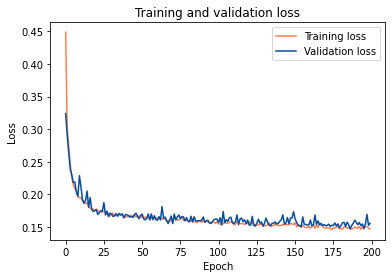

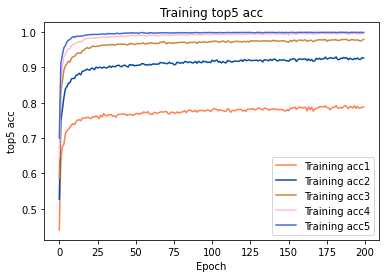

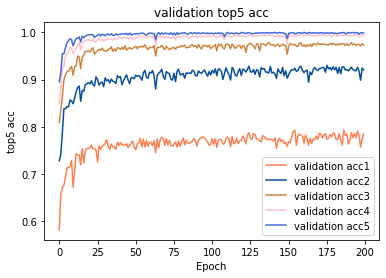

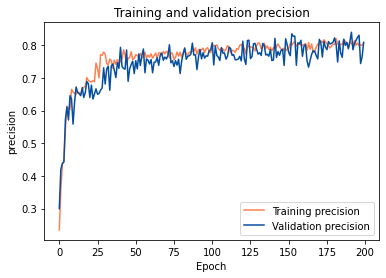

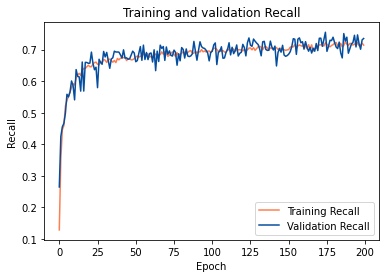

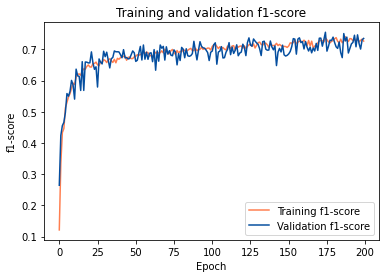

1636797020.706517


In [86]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)

### 1层CNN
(nn.Conv1d(in_channels=7, out_channels=64, kernel_size=3, stride=1, padding=2)) 

1636120578.458449
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.5723 	 valid Loss: 0.3824
train acc1: 0.5039 	 valid acc1: 0.5068
train acc2: 0.6138 	 valid acc2: 0.6379
train acc3: 0.6879 	 valid acc3: 0.7475
train acc4: 0.7423 	 valid acc4: 0.8093
train acc5: 0.7868 	 valid acc5: 0.8489
train precision: 0.2438 	 valid precision: 0.0317
train recall: 0.0913 	 valid recall: 0.0625
train f1-score: 0.0916 	 valid f1-score: 0.0420
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.3493 	 valid Loss: 0.3083
train acc1: 0.5457 	 valid acc1: 0.6096
train acc2: 0.6867 	 valid acc2: 0.7375
train acc3: 0.7720 	 valid acc3: 0.8389
train acc4: 0.8413 	 valid acc4: 0.8764
train acc5: 0.8887 	 valid acc5: 0.9132
train precision: 0.2824 	 valid precision: 0.2748
train recall: 0.1576 	 valid recall: 0.2844
train f1-score: 0.1662 	 valid f1-score: 0.2461
-------第 3 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2993 	 valid Loss: 0.2762
train acc1: 0.6371 	 valid acc1: 0.6604
train acc2: 0.7699 	 valid acc2: 0.8054
train acc3: 0.8408 	 valid acc3: 0.8739
train acc4: 0.8905 	 valid acc4: 0.9046
train acc5: 0.9179 	 valid acc5: 0.9268
train precision: 0.4090 	 valid precision: 0.4170
train recall: 0.3647 	 valid recall: 0.3899
train f1-score: 0.3538 	 valid f1-score: 0.3771
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2778 	 valid Loss: 0.2620
train acc1: 0.6540 	 valid acc1: 0.6721
train acc2: 0.7870 	 valid acc2: 0.8018
train acc3: 0.8617 	 valid acc3: 0.8761
train acc4: 0.9014 	 valid acc4: 0.9029
train acc5: 0.9288 	 valid acc5: 0.9321
train precision: 0.4198 	 valid precision: 0.4261
train recall: 0.4035 	 valid recall: 0.4150
train f1-score: 0.3886 	 valid f1-score: 0.4025
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2678 	 valid Loss: 0.2534
train acc1: 0.6623 	 valid acc1: 0.6686
train acc2: 0.7926 	 valid acc2: 0.8132
train acc3: 0.8664 	 valid acc3: 0.8836
train acc4: 0.9062 	 valid acc4: 0.9225
train acc5: 0.9345 	 valid acc5: 0.9486
train precision: 0.4285 	 valid precision: 0.4213
train recall: 0.4219 	 valid recall: 0.4077
train f1-score: 0.4094 	 valid f1-score: 0.3907
-------第 6 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2605 	 valid Loss: 0.2463
train acc1: 0.6625 	 valid acc1: 0.6764
train acc2: 0.8006 	 valid acc2: 0.8254
train acc3: 0.8721 	 valid acc3: 0.8904
train acc4: 0.9140 	 valid acc4: 0.9271
train acc5: 0.9450 	 valid acc5: 0.9525
train precision: 0.4673 	 valid precision: 0.4252
train recall: 0.4223 	 valid recall: 0.4242
train f1-score: 0.4097 	 valid f1-score: 0.4086
-------第 7 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2538 	 valid Loss: 0.2391
train acc1: 0.6710 	 valid acc1: 0.6907
train acc2: 0.8038 	 valid acc2: 0.8289
train acc3: 0.8840 	 valid acc3: 0.8954
train acc4: 0.9237 	 valid acc4: 0.9329
train acc5: 0.9512 	 valid acc5: 0.9582
train precision: 0.4802 	 valid precision: 0.4891
train recall: 0.4385 	 valid recall: 0.4500
train f1-score: 0.4314 	 valid f1-score: 0.4438
-------第 8 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2464 	 valid Loss: 0.2316
train acc1: 0.6821 	 valid acc1: 0.7021
train acc2: 0.8143 	 valid acc2: 0.8318
train acc3: 0.8869 	 valid acc3: 0.9071
train acc4: 0.9315 	 valid acc4: 0.9368
train acc5: 0.9569 	 valid acc5: 0.9607
train precision: 0.4759 	 valid precision: 0.4772
train recall: 0.4626 	 valid recall: 0.4701
train f1-score: 0.4569 	 valid f1-score: 0.4630
-------第 9 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2386 	 valid Loss: 0.2253
train acc1: 0.6854 	 valid acc1: 0.7029
train acc2: 0.8185 	 valid acc2: 0.8332
train acc3: 0.8927 	 valid acc3: 0.9107
train acc4: 0.9329 	 valid acc4: 0.9439
train acc5: 0.9601 	 valid acc5: 0.9643
train precision: 0.4914 	 valid precision: 0.4953
train recall: 0.4720 	 valid recall: 0.4766
train f1-score: 0.4641 	 valid f1-score: 0.4686
-------第 10 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2317 	 valid Loss: 0.2199
train acc1: 0.6870 	 valid acc1: 0.7057
train acc2: 0.8277 	 valid acc2: 0.8411
train acc3: 0.9002 	 valid acc3: 0.9154
train acc4: 0.9399 	 valid acc4: 0.9507
train acc5: 0.9658 	 valid acc5: 0.9682
train precision: 0.4945 	 valid precision: 0.5019
train recall: 0.4810 	 valid recall: 0.4820
train f1-score: 0.4746 	 valid f1-score: 0.4752
-------第 11 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2260 	 valid Loss: 0.2169
train acc1: 0.6896 	 valid acc1: 0.7046
train acc2: 0.8327 	 valid acc2: 0.8525
train acc3: 0.9045 	 valid acc3: 0.9164
train acc4: 0.9438 	 valid acc4: 0.9457
train acc5: 0.9713 	 valid acc5: 0.9718
train precision: 0.5023 	 valid precision: 0.5087
train recall: 0.4893 	 valid recall: 0.4802
train f1-score: 0.4848 	 valid f1-score: 0.4752
-------第 12 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2211 	 valid Loss: 0.2128
train acc1: 0.6926 	 valid acc1: 0.7157
train acc2: 0.8392 	 valid acc2: 0.8525
train acc3: 0.9098 	 valid acc3: 0.9250
train acc4: 0.9486 	 valid acc4: 0.9575
train acc5: 0.9737 	 valid acc5: 0.9761
train precision: 0.5452 	 valid precision: 0.5408
train recall: 0.4945 	 valid recall: 0.5117
train f1-score: 0.4916 	 valid f1-score: 0.5080
-------第 13 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2177 	 valid Loss: 0.2094
train acc1: 0.6968 	 valid acc1: 0.7118
train acc2: 0.8455 	 valid acc2: 0.8557
train acc3: 0.9168 	 valid acc3: 0.9261
train acc4: 0.9554 	 valid acc4: 0.9664
train acc5: 0.9765 	 valid acc5: 0.9796
train precision: 0.5694 	 valid precision: 0.5473
train recall: 0.5062 	 valid recall: 0.4990
train f1-score: 0.5053 	 valid f1-score: 0.4967
-------第 14 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2134 	 valid Loss: 0.2044
train acc1: 0.6983 	 valid acc1: 0.7221
train acc2: 0.8512 	 valid acc2: 0.8636
train acc3: 0.9183 	 valid acc3: 0.9311
train acc4: 0.9583 	 valid acc4: 0.9646
train acc5: 0.9800 	 valid acc5: 0.9800
train precision: 0.6435 	 valid precision: 0.6146
train recall: 0.5099 	 valid recall: 0.5222
train f1-score: 0.5106 	 valid f1-score: 0.5235
-------第 15 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2096 	 valid Loss: 0.2022
train acc1: 0.7014 	 valid acc1: 0.7218
train acc2: 0.8531 	 valid acc2: 0.8714
train acc3: 0.9231 	 valid acc3: 0.9293
train acc4: 0.9607 	 valid acc4: 0.9700
train acc5: 0.9792 	 valid acc5: 0.9821
train precision: 0.6570 	 valid precision: 0.6271
train recall: 0.5170 	 valid recall: 0.5185
train f1-score: 0.5182 	 valid f1-score: 0.5244
-------第 16 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2064 	 valid Loss: 0.1990
train acc1: 0.7048 	 valid acc1: 0.7182
train acc2: 0.8608 	 valid acc2: 0.8643
train acc3: 0.9287 	 valid acc3: 0.9343
train acc4: 0.9646 	 valid acc4: 0.9657
train acc5: 0.9807 	 valid acc5: 0.9832
train precision: 0.7238 	 valid precision: 0.6177
train recall: 0.5235 	 valid recall: 0.5141
train f1-score: 0.5278 	 valid f1-score: 0.5114
-------第 17 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2028 	 valid Loss: 0.1946
train acc1: 0.7118 	 valid acc1: 0.7229
train acc2: 0.8620 	 valid acc2: 0.8807
train acc3: 0.9286 	 valid acc3: 0.9371
train acc4: 0.9679 	 valid acc4: 0.9679
train acc5: 0.9815 	 valid acc5: 0.9807
train precision: 0.6556 	 valid precision: 0.6190
train recall: 0.5361 	 valid recall: 0.5188
train f1-score: 0.5435 	 valid f1-score: 0.5214
-------第 18 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1997 	 valid Loss: 0.1921
train acc1: 0.7139 	 valid acc1: 0.7254
train acc2: 0.8655 	 valid acc2: 0.8782
train acc3: 0.9336 	 valid acc3: 0.9379
train acc4: 0.9702 	 valid acc4: 0.9696
train acc5: 0.9833 	 valid acc5: 0.9814
train precision: 0.7178 	 valid precision: 0.6252
train recall: 0.5406 	 valid recall: 0.5259
train f1-score: 0.5496 	 valid f1-score: 0.5332
-------第 19 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1971 	 valid Loss: 0.1905
train acc1: 0.7190 	 valid acc1: 0.7268
train acc2: 0.8679 	 valid acc2: 0.8757
train acc3: 0.9365 	 valid acc3: 0.9429
train acc4: 0.9711 	 valid acc4: 0.9689
train acc5: 0.9830 	 valid acc5: 0.9814
train precision: 0.7346 	 valid precision: 0.6335
train recall: 0.5510 	 valid recall: 0.5339
train f1-score: 0.5603 	 valid f1-score: 0.5427
-------第 20 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1942 	 valid Loss: 0.1873
train acc1: 0.7219 	 valid acc1: 0.7343
train acc2: 0.8748 	 valid acc2: 0.8800
train acc3: 0.9382 	 valid acc3: 0.9400
train acc4: 0.9710 	 valid acc4: 0.9718
train acc5: 0.9829 	 valid acc5: 0.9843
train precision: 0.7168 	 valid precision: 0.6482
train recall: 0.5594 	 valid recall: 0.5484
train f1-score: 0.5725 	 valid f1-score: 0.5540
-------第 21 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1916 	 valid Loss: 0.1842
train acc1: 0.7260 	 valid acc1: 0.7325
train acc2: 0.8765 	 valid acc2: 0.8839
train acc3: 0.9377 	 valid acc3: 0.9446
train acc4: 0.9704 	 valid acc4: 0.9739
train acc5: 0.9827 	 valid acc5: 0.9861
train precision: 0.7464 	 valid precision: 0.6336
train recall: 0.5656 	 valid recall: 0.5433
train f1-score: 0.5776 	 valid f1-score: 0.5570
-------第 22 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1893 	 valid Loss: 0.1834
train acc1: 0.7292 	 valid acc1: 0.7400
train acc2: 0.8783 	 valid acc2: 0.8864
train acc3: 0.9419 	 valid acc3: 0.9418
train acc4: 0.9731 	 valid acc4: 0.9721
train acc5: 0.9854 	 valid acc5: 0.9843
train precision: 0.6965 	 valid precision: 0.7386
train recall: 0.5712 	 valid recall: 0.5616
train f1-score: 0.5854 	 valid f1-score: 0.5750
-------第 23 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1876 	 valid Loss: 0.1811
train acc1: 0.7306 	 valid acc1: 0.7436
train acc2: 0.8811 	 valid acc2: 0.8861
train acc3: 0.9424 	 valid acc3: 0.9475
train acc4: 0.9725 	 valid acc4: 0.9696
train acc5: 0.9855 	 valid acc5: 0.9836
train precision: 0.7374 	 valid precision: 0.7086
train recall: 0.5764 	 valid recall: 0.5671
train f1-score: 0.5915 	 valid f1-score: 0.5802
-------第 24 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1856 	 valid Loss: 0.1819
train acc1: 0.7335 	 valid acc1: 0.7400
train acc2: 0.8835 	 valid acc2: 0.8839
train acc3: 0.9446 	 valid acc3: 0.9468
train acc4: 0.9749 	 valid acc4: 0.9718
train acc5: 0.9867 	 valid acc5: 0.9864
train precision: 0.7628 	 valid precision: 0.6612
train recall: 0.5849 	 valid recall: 0.5590
train f1-score: 0.5999 	 valid f1-score: 0.5723
-------第 25 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1833 	 valid Loss: 0.1788
train acc1: 0.7387 	 valid acc1: 0.7507
train acc2: 0.8835 	 valid acc2: 0.8886
train acc3: 0.9452 	 valid acc3: 0.9475
train acc4: 0.9750 	 valid acc4: 0.9743
train acc5: 0.9868 	 valid acc5: 0.9850
train precision: 0.7488 	 valid precision: 0.7007
train recall: 0.5925 	 valid recall: 0.5762
train f1-score: 0.6092 	 valid f1-score: 0.5843
-------第 26 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1819 	 valid Loss: 0.1779
train acc1: 0.7394 	 valid acc1: 0.7482
train acc2: 0.8835 	 valid acc2: 0.8836
train acc3: 0.9451 	 valid acc3: 0.9425
train acc4: 0.9758 	 valid acc4: 0.9771
train acc5: 0.9865 	 valid acc5: 0.9879
train precision: 0.7605 	 valid precision: 0.7081
train recall: 0.5959 	 valid recall: 0.5806
train f1-score: 0.6133 	 valid f1-score: 0.5852
-------第 27 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1797 	 valid Loss: 0.1747
train acc1: 0.7443 	 valid acc1: 0.7564
train acc2: 0.8864 	 valid acc2: 0.8957
train acc3: 0.9456 	 valid acc3: 0.9479
train acc4: 0.9757 	 valid acc4: 0.9739
train acc5: 0.9857 	 valid acc5: 0.9829
train precision: 0.7552 	 valid precision: 0.7368
train recall: 0.6040 	 valid recall: 0.5936
train f1-score: 0.6207 	 valid f1-score: 0.6095
-------第 28 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1776 	 valid Loss: 0.1736
train acc1: 0.7488 	 valid acc1: 0.7539
train acc2: 0.8880 	 valid acc2: 0.8886
train acc3: 0.9501 	 valid acc3: 0.9521
train acc4: 0.9754 	 valid acc4: 0.9746
train acc5: 0.9868 	 valid acc5: 0.9829
train precision: 0.7557 	 valid precision: 0.7493
train recall: 0.6132 	 valid recall: 0.5866
train f1-score: 0.6325 	 valid f1-score: 0.6090
-------第 29 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1760 	 valid Loss: 0.1712
train acc1: 0.7514 	 valid acc1: 0.7679
train acc2: 0.8898 	 valid acc2: 0.8896
train acc3: 0.9498 	 valid acc3: 0.9489
train acc4: 0.9779 	 valid acc4: 0.9725
train acc5: 0.9889 	 valid acc5: 0.9839
train precision: 0.7643 	 valid precision: 0.7432
train recall: 0.6201 	 valid recall: 0.6280
train f1-score: 0.6404 	 valid f1-score: 0.6377
-------第 30 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1749 	 valid Loss: 0.1684
train acc1: 0.7512 	 valid acc1: 0.7668
train acc2: 0.8925 	 valid acc2: 0.8989
train acc3: 0.9507 	 valid acc3: 0.9489
train acc4: 0.9777 	 valid acc4: 0.9736
train acc5: 0.9883 	 valid acc5: 0.9846
train precision: 0.7460 	 valid precision: 0.7414
train recall: 0.6203 	 valid recall: 0.6153
train f1-score: 0.6402 	 valid f1-score: 0.6304
-------第 31 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1726 	 valid Loss: 0.1685
train acc1: 0.7583 	 valid acc1: 0.7771
train acc2: 0.8927 	 valid acc2: 0.8946
train acc3: 0.9493 	 valid acc3: 0.9504
train acc4: 0.9768 	 valid acc4: 0.9761
train acc5: 0.9887 	 valid acc5: 0.9893
train precision: 0.7597 	 valid precision: 0.7518
train recall: 0.6330 	 valid recall: 0.6332
train f1-score: 0.6513 	 valid f1-score: 0.6437
-------第 32 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1709 	 valid Loss: 0.1664
train acc1: 0.7626 	 valid acc1: 0.7729
train acc2: 0.8954 	 valid acc2: 0.8986
train acc3: 0.9517 	 valid acc3: 0.9543
train acc4: 0.9785 	 valid acc4: 0.9764
train acc5: 0.9895 	 valid acc5: 0.9875
train precision: 0.7662 	 valid precision: 0.7417
train recall: 0.6410 	 valid recall: 0.6290
train f1-score: 0.6587 	 valid f1-score: 0.6451
-------第 33 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1697 	 valid Loss: 0.1658
train acc1: 0.7610 	 valid acc1: 0.7700
train acc2: 0.8975 	 valid acc2: 0.8961
train acc3: 0.9543 	 valid acc3: 0.9521
train acc4: 0.9780 	 valid acc4: 0.9761
train acc5: 0.9894 	 valid acc5: 0.9875
train precision: 0.7603 	 valid precision: 0.7527
train recall: 0.6383 	 valid recall: 0.6238
train f1-score: 0.6560 	 valid f1-score: 0.6417
-------第 34 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1692 	 valid Loss: 0.1640
train acc1: 0.7610 	 valid acc1: 0.7821
train acc2: 0.8971 	 valid acc2: 0.9064
train acc3: 0.9545 	 valid acc3: 0.9543
train acc4: 0.9788 	 valid acc4: 0.9779
train acc5: 0.9906 	 valid acc5: 0.9889
train precision: 0.7528 	 valid precision: 0.7565
train recall: 0.6378 	 valid recall: 0.6493
train f1-score: 0.6552 	 valid f1-score: 0.6574
-------第 35 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1679 	 valid Loss: 0.1623
train acc1: 0.7658 	 valid acc1: 0.7782
train acc2: 0.8992 	 valid acc2: 0.8989
train acc3: 0.9529 	 valid acc3: 0.9514
train acc4: 0.9799 	 valid acc4: 0.9754
train acc5: 0.9910 	 valid acc5: 0.9864
train precision: 0.7599 	 valid precision: 0.7487
train recall: 0.6533 	 valid recall: 0.6411
train f1-score: 0.6674 	 valid f1-score: 0.6559
-------第 36 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1667 	 valid Loss: 0.1605
train acc1: 0.7645 	 valid acc1: 0.7771
train acc2: 0.8989 	 valid acc2: 0.9086
train acc3: 0.9564 	 valid acc3: 0.9554
train acc4: 0.9806 	 valid acc4: 0.9814
train acc5: 0.9887 	 valid acc5: 0.9907
train precision: 0.7551 	 valid precision: 0.7893
train recall: 0.6480 	 valid recall: 0.6313
train f1-score: 0.6644 	 valid f1-score: 0.6521
-------第 37 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1650 	 valid Loss: 0.1589
train acc1: 0.7701 	 valid acc1: 0.7839
train acc2: 0.9015 	 valid acc2: 0.9061
train acc3: 0.9558 	 valid acc3: 0.9543
train acc4: 0.9808 	 valid acc4: 0.9746
train acc5: 0.9911 	 valid acc5: 0.9879
train precision: 0.7632 	 valid precision: 0.7818
train recall: 0.6571 	 valid recall: 0.6489
train f1-score: 0.6738 	 valid f1-score: 0.6611
-------第 38 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1629 	 valid Loss: 0.1598
train acc1: 0.7733 	 valid acc1: 0.7757
train acc2: 0.9014 	 valid acc2: 0.9132
train acc3: 0.9557 	 valid acc3: 0.9543
train acc4: 0.9808 	 valid acc4: 0.9814
train acc5: 0.9899 	 valid acc5: 0.9921
train precision: 0.7677 	 valid precision: 0.7628
train recall: 0.6609 	 valid recall: 0.6354
train f1-score: 0.6768 	 valid f1-score: 0.6479
-------第 39 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1634 	 valid Loss: 0.1574
train acc1: 0.7740 	 valid acc1: 0.7854
train acc2: 0.9054 	 valid acc2: 0.9079
train acc3: 0.9557 	 valid acc3: 0.9593
train acc4: 0.9798 	 valid acc4: 0.9796
train acc5: 0.9904 	 valid acc5: 0.9879
train precision: 0.7650 	 valid precision: 0.7611
train recall: 0.6658 	 valid recall: 0.6499
train f1-score: 0.6812 	 valid f1-score: 0.6756
-------第 40 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1603 	 valid Loss: 0.1576
train acc1: 0.7779 	 valid acc1: 0.7943
train acc2: 0.9060 	 valid acc2: 0.9104
train acc3: 0.9602 	 valid acc3: 0.9561
train acc4: 0.9815 	 valid acc4: 0.9768
train acc5: 0.9908 	 valid acc5: 0.9875
train precision: 0.7737 	 valid precision: 0.7559
train recall: 0.6692 	 valid recall: 0.6738
train f1-score: 0.6868 	 valid f1-score: 0.6859
-------第 41 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1613 	 valid Loss: 0.1571
train acc1: 0.7750 	 valid acc1: 0.7796
train acc2: 0.9067 	 valid acc2: 0.9014
train acc3: 0.9588 	 valid acc3: 0.9596
train acc4: 0.9814 	 valid acc4: 0.9789
train acc5: 0.9913 	 valid acc5: 0.9882
train precision: 0.7571 	 valid precision: 0.7752
train recall: 0.6694 	 valid recall: 0.6395
train f1-score: 0.6861 	 valid f1-score: 0.6587
-------第 42 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1595 	 valid Loss: 0.1553
train acc1: 0.7775 	 valid acc1: 0.7939
train acc2: 0.9082 	 valid acc2: 0.9050
train acc3: 0.9582 	 valid acc3: 0.9579
train acc4: 0.9806 	 valid acc4: 0.9768
train acc5: 0.9911 	 valid acc5: 0.9882
train precision: 0.7620 	 valid precision: 0.7897
train recall: 0.6695 	 valid recall: 0.6654
train f1-score: 0.6855 	 valid f1-score: 0.6766
-------第 43 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1584 	 valid Loss: 0.1543
train acc1: 0.7812 	 valid acc1: 0.7968
train acc2: 0.9073 	 valid acc2: 0.9096
train acc3: 0.9590 	 valid acc3: 0.9546
train acc4: 0.9824 	 valid acc4: 0.9796
train acc5: 0.9917 	 valid acc5: 0.9893
train precision: 0.7636 	 valid precision: 0.7568
train recall: 0.6754 	 valid recall: 0.6787
train f1-score: 0.6908 	 valid f1-score: 0.6916
-------第 44 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1579 	 valid Loss: 0.1534
train acc1: 0.7790 	 valid acc1: 0.7968
train acc2: 0.9095 	 valid acc2: 0.9089
train acc3: 0.9606 	 valid acc3: 0.9550
train acc4: 0.9833 	 valid acc4: 0.9782
train acc5: 0.9919 	 valid acc5: 0.9879
train precision: 0.7655 	 valid precision: 0.7578
train recall: 0.6762 	 valid recall: 0.6828
train f1-score: 0.6928 	 valid f1-score: 0.6920
-------第 45 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1567 	 valid Loss: 0.1526
train acc1: 0.7839 	 valid acc1: 0.7875
train acc2: 0.9114 	 valid acc2: 0.9129
train acc3: 0.9611 	 valid acc3: 0.9579
train acc4: 0.9824 	 valid acc4: 0.9800
train acc5: 0.9920 	 valid acc5: 0.9896
train precision: 0.7737 	 valid precision: 0.7703
train recall: 0.6828 	 valid recall: 0.6471
train f1-score: 0.6984 	 valid f1-score: 0.6678
-------第 46 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1559 	 valid Loss: 0.1513
train acc1: 0.7876 	 valid acc1: 0.7975
train acc2: 0.9095 	 valid acc2: 0.9071
train acc3: 0.9604 	 valid acc3: 0.9579
train acc4: 0.9835 	 valid acc4: 0.9764
train acc5: 0.9913 	 valid acc5: 0.9886
train precision: 0.7738 	 valid precision: 0.7685
train recall: 0.6873 	 valid recall: 0.6839
train f1-score: 0.7031 	 valid f1-score: 0.6991
-------第 47 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1553 	 valid Loss: 0.1505
train acc1: 0.7850 	 valid acc1: 0.7993
train acc2: 0.9115 	 valid acc2: 0.9107
train acc3: 0.9601 	 valid acc3: 0.9607
train acc4: 0.9836 	 valid acc4: 0.9832
train acc5: 0.9921 	 valid acc5: 0.9907
train precision: 0.7766 	 valid precision: 0.7686
train recall: 0.6843 	 valid recall: 0.6899
train f1-score: 0.7018 	 valid f1-score: 0.7049
-------第 48 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1540 	 valid Loss: 0.1509
train acc1: 0.7879 	 valid acc1: 0.8007
train acc2: 0.9120 	 valid acc2: 0.9046
train acc3: 0.9623 	 valid acc3: 0.9629
train acc4: 0.9840 	 valid acc4: 0.9779
train acc5: 0.9929 	 valid acc5: 0.9900
train precision: 0.7798 	 valid precision: 0.7666
train recall: 0.6928 	 valid recall: 0.6841
train f1-score: 0.7073 	 valid f1-score: 0.6940
-------第 49 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1538 	 valid Loss: 0.1528
train acc1: 0.7867 	 valid acc1: 0.7900
train acc2: 0.9148 	 valid acc2: 0.9114
train acc3: 0.9625 	 valid acc3: 0.9554
train acc4: 0.9835 	 valid acc4: 0.9782
train acc5: 0.9921 	 valid acc5: 0.9896
train precision: 0.7769 	 valid precision: 0.7435
train recall: 0.6900 	 valid recall: 0.6584
train f1-score: 0.7053 	 valid f1-score: 0.6752
-------第 50 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1519 	 valid Loss: 0.1491
train acc1: 0.7910 	 valid acc1: 0.7939
train acc2: 0.9155 	 valid acc2: 0.9161
train acc3: 0.9627 	 valid acc3: 0.9589
train acc4: 0.9843 	 valid acc4: 0.9825
train acc5: 0.9930 	 valid acc5: 0.9925
train precision: 0.7793 	 valid precision: 0.7759
train recall: 0.6999 	 valid recall: 0.6669
train f1-score: 0.7135 	 valid f1-score: 0.6857
-------第 51 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1521 	 valid Loss: 0.1476
train acc1: 0.7895 	 valid acc1: 0.8036
train acc2: 0.9177 	 valid acc2: 0.9207
train acc3: 0.9636 	 valid acc3: 0.9618
train acc4: 0.9844 	 valid acc4: 0.9839
train acc5: 0.9917 	 valid acc5: 0.9914
train precision: 0.7812 	 valid precision: 0.7809
train recall: 0.6949 	 valid recall: 0.6925
train f1-score: 0.7117 	 valid f1-score: 0.7088
-------第 52 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1507 	 valid Loss: 0.1471
train acc1: 0.7923 	 valid acc1: 0.7954
train acc2: 0.9176 	 valid acc2: 0.9096
train acc3: 0.9638 	 valid acc3: 0.9636
train acc4: 0.9844 	 valid acc4: 0.9832
train acc5: 0.9930 	 valid acc5: 0.9932
train precision: 0.7814 	 valid precision: 0.7612
train recall: 0.6993 	 valid recall: 0.6708
train f1-score: 0.7145 	 valid f1-score: 0.6864
-------第 53 轮训练开始-------
train Loss: 0.1507 	 valid Loss: 0.1482
train acc1: 0.7918 	 valid acc1: 0.8139
train acc2: 0.9180 	 valid acc2: 0.9161
train acc3: 0.9658 	 valid acc3: 0.9596
train acc4: 0.9857 	 valid acc4: 0.9836
train acc5: 0.9927 	 valid acc5: 0.9904
train precision: 0.7724 	 valid precision: 0.7756
train recall: 0.6991 	 valid recall: 0.7216
train f1-score: 0.7133 	 valid f1-score: 0.7341
-------第 54 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1495 	 valid Loss: 0.1452
train acc1: 0.7936 	 valid acc1: 0.8175
train acc2: 0.9180 	 valid acc2: 0.9121
train acc3: 0.9658 	 valid acc3: 0.9607
train acc4: 0.9863 	 valid acc4: 0.9807
train acc5: 0.9929 	 valid acc5: 0.9914
train precision: 0.7826 	 valid precision: 0.7886
train recall: 0.6999 	 valid recall: 0.7239
train f1-score: 0.7161 	 valid f1-score: 0.7364
-------第 55 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1480 	 valid Loss: 0.1481
train acc1: 0.7940 	 valid acc1: 0.8168
train acc2: 0.9199 	 valid acc2: 0.9193
train acc3: 0.9655 	 valid acc3: 0.9600
train acc4: 0.9854 	 valid acc4: 0.9836
train acc5: 0.9927 	 valid acc5: 0.9921
train precision: 0.7794 	 valid precision: 0.7958
train recall: 0.7027 	 valid recall: 0.7307
train f1-score: 0.7155 	 valid f1-score: 0.7389
-------第 56 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1477 	 valid Loss: 0.1447
train acc1: 0.7992 	 valid acc1: 0.8057
train acc2: 0.9195 	 valid acc2: 0.9186
train acc3: 0.9657 	 valid acc3: 0.9636
train acc4: 0.9862 	 valid acc4: 0.9814
train acc5: 0.9940 	 valid acc5: 0.9904
train precision: 0.7919 	 valid precision: 0.7653
train recall: 0.7101 	 valid recall: 0.7072
train f1-score: 0.7261 	 valid f1-score: 0.7189
-------第 57 轮训练开始-------
train Loss: 0.1468 	 valid Loss: 0.1443
train acc1: 0.7979 	 valid acc1: 0.8093
train acc2: 0.9192 	 valid acc2: 0.9218
train acc3: 0.9638 	 valid acc3: 0.9618
train acc4: 0.9852 	 valid acc4: 0.9829
train acc5: 0.9942 	 valid acc5: 0.9921
train precision: 0.7801 	 valid precision: 0.7719
train recall: 0.7103 	 valid recall: 0.7124
train f1-score: 0.7247 	 valid f1-score: 0.7243
-------第 58 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1476 	 valid Loss: 0.1462
train acc1: 0.7958 	 valid acc1: 0.8011
train acc2: 0.9208 	 valid acc2: 0.9164
train acc3: 0.9655 	 valid acc3: 0.9629
train acc4: 0.9870 	 valid acc4: 0.9839
train acc5: 0.9944 	 valid acc5: 0.9911
train precision: 0.7776 	 valid precision: 0.7702
train recall: 0.7081 	 valid recall: 0.6832
train f1-score: 0.7225 	 valid f1-score: 0.7025
-------第 59 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1471 	 valid Loss: 0.1450
train acc1: 0.7993 	 valid acc1: 0.7936
train acc2: 0.9219 	 valid acc2: 0.9111
train acc3: 0.9668 	 valid acc3: 0.9632
train acc4: 0.9867 	 valid acc4: 0.9846
train acc5: 0.9938 	 valid acc5: 0.9921
train precision: 0.7850 	 valid precision: 0.7631
train recall: 0.7137 	 valid recall: 0.6688
train f1-score: 0.7294 	 valid f1-score: 0.6864
-------第 60 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1468 	 valid Loss: 0.1488
train acc1: 0.7985 	 valid acc1: 0.7907
train acc2: 0.9252 	 valid acc2: 0.9179
train acc3: 0.9658 	 valid acc3: 0.9654
train acc4: 0.9851 	 valid acc4: 0.9861
train acc5: 0.9935 	 valid acc5: 0.9939
train precision: 0.8455 	 valid precision: 0.7520
train recall: 0.7102 	 valid recall: 0.6464
train f1-score: 0.7247 	 valid f1-score: 0.6679
-------第 61 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1448 	 valid Loss: 0.1436
train acc1: 0.8032 	 valid acc1: 0.8154
train acc2: 0.9257 	 valid acc2: 0.9264
train acc3: 0.9675 	 valid acc3: 0.9625
train acc4: 0.9862 	 valid acc4: 0.9839
train acc5: 0.9938 	 valid acc5: 0.9936
train precision: 0.7902 	 valid precision: 0.7795
train recall: 0.7188 	 valid recall: 0.7205
train f1-score: 0.7337 	 valid f1-score: 0.7363
-------第 62 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1448 	 valid Loss: 0.1408
train acc1: 0.8008 	 valid acc1: 0.8168
train acc2: 0.9237 	 valid acc2: 0.9229
train acc3: 0.9667 	 valid acc3: 0.9675
train acc4: 0.9865 	 valid acc4: 0.9850
train acc5: 0.9948 	 valid acc5: 0.9929
train precision: 0.8229 	 valid precision: 0.7864
train recall: 0.7162 	 valid recall: 0.7206
train f1-score: 0.7304 	 valid f1-score: 0.7336
-------第 63 轮训练开始-------
train Loss: 0.1435 	 valid Loss: 0.1450
train acc1: 0.8017 	 valid acc1: 0.8068
train acc2: 0.9246 	 valid acc2: 0.9157
train acc3: 0.9673 	 valid acc3: 0.9621
train acc4: 0.9865 	 valid acc4: 0.9825
train acc5: 0.9950 	 valid acc5: 0.9907
train precision: 0.7856 	 valid precision: 0.7868
train recall: 0.7174 	 valid recall: 0.7036
train f1-score: 0.7318 	 valid f1-score: 0.7133
-------第 64 轮训练开始-------
train Loss: 0.1438 	 valid Loss: 0.1422
train acc1: 0.8001 	 valid acc1: 0.8186
train acc2: 0.9235 	 valid acc2: 0.9225
train acc3: 0.9656 	 valid acc3: 0.9643
train acc4: 0.9876 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1443 	 valid Loss: 0.1439
train acc1: 0.8004 	 valid acc1: 0.8079
train acc2: 0.9249 	 valid acc2: 0.9164
train acc3: 0.9683 	 valid acc3: 0.9639
train acc4: 0.9876 	 valid acc4: 0.9832
train acc5: 0.9949 	 valid acc5: 0.9929
train precision: 0.7808 	 valid precision: 0.7621
train recall: 0.7158 	 valid recall: 0.7239
train f1-score: 0.7287 	 valid f1-score: 0.7279
-------第 66 轮训练开始-------
train Loss: 0.1428 	 valid Loss: 0.1392
train acc1: 0.8039 	 valid acc1: 0.8171
train acc2: 0.9267 	 valid acc2: 0.9225
train acc3: 0.9673 	 valid acc3: 0.9693
train acc4: 0.9882 	 valid acc4: 0.9864
train acc5: 0.9956 	 valid acc5: 0.9936
train precision: 0.7857 	 valid precision: 0.7745
train recall: 0.7244 	 valid recall: 0.7185
train f1-score: 0.7370 	 valid f1-score: 0.7295
-------第 67 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1428 	 valid Loss: 0.1407
train acc1: 0.8026 	 valid acc1: 0.8196
train acc2: 0.9271 	 valid acc2: 0.9289
train acc3: 0.9671 	 valid acc3: 0.9646
train acc4: 0.9875 	 valid acc4: 0.9864
train acc5: 0.9949 	 valid acc5: 0.9943
train precision: 0.7839 	 valid precision: 0.7796
train recall: 0.7205 	 valid recall: 0.7345
train f1-score: 0.7345 	 valid f1-score: 0.7460
-------第 68 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1417 	 valid Loss: 0.1398
train acc1: 0.8050 	 valid acc1: 0.8014
train acc2: 0.9251 	 valid acc2: 0.9268
train acc3: 0.9692 	 valid acc3: 0.9668
train acc4: 0.9887 	 valid acc4: 0.9846
train acc5: 0.9956 	 valid acc5: 0.9907
train precision: 0.7885 	 valid precision: 0.7627
train recall: 0.7263 	 valid recall: 0.6789
train f1-score: 0.7398 	 valid f1-score: 0.7002
-------第 69 轮训练开始-------
train Loss: 0.1412 	 valid Loss: 0.1387
train acc1: 0.8040 	 valid acc1: 0.8104
train acc2: 0.9274 	 valid acc2: 0.9271
train acc3: 0.9693 	 valid acc3: 0.9704
train acc4: 0.9881 	 valid acc4: 0.9868
train acc5: 0.9949 	 valid acc5: 0.9932
train precision: 0.7991 	 valid precision: 0.7684
train recall: 0.7230 	 valid recall: 0.7071
train f1-score: 0.7365 	 valid f1-score: 0.7220
-------第 70 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1411 	 valid Loss: 0.1383
train acc1: 0.8036 	 valid acc1: 0.8146
train acc2: 0.9310 	 valid acc2: 0.9300
train acc3: 0.9694 	 valid acc3: 0.9671
train acc4: 0.9887 	 valid acc4: 0.9839
train acc5: 0.9955 	 valid acc5: 0.9932
train precision: 0.7951 	 valid precision: 0.7818
train recall: 0.7214 	 valid recall: 0.7133
train f1-score: 0.7365 	 valid f1-score: 0.7314
-------第 71 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1403 	 valid Loss: 0.1380
train acc1: 0.8057 	 valid acc1: 0.8232
train acc2: 0.9299 	 valid acc2: 0.9271
train acc3: 0.9711 	 valid acc3: 0.9675
train acc4: 0.9889 	 valid acc4: 0.9843
train acc5: 0.9949 	 valid acc5: 0.9946
train precision: 0.7862 	 valid precision: 0.7845
train recall: 0.7270 	 valid recall: 0.7421
train f1-score: 0.7405 	 valid f1-score: 0.7506
-------第 72 轮训练开始-------
train Loss: 0.1393 	 valid Loss: 0.1385
train acc1: 0.8074 	 valid acc1: 0.8100
train acc2: 0.9294 	 valid acc2: 0.9318
train acc3: 0.9687 	 valid acc3: 0.9675
train acc4: 0.9882 	 valid acc4: 0.9864
train acc5: 0.9956 	 valid acc5: 0.9939
train precision: 0.8398 	 valid precision: 0.7837
train recall: 0.7296 	 valid recall: 0.7074
train f1-score: 0.7437 	 valid f1-score: 0.7295
-------第 73 轮训练开始-------
train Loss: 0.1389 	 valid Loss: 0.1367
train acc1: 0.8112 	 valid acc1: 0.8204
train acc2: 0.9302 	 valid acc2: 0.9264
train acc3: 0.9723 	 valid acc3: 0.9689
train acc4: 0.9890 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1383 	 valid Loss: 0.1396
train acc1: 0.8106 	 valid acc1: 0.8036
train acc2: 0.9349 	 valid acc2: 0.9186
train acc3: 0.9718 	 valid acc3: 0.9704
train acc4: 0.9887 	 valid acc4: 0.9896
train acc5: 0.9949 	 valid acc5: 0.9943
train precision: 0.8166 	 valid precision: 0.7608
train recall: 0.7362 	 valid recall: 0.6893
train f1-score: 0.7498 	 valid f1-score: 0.7054
-------第 77 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1380 	 valid Loss: 0.1419
train acc1: 0.8118 	 valid acc1: 0.7961
train acc2: 0.9324 	 valid acc2: 0.9182
train acc3: 0.9702 	 valid acc3: 0.9686
train acc4: 0.9892 	 valid acc4: 0.9882
train acc5: 0.9960 	 valid acc5: 0.9946
train precision: 0.8070 	 valid precision: 0.7628
train recall: 0.7390 	 valid recall: 0.6661
train f1-score: 0.7495 	 valid f1-score: 0.6838
-------第 78 轮训练开始-------
train Loss: 0.1368 	 valid Loss: 0.1390
train acc1: 0.8100 	 valid acc1: 0.8129
train acc2: 0.9354 	 valid acc2: 0.9296
train acc3: 0.9730 	 valid acc3: 0.9650
train acc4: 0.9898 	 valid acc4: 0.9864
train acc5: 0.9955 	 valid acc5: 0.9946
train precision: 0.8219 	 valid precision: 0.7704
train recall: 0.7335 	 valid recall: 0.7303
train f1-score: 0.7466 	 valid f1-score: 0.7404
-------第 79 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1366 	 valid Loss: 0.1370
train acc1: 0.8114 	 valid acc1: 0.8175
train acc2: 0.9351 	 valid acc2: 0.9257
train acc3: 0.9725 	 valid acc3: 0.9693
train acc4: 0.9904 	 valid acc4: 0.9889
train acc5: 0.9957 	 valid acc5: 0.9943
train precision: 0.8344 	 valid precision: 0.7764
train recall: 0.7384 	 valid recall: 0.7256
train f1-score: 0.7501 	 valid f1-score: 0.7393
-------第 80 轮训练开始-------
train Loss: 0.1362 	 valid Loss: 0.1384
train acc1: 0.8125 	 valid acc1: 0.8311
train acc2: 0.9371 	 valid acc2: 0.9293
train acc3: 0.9723 	 valid acc3: 0.9679
train acc4: 0.9911 	 valid acc4: 0.9868
train acc5: 0.9961 	 valid acc5: 0.9932
train precision: 0.8540 	 valid precision: 0.7791
train recall: 0.7412 	 valid recall: 0.7773
train f1-score: 0.7525 	 valid f1-score: 0.7709
-------第 81 轮训练开始-------
train Loss: 0.1370 	 valid Loss: 0.1378
train acc1: 0.8124 	 valid acc1: 0.8150
train acc2: 0.9342 	 valid acc2: 0.9304
train acc3: 0.9717 	 valid acc3: 0.9718
train acc4: 0.9893 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1341 	 valid Loss: 0.1353
train acc1: 0.8181 	 valid acc1: 0.8121
train acc2: 0.9363 	 valid acc2: 0.9311
train acc3: 0.9748 	 valid acc3: 0.9725
train acc4: 0.9911 	 valid acc4: 0.9875
train acc5: 0.9969 	 valid acc5: 0.9943
train precision: 0.8442 	 valid precision: 0.7892
train recall: 0.7464 	 valid recall: 0.7043
train f1-score: 0.7595 	 valid f1-score: 0.7254
-------第 85 轮训练开始-------
train Loss: 0.1344 	 valid Loss: 0.1361
train acc1: 0.8179 	 valid acc1: 0.8282
train acc2: 0.9375 	 valid acc2: 0.9243
train acc3: 0.9733 	 valid acc3: 0.9693
train acc4: 0.9899 	 valid acc4: 0.9843
train acc5: 0.9963 	 valid acc5: 0.9961
train precision: 0.8440 	 valid precision: 0.8049
train recall: 0.7491 	 valid recall: 0.7686
train f1-score: 0.7615 	 valid f1-score: 0.7649
-------第 86 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1328 	 valid Loss: 0.1369
train acc1: 0.8204 	 valid acc1: 0.8204
train acc2: 0.9395 	 valid acc2: 0.9304
train acc3: 0.9755 	 valid acc3: 0.9707
train acc4: 0.9910 	 valid acc4: 0.9868
train acc5: 0.9975 	 valid acc5: 0.9957
train precision: 0.8444 	 valid precision: 0.7778
train recall: 0.7520 	 valid recall: 0.7473
train f1-score: 0.7642 	 valid f1-score: 0.7526
-------第 87 轮训练开始-------
train Loss: 0.1329 	 valid Loss: 0.1325
train acc1: 0.8192 	 valid acc1: 0.8218
train acc2: 0.9381 	 valid acc2: 0.9350
train acc3: 0.9742 	 valid acc3: 0.9732
train acc4: 0.9908 	 valid acc4: 0.9882
train acc5: 0.9970 	 valid acc5: 0.9957
train precision: 0.8405 	 valid precision: 0.8135
train recall: 0.7499 	 valid recall: 0.7323
train f1-score: 0.7615 	 valid f1-score: 0.7448
-------第 88 轮训练开始-------
train Loss: 0.1327 	 valid Loss: 0.1357
train acc1: 0.8187 	 valid acc1: 0.8150
train acc2: 0.9374 	 valid acc2: 0.9321
train acc3: 0.9755 	 valid acc3: 0.9707
train acc4: 0.9905 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1317 	 valid Loss: 0.1326
train acc1: 0.8215 	 valid acc1: 0.8261
train acc2: 0.9405 	 valid acc2: 0.9296
train acc3: 0.9743 	 valid acc3: 0.9714
train acc4: 0.9906 	 valid acc4: 0.9893
train acc5: 0.9970 	 valid acc5: 0.9950
train precision: 0.8424 	 valid precision: 0.7902
train recall: 0.7540 	 valid recall: 0.7369
train f1-score: 0.7652 	 valid f1-score: 0.7496
-------第 91 轮训练开始-------
train Loss: 0.1321 	 valid Loss: 0.1313
train acc1: 0.8225 	 valid acc1: 0.8311
train acc2: 0.9388 	 valid acc2: 0.9375
train acc3: 0.9750 	 valid acc3: 0.9689
train acc4: 0.9913 	 valid acc4: 0.9868
train acc5: 0.9969 	 valid acc5: 0.9961
train precision: 0.8378 	 valid precision: 0.8227
train recall: 0.7556 	 valid recall: 0.7532
train f1-score: 0.7675 	 valid f1-score: 0.7646
-------第 92 轮训练开始-------
train Loss: 0.1304 	 valid Loss: 0.1329
train acc1: 0.8208 	 valid acc1: 0.8332
train acc2: 0.9421 	 valid acc2: 0.9329
train acc3: 0.9762 	 valid acc3: 0.9689
train acc4: 0.9917 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1294 	 valid Loss: 0.1327
train acc1: 0.8221 	 valid acc1: 0.8064
train acc2: 0.9417 	 valid acc2: 0.9346
train acc3: 0.9769 	 valid acc3: 0.9739
train acc4: 0.9918 	 valid acc4: 0.9889
train acc5: 0.9969 	 valid acc5: 0.9975
train precision: 0.8234 	 valid precision: 0.7726
train recall: 0.7569 	 valid recall: 0.6933
train f1-score: 0.7658 	 valid f1-score: 0.7182
-------第 98 轮训练开始-------
train Loss: 0.1306 	 valid Loss: 0.1341
train acc1: 0.8229 	 valid acc1: 0.8193
train acc2: 0.9424 	 valid acc2: 0.9379
train acc3: 0.9782 	 valid acc3: 0.9682
train acc4: 0.9925 	 valid acc4: 0.9900
train acc5: 0.9976 	 valid acc5: 0.9957
train precision: 0.8364 	 valid precision: 0.8030
train recall: 0.7565 	 valid recall: 0.7322
train f1-score: 0.7675 	 valid f1-score: 0.7534
-------第 99 轮训练开始-------
train Loss: 0.1288 	 valid Loss: 0.1372
train acc1: 0.8218 	 valid acc1: 0.8229
train acc2: 0.9431 	 valid acc2: 0.9321
train acc3: 0.9773 	 valid acc3: 0.9693
train acc4: 0.9927 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1281 	 valid Loss: 0.1294
train acc1: 0.8225 	 valid acc1: 0.8218
train acc2: 0.9444 	 valid acc2: 0.9318
train acc3: 0.9779 	 valid acc3: 0.9725
train acc4: 0.9915 	 valid acc4: 0.9893
train acc5: 0.9974 	 valid acc5: 0.9954
train precision: 0.8383 	 valid precision: 0.7822
train recall: 0.7579 	 valid recall: 0.7330
train f1-score: 0.7708 	 valid f1-score: 0.7479
-------第 102 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1282 	 valid Loss: 0.1302
train acc1: 0.8223 	 valid acc1: 0.8250
train acc2: 0.9462 	 valid acc2: 0.9289
train acc3: 0.9783 	 valid acc3: 0.9700
train acc4: 0.9926 	 valid acc4: 0.9900
train acc5: 0.9986 	 valid acc5: 0.9968
train precision: 0.8373 	 valid precision: 0.7847
train recall: 0.7577 	 valid recall: 0.7465
train f1-score: 0.7694 	 valid f1-score: 0.7521
-------第 103 轮训练开始-------
train Loss: 0.1281 	 valid Loss: 0.1315
train acc1: 0.8270 	 valid acc1: 0.8286
train acc2: 0.9456 	 valid acc2: 0.9364
train acc3: 0.9785 	 valid acc3: 0.9675
train acc4: 0.9913 	 valid acc4: 0.9900
train acc5: 0.9979 	 valid acc5: 0.9964
train precision: 0.8383 	 valid precision: 0.8225
train recall: 0.7625 	 valid recall: 0.7620
train f1-score: 0.7754 	 valid f1-score: 0.7643
-------第 104 轮训练开始-------
train Loss: 0.1271 	 valid Loss: 0.1287
train acc1: 0.8267 	 valid acc1: 0.8225
train acc2: 0.9463 	 valid acc2: 0.9386
train acc3: 0.9786 	 valid acc3: 0.9743
train acc4: 0.9935 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1266 	 valid Loss: 0.1300
train acc1: 0.8261 	 valid acc1: 0.8307
train acc2: 0.9470 	 valid acc2: 0.9261
train acc3: 0.9785 	 valid acc3: 0.9679
train acc4: 0.9933 	 valid acc4: 0.9914
train acc5: 0.9979 	 valid acc5: 0.9964
train precision: 0.8433 	 valid precision: 0.7840
train recall: 0.7651 	 valid recall: 0.7552
train f1-score: 0.7749 	 valid f1-score: 0.7649
-------第 108 轮训练开始-------
train Loss: 0.1260 	 valid Loss: 0.1316
train acc1: 0.8312 	 valid acc1: 0.8243
train acc2: 0.9443 	 valid acc2: 0.9368
train acc3: 0.9786 	 valid acc3: 0.9771
train acc4: 0.9924 	 valid acc4: 0.9900
train acc5: 0.9979 	 valid acc5: 0.9968
train precision: 0.8452 	 valid precision: 0.7977
train recall: 0.7731 	 valid recall: 0.7477
train f1-score: 0.7842 	 valid f1-score: 0.7575
-------第 109 轮训练开始-------
train Loss: 0.1249 	 valid Loss: 0.1283
train acc1: 0.8290 	 valid acc1: 0.8332
train acc2: 0.9470 	 valid acc2: 0.9336
train acc3: 0.9787 	 valid acc3: 0.9732
train acc4: 0.9937 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1263 	 valid Loss: 0.1328
train acc1: 0.8264 	 valid acc1: 0.8129
train acc2: 0.9467 	 valid acc2: 0.9289
train acc3: 0.9794 	 valid acc3: 0.9779
train acc4: 0.9933 	 valid acc4: 0.9907
train acc5: 0.9983 	 valid acc5: 0.9971
train precision: 0.8316 	 valid precision: 0.7856
train recall: 0.7652 	 valid recall: 0.7097
train f1-score: 0.7774 	 valid f1-score: 0.7319
-------第 111 轮训练开始-------
train Loss: 0.1252 	 valid Loss: 0.1368
train acc1: 0.8292 	 valid acc1: 0.8307
train acc2: 0.9460 	 valid acc2: 0.9332
train acc3: 0.9804 	 valid acc3: 0.9696
train acc4: 0.9943 	 valid acc4: 0.9864
train acc5: 0.9982 	 valid acc5: 0.9957
train precision: 0.8411 	 valid precision: 0.8005
train recall: 0.7666 	 valid recall: 0.8020
train f1-score: 0.7788 	 valid f1-score: 0.7829
-------第 112 轮训练开始-------
train Loss: 0.1249 	 valid Loss: 0.1278
train acc1: 0.8285 	 valid acc1: 0.8346
train acc2: 0.9494 	 valid acc2: 0.9368
train acc3: 0.9802 	 valid acc3: 0.9739
train acc4: 0.9937 	 val

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1242 	 valid Loss: 0.1319
train acc1: 0.8288 	 valid acc1: 0.8125
train acc2: 0.9465 	 valid acc2: 0.9336
train acc3: 0.9792 	 valid acc3: 0.9771
train acc4: 0.9932 	 valid acc4: 0.9896
train acc5: 0.9985 	 valid acc5: 0.9961
train precision: 0.8371 	 valid precision: 0.7606
train recall: 0.7694 	 valid recall: 0.7191
train f1-score: 0.7790 	 valid f1-score: 0.7250
-------第 119 轮训练开始-------
train Loss: 0.1237 	 valid Loss: 0.1278
train acc1: 0.8318 	 valid acc1: 0.8286
train acc2: 0.9490 	 valid acc2: 0.9364
train acc3: 0.9813 	 valid acc3: 0.9746
train acc4: 0.9949 	 valid acc4: 0.9914
train acc5: 0.9985 	 valid acc5: 0.9961
train precision: 0.8497 	 valid precision: 0.7963
train recall: 0.7741 	 valid recall: 0.7657
train f1-score: 0.7868 	 valid f1-score: 0.7663
-------第 120 轮训练开始-------
train Loss: 0.1216 	 valid Loss: 0.1301
train acc1: 0.8367 	 valid acc1: 0.8325
train acc2: 0.9496 	 valid acc2: 0.9346
train acc3: 0.9806 	 valid acc3: 0.9764
train acc4: 0.9951 	 val

train Loss: 0.1169 	 valid Loss: 0.1240
train acc1: 0.8401 	 valid acc1: 0.8418
train acc2: 0.9549 	 valid acc2: 0.9446
train acc3: 0.9833 	 valid acc3: 0.9757
train acc4: 0.9956 	 valid acc4: 0.9921
train acc5: 0.9989 	 valid acc5: 0.9957
train precision: 0.8553 	 valid precision: 0.8186
train recall: 0.7867 	 valid recall: 0.7861
train f1-score: 0.7990 	 valid f1-score: 0.7907
-------第 140 轮训练开始-------
train Loss: 0.1177 	 valid Loss: 0.1217
train acc1: 0.8427 	 valid acc1: 0.8357
train acc2: 0.9549 	 valid acc2: 0.9436
train acc3: 0.9867 	 valid acc3: 0.9782
train acc4: 0.9955 	 valid acc4: 0.9914
train acc5: 0.9988 	 valid acc5: 0.9975
train precision: 0.8573 	 valid precision: 0.8276
train recall: 0.7917 	 valid recall: 0.7642
train f1-score: 0.8031 	 valid f1-score: 0.7830
-------第 141 轮训练开始-------
train Loss: 0.1170 	 valid Loss: 0.1227
train acc1: 0.8444 	 valid acc1: 0.8296
train acc2: 0.9526 	 valid acc2: 0.9493
train acc3: 0.9843 	 valid acc3: 0.9804
train acc4: 0.9964 	 val

train Loss: 0.1117 	 valid Loss: 0.1250
train acc1: 0.8514 	 valid acc1: 0.8314
train acc2: 0.9601 	 valid acc2: 0.9425
train acc3: 0.9863 	 valid acc3: 0.9789
train acc4: 0.9963 	 valid acc4: 0.9911
train acc5: 0.9993 	 valid acc5: 0.9954
train precision: 0.8619 	 valid precision: 0.8144
train recall: 0.8041 	 valid recall: 0.7789
train f1-score: 0.8162 	 valid f1-score: 0.7797
-------第 161 轮训练开始-------
train Loss: 0.1121 	 valid Loss: 0.1190
train acc1: 0.8515 	 valid acc1: 0.8439
train acc2: 0.9558 	 valid acc2: 0.9518
train acc3: 0.9861 	 valid acc3: 0.9793
train acc4: 0.9974 	 valid acc4: 0.9921
train acc5: 0.9993 	 valid acc5: 0.9950
train precision: 0.8610 	 valid precision: 0.8300
train recall: 0.8067 	 valid recall: 0.7784
train f1-score: 0.8176 	 valid f1-score: 0.7914
-------第 162 轮训练开始-------
train Loss: 0.1113 	 valid Loss: 0.1218
train acc1: 0.8489 	 valid acc1: 0.8454
train acc2: 0.9601 	 valid acc2: 0.9425
train acc3: 0.9875 	 valid acc3: 0.9793
train acc4: 0.9971 	 val

train Loss: 0.1089 	 valid Loss: 0.1242
train acc1: 0.8579 	 valid acc1: 0.8386
train acc2: 0.9630 	 valid acc2: 0.9457
train acc3: 0.9881 	 valid acc3: 0.9764
train acc4: 0.9965 	 valid acc4: 0.9911
train acc5: 0.9992 	 valid acc5: 0.9946
train precision: 0.8690 	 valid precision: 0.8047
train recall: 0.8152 	 valid recall: 0.8182
train f1-score: 0.8276 	 valid f1-score: 0.7971
-------第 182 轮训练开始-------
train Loss: 0.1083 	 valid Loss: 0.1188
train acc1: 0.8577 	 valid acc1: 0.8521
train acc2: 0.9625 	 valid acc2: 0.9475
train acc3: 0.9874 	 valid acc3: 0.9782
train acc4: 0.9968 	 valid acc4: 0.9900
train acc5: 0.9992 	 valid acc5: 0.9954
train precision: 0.8661 	 valid precision: 0.8250
train recall: 0.8143 	 valid recall: 0.8086
train f1-score: 0.8253 	 valid f1-score: 0.8079
-------第 183 轮训练开始-------
train Loss: 0.1054 	 valid Loss: 0.1229
train acc1: 0.8606 	 valid acc1: 0.8329
train acc2: 0.9638 	 valid acc2: 0.9479
train acc3: 0.9888 	 valid acc3: 0.9775
train acc4: 0.9964 	 val

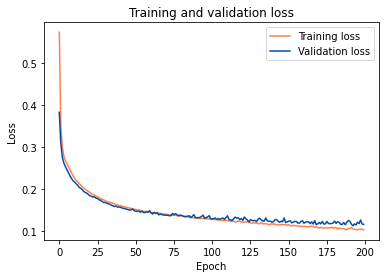

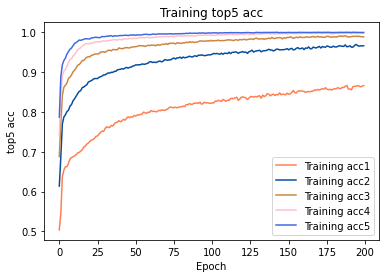

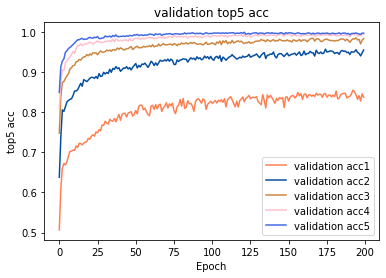

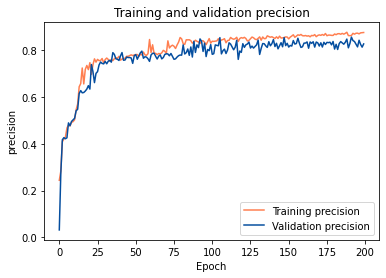

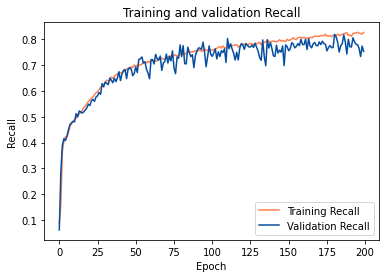

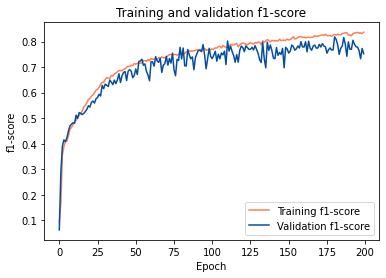

1636121229.24723


In [723]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)


### 2层CNN
        self.conv1 = nn.Conv1d(in_channels=7, out_channels=64, 
                 kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, 
                 kernel_size=3, stride=1, padding=2)

1636121334.3335629
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.4955 	 valid Loss: 0.3449
train acc1: 0.4731 	 valid acc1: 0.5318
train acc2: 0.5721 	 valid acc2: 0.6693
train acc3: 0.6470 	 valid acc3: 0.7589
train acc4: 0.7079 	 valid acc4: 0.8257
train acc5: 0.7626 	 valid acc5: 0.8664
train precision: 0.2138 	 valid precision: 0.0497
train recall: 0.0947 	 valid recall: 0.1250
train f1-score: 0.0960 	 valid f1-score: 0.0684
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.3257 	 valid Loss: 0.2924
train acc1: 0.6014 	 valid acc1: 0.6471
train acc2: 0.7108 	 valid acc2: 0.7775
train acc3: 0.7873 	 valid acc3: 0.8279
train acc4: 0.8364 	 valid acc4: 0.8714
train acc5: 0.8781 	 valid acc5: 0.9021
train precision: 0.3331 	 valid precision: 0.3976
train recall: 0.2830 	 valid recall: 0.3618
train f1-score: 0.2657 	 valid f1-score: 0.3292
-------第 3 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2839 	 valid Loss: 0.2589
train acc1: 0.6471 	 valid acc1: 0.6650
train acc2: 0.7781 	 valid acc2: 0.8171
train acc3: 0.8432 	 valid acc3: 0.8800
train acc4: 0.8830 	 valid acc4: 0.9179
train acc5: 0.9187 	 valid acc5: 0.9429
train precision: 0.4077 	 valid precision: 0.4103
train recall: 0.3877 	 valid recall: 0.4002
train f1-score: 0.3644 	 valid f1-score: 0.3763
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2637 	 valid Loss: 0.2434
train acc1: 0.6687 	 valid acc1: 0.7007
train acc2: 0.7982 	 valid acc2: 0.8232
train acc3: 0.8687 	 valid acc3: 0.8907
train acc4: 0.9085 	 valid acc4: 0.9218
train acc5: 0.9398 	 valid acc5: 0.9457
train precision: 0.4636 	 valid precision: 0.4880
train recall: 0.4355 	 valid recall: 0.4681
train f1-score: 0.4257 	 valid f1-score: 0.4631
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2496 	 valid Loss: 0.2327
train acc1: 0.6876 	 valid acc1: 0.7079
train acc2: 0.8062 	 valid acc2: 0.8261
train acc3: 0.8818 	 valid acc3: 0.8900
train acc4: 0.9225 	 valid acc4: 0.9275
train acc5: 0.9508 	 valid acc5: 0.9525
train precision: 0.4808 	 valid precision: 0.4796
train recall: 0.4758 	 valid recall: 0.4852
train f1-score: 0.4699 	 valid f1-score: 0.4756
-------第 6 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2377 	 valid Loss: 0.2208
train acc1: 0.6932 	 valid acc1: 0.7132
train acc2: 0.8186 	 valid acc2: 0.8393
train acc3: 0.8936 	 valid acc3: 0.9129
train acc4: 0.9349 	 valid acc4: 0.9446
train acc5: 0.9585 	 valid acc5: 0.9704
train precision: 0.4818 	 valid precision: 0.4865
train recall: 0.4898 	 valid recall: 0.4929
train f1-score: 0.4809 	 valid f1-score: 0.4844
-------第 7 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2262 	 valid Loss: 0.2125
train acc1: 0.6958 	 valid acc1: 0.7121
train acc2: 0.8364 	 valid acc2: 0.8557
train acc3: 0.9062 	 valid acc3: 0.9189
train acc4: 0.9427 	 valid acc4: 0.9507
train acc5: 0.9687 	 valid acc5: 0.9789
train precision: 0.4860 	 valid precision: 0.4870
train recall: 0.4959 	 valid recall: 0.4928
train f1-score: 0.4868 	 valid f1-score: 0.4846
-------第 8 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2166 	 valid Loss: 0.2071
train acc1: 0.6988 	 valid acc1: 0.7164
train acc2: 0.8505 	 valid acc2: 0.8593
train acc3: 0.9163 	 valid acc3: 0.9200
train acc4: 0.9543 	 valid acc4: 0.9593
train acc5: 0.9779 	 valid acc5: 0.9811
train precision: 0.5594 	 valid precision: 0.5164
train recall: 0.5045 	 valid recall: 0.5140
train f1-score: 0.4993 	 valid f1-score: 0.5024
-------第 9 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2101 	 valid Loss: 0.1963
train acc1: 0.7030 	 valid acc1: 0.7232
train acc2: 0.8487 	 valid acc2: 0.8707
train acc3: 0.9190 	 valid acc3: 0.9386
train acc4: 0.9575 	 valid acc4: 0.9668
train acc5: 0.9779 	 valid acc5: 0.9818
train precision: 0.5567 	 valid precision: 0.5731
train recall: 0.5177 	 valid recall: 0.5209
train f1-score: 0.5163 	 valid f1-score: 0.5270
-------第 10 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2026 	 valid Loss: 0.1930
train acc1: 0.7074 	 valid acc1: 0.7336
train acc2: 0.8655 	 valid acc2: 0.8807
train acc3: 0.9283 	 valid acc3: 0.9343
train acc4: 0.9608 	 valid acc4: 0.9614
train acc5: 0.9808 	 valid acc5: 0.9779
train precision: 0.6354 	 valid precision: 0.6535
train recall: 0.5279 	 valid recall: 0.5474
train f1-score: 0.5312 	 valid f1-score: 0.5582
-------第 11 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1963 	 valid Loss: 0.1871
train acc1: 0.7163 	 valid acc1: 0.7350
train acc2: 0.8667 	 valid acc2: 0.8832
train acc3: 0.9348 	 valid acc3: 0.9443
train acc4: 0.9650 	 valid acc4: 0.9707
train acc5: 0.9812 	 valid acc5: 0.9850
train precision: 0.6801 	 valid precision: 0.7176
train recall: 0.5451 	 valid recall: 0.5392
train f1-score: 0.5548 	 valid f1-score: 0.5397
-------第 12 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1923 	 valid Loss: 0.1815
train acc1: 0.7226 	 valid acc1: 0.7386
train acc2: 0.8708 	 valid acc2: 0.8807
train acc3: 0.9344 	 valid acc3: 0.9436
train acc4: 0.9655 	 valid acc4: 0.9643
train acc5: 0.9821 	 valid acc5: 0.9832
train precision: 0.7202 	 valid precision: 0.7205
train recall: 0.5579 	 valid recall: 0.5468
train f1-score: 0.5678 	 valid f1-score: 0.5608
-------第 13 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1846 	 valid Loss: 0.1738
train acc1: 0.7326 	 valid acc1: 0.7475
train acc2: 0.8795 	 valid acc2: 0.9029
train acc3: 0.9431 	 valid acc3: 0.9543
train acc4: 0.9718 	 valid acc4: 0.9736
train acc5: 0.9865 	 valid acc5: 0.9871
train precision: 0.7562 	 valid precision: 0.7101
train recall: 0.5777 	 valid recall: 0.5695
train f1-score: 0.5949 	 valid f1-score: 0.5865
-------第 14 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1804 	 valid Loss: 0.1689
train acc1: 0.7439 	 valid acc1: 0.7707
train acc2: 0.8860 	 valid acc2: 0.9011
train acc3: 0.9449 	 valid acc3: 0.9546
train acc4: 0.9730 	 valid acc4: 0.9761
train acc5: 0.9864 	 valid acc5: 0.9843
train precision: 0.7692 	 valid precision: 0.8066
train recall: 0.6010 	 valid recall: 0.6193
train f1-score: 0.6211 	 valid f1-score: 0.6423
-------第 15 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1748 	 valid Loss: 0.1633
train acc1: 0.7543 	 valid acc1: 0.7757
train acc2: 0.8926 	 valid acc2: 0.9100
train acc3: 0.9471 	 valid acc3: 0.9539
train acc4: 0.9761 	 valid acc4: 0.9739
train acc5: 0.9868 	 valid acc5: 0.9864
train precision: 0.7711 	 valid precision: 0.7211
train recall: 0.6235 	 valid recall: 0.6232
train f1-score: 0.6426 	 valid f1-score: 0.6392
-------第 16 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1717 	 valid Loss: 0.1639
train acc1: 0.7620 	 valid acc1: 0.7832
train acc2: 0.8937 	 valid acc2: 0.8975
train acc3: 0.9494 	 valid acc3: 0.9514
train acc4: 0.9762 	 valid acc4: 0.9754
train acc5: 0.9874 	 valid acc5: 0.9843
train precision: 0.7683 	 valid precision: 0.7678
train recall: 0.6415 	 valid recall: 0.6622
train f1-score: 0.6605 	 valid f1-score: 0.6780
-------第 17 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1678 	 valid Loss: 0.1565
train acc1: 0.7690 	 valid acc1: 0.7861
train acc2: 0.8990 	 valid acc2: 0.9132
train acc3: 0.9543 	 valid acc3: 0.9639
train acc4: 0.9786 	 valid acc4: 0.9818
train acc5: 0.9888 	 valid acc5: 0.9921
train precision: 0.7714 	 valid precision: 0.7777
train recall: 0.6574 	 valid recall: 0.6548
train f1-score: 0.6722 	 valid f1-score: 0.6744
-------第 18 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1632 	 valid Loss: 0.1555
train acc1: 0.7733 	 valid acc1: 0.8029
train acc2: 0.9058 	 valid acc2: 0.9129
train acc3: 0.9533 	 valid acc3: 0.9539
train acc4: 0.9785 	 valid acc4: 0.9771
train acc5: 0.9887 	 valid acc5: 0.9889
train precision: 0.7724 	 valid precision: 0.7397
train recall: 0.6659 	 valid recall: 0.6900
train f1-score: 0.6804 	 valid f1-score: 0.6999
-------第 19 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1606 	 valid Loss: 0.1516
train acc1: 0.7769 	 valid acc1: 0.8082
train acc2: 0.9031 	 valid acc2: 0.9139
train acc3: 0.9535 	 valid acc3: 0.9582
train acc4: 0.9777 	 valid acc4: 0.9800
train acc5: 0.9885 	 valid acc5: 0.9882
train precision: 0.7700 	 valid precision: 0.7672
train recall: 0.6764 	 valid recall: 0.7299
train f1-score: 0.6897 	 valid f1-score: 0.7293
-------第 20 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1587 	 valid Loss: 0.1493
train acc1: 0.7810 	 valid acc1: 0.7989
train acc2: 0.9057 	 valid acc2: 0.9182
train acc3: 0.9582 	 valid acc3: 0.9657
train acc4: 0.9802 	 valid acc4: 0.9825
train acc5: 0.9910 	 valid acc5: 0.9904
train precision: 0.7685 	 valid precision: 0.7808
train recall: 0.6823 	 valid recall: 0.6804
train f1-score: 0.6959 	 valid f1-score: 0.6932
-------第 21 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1540 	 valid Loss: 0.1448
train acc1: 0.7855 	 valid acc1: 0.8061
train acc2: 0.9090 	 valid acc2: 0.9214
train acc3: 0.9579 	 valid acc3: 0.9561
train acc4: 0.9821 	 valid acc4: 0.9829
train acc5: 0.9927 	 valid acc5: 0.9911
train precision: 0.7796 	 valid precision: 0.7925
train recall: 0.6916 	 valid recall: 0.7081
train f1-score: 0.7060 	 valid f1-score: 0.7148
-------第 22 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1510 	 valid Loss: 0.1453
train acc1: 0.7879 	 valid acc1: 0.8068
train acc2: 0.9140 	 valid acc2: 0.9189
train acc3: 0.9592 	 valid acc3: 0.9629
train acc4: 0.9813 	 valid acc4: 0.9800
train acc5: 0.9900 	 valid acc5: 0.9904
train precision: 0.7761 	 valid precision: 0.7935
train recall: 0.6974 	 valid recall: 0.7047
train f1-score: 0.7096 	 valid f1-score: 0.7283
-------第 23 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1502 	 valid Loss: 0.1421
train acc1: 0.7881 	 valid acc1: 0.8036
train acc2: 0.9148 	 valid acc2: 0.9214
train acc3: 0.9605 	 valid acc3: 0.9664
train acc4: 0.9845 	 valid acc4: 0.9882
train acc5: 0.9932 	 valid acc5: 0.9932
train precision: 0.7768 	 valid precision: 0.7792
train recall: 0.7001 	 valid recall: 0.7074
train f1-score: 0.7130 	 valid f1-score: 0.7160
-------第 24 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1482 	 valid Loss: 0.1437
train acc1: 0.7915 	 valid acc1: 0.8104
train acc2: 0.9180 	 valid acc2: 0.9196
train acc3: 0.9624 	 valid acc3: 0.9614
train acc4: 0.9836 	 valid acc4: 0.9800
train acc5: 0.9932 	 valid acc5: 0.9875
train precision: 0.7810 	 valid precision: 0.7791
train recall: 0.7092 	 valid recall: 0.7347
train f1-score: 0.7219 	 valid f1-score: 0.7324
-------第 25 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1467 	 valid Loss: 0.1410
train acc1: 0.7946 	 valid acc1: 0.8057
train acc2: 0.9171 	 valid acc2: 0.9125
train acc3: 0.9645 	 valid acc3: 0.9668
train acc4: 0.9844 	 valid acc4: 0.9821
train acc5: 0.9931 	 valid acc5: 0.9900
train precision: 0.7754 	 valid precision: 0.7801
train recall: 0.7111 	 valid recall: 0.7077
train f1-score: 0.7232 	 valid f1-score: 0.7210
-------第 26 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1444 	 valid Loss: 0.1377
train acc1: 0.7990 	 valid acc1: 0.8175
train acc2: 0.9226 	 valid acc2: 0.9254
train acc3: 0.9636 	 valid acc3: 0.9607
train acc4: 0.9845 	 valid acc4: 0.9854
train acc5: 0.9931 	 valid acc5: 0.9900
train precision: 0.7818 	 valid precision: 0.7883
train recall: 0.7225 	 valid recall: 0.7451
train f1-score: 0.7345 	 valid f1-score: 0.7508
-------第 27 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1426 	 valid Loss: 0.1325
train acc1: 0.8007 	 valid acc1: 0.8271
train acc2: 0.9193 	 valid acc2: 0.9282
train acc3: 0.9649 	 valid acc3: 0.9668
train acc4: 0.9869 	 valid acc4: 0.9871
train acc5: 0.9936 	 valid acc5: 0.9939
train precision: 0.7831 	 valid precision: 0.8043
train recall: 0.7265 	 valid recall: 0.7482
train f1-score: 0.7378 	 valid f1-score: 0.7562
-------第 28 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1416 	 valid Loss: 0.1431
train acc1: 0.8038 	 valid acc1: 0.7996
train acc2: 0.9267 	 valid acc2: 0.9211
train acc3: 0.9668 	 valid acc3: 0.9607
train acc4: 0.9869 	 valid acc4: 0.9843
train acc5: 0.9956 	 valid acc5: 0.9918
train precision: 0.7823 	 valid precision: 0.7673
train recall: 0.7303 	 valid recall: 0.7370
train f1-score: 0.7414 	 valid f1-score: 0.7179
-------第 29 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1396 	 valid Loss: 0.1323
train acc1: 0.8076 	 valid acc1: 0.8289
train acc2: 0.9236 	 valid acc2: 0.9264
train acc3: 0.9660 	 valid acc3: 0.9679
train acc4: 0.9875 	 valid acc4: 0.9857
train acc5: 0.9951 	 valid acc5: 0.9943
train precision: 0.8195 	 valid precision: 0.7973
train recall: 0.7399 	 valid recall: 0.7578
train f1-score: 0.7496 	 valid f1-score: 0.7668
-------第 30 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1381 	 valid Loss: 0.1314
train acc1: 0.8088 	 valid acc1: 0.8257
train acc2: 0.9295 	 valid acc2: 0.9293
train acc3: 0.9681 	 valid acc3: 0.9693
train acc4: 0.9886 	 valid acc4: 0.9864
train acc5: 0.9951 	 valid acc5: 0.9943
train precision: 0.7941 	 valid precision: 0.7855
train recall: 0.7460 	 valid recall: 0.7639
train f1-score: 0.7538 	 valid f1-score: 0.7651
-------第 31 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1360 	 valid Loss: 0.1342
train acc1: 0.8095 	 valid acc1: 0.8182
train acc2: 0.9285 	 valid acc2: 0.9211
train acc3: 0.9705 	 valid acc3: 0.9675
train acc4: 0.9887 	 valid acc4: 0.9857
train acc5: 0.9956 	 valid acc5: 0.9929
train precision: 0.8358 	 valid precision: 0.7716
train recall: 0.7426 	 valid recall: 0.7619
train f1-score: 0.7526 	 valid f1-score: 0.7598
-------第 32 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1340 	 valid Loss: 0.1311
train acc1: 0.8137 	 valid acc1: 0.8271
train acc2: 0.9305 	 valid acc2: 0.9275
train acc3: 0.9702 	 valid acc3: 0.9693
train acc4: 0.9893 	 valid acc4: 0.9861
train acc5: 0.9954 	 valid acc5: 0.9921
train precision: 0.8434 	 valid precision: 0.7898
train recall: 0.7511 	 valid recall: 0.7673
train f1-score: 0.7601 	 valid f1-score: 0.7707
-------第 33 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1325 	 valid Loss: 0.1293
train acc1: 0.8156 	 valid acc1: 0.8182
train acc2: 0.9320 	 valid acc2: 0.9354
train acc3: 0.9708 	 valid acc3: 0.9743
train acc4: 0.9906 	 valid acc4: 0.9904
train acc5: 0.9954 	 valid acc5: 0.9961
train precision: 0.8562 	 valid precision: 0.7947
train recall: 0.7546 	 valid recall: 0.7387
train f1-score: 0.7618 	 valid f1-score: 0.7410
-------第 34 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1318 	 valid Loss: 0.1263
train acc1: 0.8156 	 valid acc1: 0.8193
train acc2: 0.9320 	 valid acc2: 0.9404
train acc3: 0.9721 	 valid acc3: 0.9754
train acc4: 0.9904 	 valid acc4: 0.9893
train acc5: 0.9957 	 valid acc5: 0.9954
train precision: 0.8231 	 valid precision: 0.7985
train recall: 0.7577 	 valid recall: 0.7295
train f1-score: 0.7645 	 valid f1-score: 0.7465
-------第 35 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1310 	 valid Loss: 0.1255
train acc1: 0.8187 	 valid acc1: 0.8371
train acc2: 0.9323 	 valid acc2: 0.9254
train acc3: 0.9737 	 valid acc3: 0.9686
train acc4: 0.9894 	 valid acc4: 0.9861
train acc5: 0.9957 	 valid acc5: 0.9950
train precision: 0.8546 	 valid precision: 0.7952
train recall: 0.7599 	 valid recall: 0.7815
train f1-score: 0.7656 	 valid f1-score: 0.7791
-------第 36 轮训练开始-------
train Loss: 0.1293 	 valid Loss: 0.1278
train acc1: 0.8204 	 valid acc1: 0.8289
train acc2: 0.9365 	 valid acc2: 0.9368
train acc3: 0.9754 	 valid acc3: 0.9754
train acc4: 0.9911 	 valid acc4: 0.9907
train acc5: 0.9963 	 valid acc5: 0.9986
train precision: 0.8302 	 valid precision: 0.8109
train recall: 0.7653 	 valid recall: 0.7555
train f1-score: 0.7693 	 valid f1-score: 0.7676
-------第 37 轮训练开始-------
train Loss: 0.1281 	 valid Loss: 0.1276
train acc1: 0.8239 	 valid acc1: 0.8339
train acc2: 0.9373 	 valid acc2: 0.9325
train acc3: 0.9758 	 valid acc3: 0.9675
train acc4: 0.9915 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1214 	 valid Loss: 0.1182
train acc1: 0.8287 	 valid acc1: 0.8361
train acc2: 0.9461 	 valid acc2: 0.9446
train acc3: 0.9795 	 valid acc3: 0.9771
train acc4: 0.9943 	 valid acc4: 0.9932
train acc5: 0.9970 	 valid acc5: 0.9989
train precision: 0.8430 	 valid precision: 0.8083
train recall: 0.7837 	 valid recall: 0.7625
train f1-score: 0.7884 	 valid f1-score: 0.7766
-------第 44 轮训练开始-------
train Loss: 0.1201 	 valid Loss: 0.1178
train acc1: 0.8346 	 valid acc1: 0.8379
train acc2: 0.9471 	 valid acc2: 0.9446
train acc3: 0.9796 	 valid acc3: 0.9754
train acc4: 0.9937 	 valid acc4: 0.9911
train acc5: 0.9975 	 valid acc5: 0.9961
train precision: 0.8552 	 valid precision: 0.8484
train recall: 0.7908 	 valid recall: 0.7712
train f1-score: 0.7962 	 valid f1-score: 0.7914
-------第 45 轮训练开始-------
train Loss: 0.1200 	 valid Loss: 0.1169
train acc1: 0.8314 	 valid acc1: 0.8346
train acc2: 0.9482 	 valid acc2: 0.9443
train acc3: 0.9820 	 valid acc3: 0.9796
train acc4: 0.9949 	 valid

train Loss: 0.1035 	 valid Loss: 0.1073
train acc1: 0.8583 	 valid acc1: 0.8618
train acc2: 0.9657 	 valid acc2: 0.9664
train acc3: 0.9911 	 valid acc3: 0.9879
train acc4: 0.9976 	 valid acc4: 0.9946
train acc5: 0.9993 	 valid acc5: 0.9964
train precision: 0.8673 	 valid precision: 0.8513
train recall: 0.8286 	 valid recall: 0.8204
train f1-score: 0.8362 	 valid f1-score: 0.8193
-------第 65 轮训练开始-------
train Loss: 0.1032 	 valid Loss: 0.1053
train acc1: 0.8581 	 valid acc1: 0.8589
train acc2: 0.9646 	 valid acc2: 0.9671
train acc3: 0.9911 	 valid acc3: 0.9889
train acc4: 0.9965 	 valid acc4: 0.9954
train acc5: 0.9989 	 valid acc5: 0.9979
train precision: 0.8664 	 valid precision: 0.8424
train recall: 0.8294 	 valid recall: 0.8459
train f1-score: 0.8336 	 valid f1-score: 0.8294
-------第 66 轮训练开始-------
train Loss: 0.1034 	 valid Loss: 0.1021
train acc1: 0.8579 	 valid acc1: 0.8650
train acc2: 0.9662 	 valid acc2: 0.9646
train acc3: 0.9917 	 valid acc3: 0.9875
train acc4: 0.9979 	 valid

train Loss: 0.0923 	 valid Loss: 0.1039
train acc1: 0.8735 	 valid acc1: 0.8550
train acc2: 0.9768 	 valid acc2: 0.9657
train acc3: 0.9943 	 valid acc3: 0.9900
train acc4: 0.9985 	 valid acc4: 0.9939
train acc5: 0.9996 	 valid acc5: 0.9946
train precision: 0.8787 	 valid precision: 0.8393
train recall: 0.8512 	 valid recall: 0.8363
train f1-score: 0.8574 	 valid f1-score: 0.8219
-------第 86 轮训练开始-------
train Loss: 0.0936 	 valid Loss: 0.1023
train acc1: 0.8711 	 valid acc1: 0.8607
train acc2: 0.9755 	 valid acc2: 0.9664
train acc3: 0.9942 	 valid acc3: 0.9875
train acc4: 0.9986 	 valid acc4: 0.9943
train acc5: 0.9994 	 valid acc5: 0.9982
train precision: 0.8786 	 valid precision: 0.8529
train recall: 0.8495 	 valid recall: 0.8276
train f1-score: 0.8556 	 valid f1-score: 0.8310
-------第 87 轮训练开始-------
train Loss: 0.0907 	 valid Loss: 0.1008
train acc1: 0.8731 	 valid acc1: 0.8679
train acc2: 0.9780 	 valid acc2: 0.9661
train acc3: 0.9937 	 valid acc3: 0.9854
train acc4: 0.9988 	 valid

train Loss: 0.0843 	 valid Loss: 0.0963
train acc1: 0.8846 	 valid acc1: 0.8768
train acc2: 0.9820 	 valid acc2: 0.9732
train acc3: 0.9962 	 valid acc3: 0.9879
train acc4: 0.9992 	 valid acc4: 0.9939
train acc5: 0.9996 	 valid acc5: 0.9964
train precision: 0.8870 	 valid precision: 0.8600
train recall: 0.8689 	 valid recall: 0.8663
train f1-score: 0.8728 	 valid f1-score: 0.8548
-------第 107 轮训练开始-------
train Loss: 0.0840 	 valid Loss: 0.0958
train acc1: 0.8835 	 valid acc1: 0.8750
train acc2: 0.9832 	 valid acc2: 0.9736
train acc3: 0.9957 	 valid acc3: 0.9879
train acc4: 0.9988 	 valid acc4: 0.9918
train acc5: 0.9995 	 valid acc5: 0.9954
train precision: 0.8887 	 valid precision: 0.8598
train recall: 0.8660 	 valid recall: 0.8560
train f1-score: 0.8709 	 valid f1-score: 0.8484
-------第 108 轮训练开始-------
train Loss: 0.0824 	 valid Loss: 0.0961
train acc1: 0.8885 	 valid acc1: 0.8729
train acc2: 0.9826 	 valid acc2: 0.9729
train acc3: 0.9962 	 valid acc3: 0.9879
train acc4: 0.9992 	 val

train Loss: 0.0743 	 valid Loss: 0.0901
train acc1: 0.9029 	 valid acc1: 0.8807
train acc2: 0.9876 	 valid acc2: 0.9732
train acc3: 0.9973 	 valid acc3: 0.9900
train acc4: 0.9996 	 valid acc4: 0.9946
train acc5: 1.0000 	 valid acc5: 0.9964
train precision: 0.9076 	 valid precision: 0.8675
train recall: 0.8891 	 valid recall: 0.8531
train f1-score: 0.8937 	 valid f1-score: 0.8568
-------第 128 轮训练开始-------
train Loss: 0.0761 	 valid Loss: 0.0946
train acc1: 0.8993 	 valid acc1: 0.8693
train acc2: 0.9877 	 valid acc2: 0.9736
train acc3: 0.9974 	 valid acc3: 0.9904
train acc4: 0.9999 	 valid acc4: 0.9950
train acc5: 0.9999 	 valid acc5: 0.9961
train precision: 0.9032 	 valid precision: 0.8480
train recall: 0.8856 	 valid recall: 0.8602
train f1-score: 0.8893 	 valid f1-score: 0.8489
-------第 129 轮训练开始-------
train Loss: 0.0738 	 valid Loss: 0.0889
train acc1: 0.9010 	 valid acc1: 0.8871
train acc2: 0.9876 	 valid acc2: 0.9707
train acc3: 0.9986 	 valid acc3: 0.9918
train acc4: 0.9999 	 val

train Loss: 0.0672 	 valid Loss: 0.0859
train acc1: 0.9089 	 valid acc1: 0.8896
train acc2: 0.9913 	 valid acc2: 0.9725
train acc3: 0.9977 	 valid acc3: 0.9929
train acc4: 0.9998 	 valid acc4: 0.9961
train acc5: 1.0000 	 valid acc5: 0.9968
train precision: 0.9139 	 valid precision: 0.8809
train recall: 0.8966 	 valid recall: 0.8673
train f1-score: 0.9018 	 valid f1-score: 0.8680
-------第 149 轮训练开始-------
train Loss: 0.0680 	 valid Loss: 0.0858
train acc1: 0.9089 	 valid acc1: 0.8911
train acc2: 0.9906 	 valid acc2: 0.9764
train acc3: 0.9986 	 valid acc3: 0.9889
train acc4: 0.9998 	 valid acc4: 0.9921
train acc5: 0.9999 	 valid acc5: 0.9946
train precision: 0.9127 	 valid precision: 0.8785
train recall: 0.8980 	 valid recall: 0.8666
train f1-score: 0.9019 	 valid f1-score: 0.8665
-------第 150 轮训练开始-------
train Loss: 0.0678 	 valid Loss: 0.0907
train acc1: 0.9131 	 valid acc1: 0.8839
train acc2: 0.9907 	 valid acc2: 0.9707
train acc3: 0.9985 	 valid acc3: 0.9871
train acc4: 0.9998 	 val

train Loss: 0.0630 	 valid Loss: 0.0827
train acc1: 0.9179 	 valid acc1: 0.8943
train acc2: 0.9938 	 valid acc2: 0.9754
train acc3: 0.9988 	 valid acc3: 0.9893
train acc4: 0.9999 	 valid acc4: 0.9925
train acc5: 1.0000 	 valid acc5: 0.9939
train precision: 0.9231 	 valid precision: 0.8815
train recall: 0.9051 	 valid recall: 0.8700
train f1-score: 0.9108 	 valid f1-score: 0.8706
-------第 170 轮训练开始-------
train Loss: 0.0640 	 valid Loss: 0.0853
train acc1: 0.9137 	 valid acc1: 0.8932
train acc2: 0.9911 	 valid acc2: 0.9746
train acc3: 0.9987 	 valid acc3: 0.9879
train acc4: 1.0000 	 valid acc4: 0.9932
train acc5: 1.0000 	 valid acc5: 0.9950
train precision: 0.9195 	 valid precision: 0.8743
train recall: 0.9024 	 valid recall: 0.8832
train f1-score: 0.9078 	 valid f1-score: 0.8740
-------第 171 轮训练开始-------
train Loss: 0.0637 	 valid Loss: 0.0863
train acc1: 0.9138 	 valid acc1: 0.8879
train acc2: 0.9923 	 valid acc2: 0.9721
train acc3: 0.9988 	 valid acc3: 0.9875
train acc4: 1.0000 	 val

train Loss: 0.0585 	 valid Loss: 0.0874
train acc1: 0.9244 	 valid acc1: 0.8889
train acc2: 0.9937 	 valid acc2: 0.9714
train acc3: 0.9993 	 valid acc3: 0.9839
train acc4: 0.9998 	 valid acc4: 0.9911
train acc5: 1.0000 	 valid acc5: 0.9939
train precision: 0.9294 	 valid precision: 0.8610
train recall: 0.9120 	 valid recall: 0.8944
train f1-score: 0.9177 	 valid f1-score: 0.8725
-------第 191 轮训练开始-------
train Loss: 0.0583 	 valid Loss: 0.0825
train acc1: 0.9215 	 valid acc1: 0.8975
train acc2: 0.9943 	 valid acc2: 0.9754
train acc3: 0.9990 	 valid acc3: 0.9871
train acc4: 0.9998 	 valid acc4: 0.9914
train acc5: 0.9998 	 valid acc5: 0.9929
train precision: 0.9250 	 valid precision: 0.8898
train recall: 0.9125 	 valid recall: 0.8805
train f1-score: 0.9161 	 valid f1-score: 0.8836
-------第 192 轮训练开始-------
train Loss: 0.0575 	 valid Loss: 0.0871
train acc1: 0.9255 	 valid acc1: 0.8832
train acc2: 0.9945 	 valid acc2: 0.9725
train acc3: 0.9994 	 valid acc3: 0.9861
train acc4: 1.0000 	 val

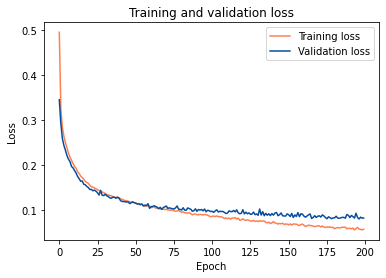

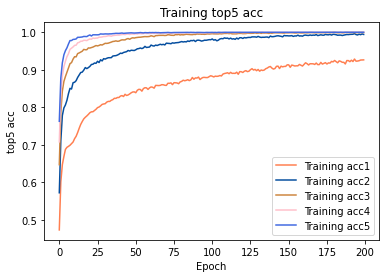

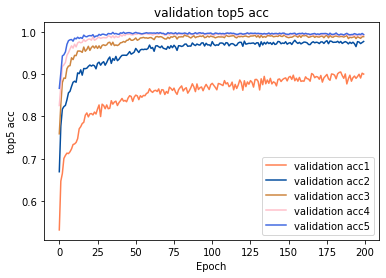

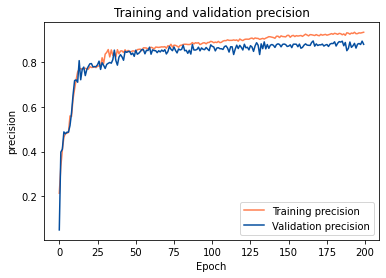

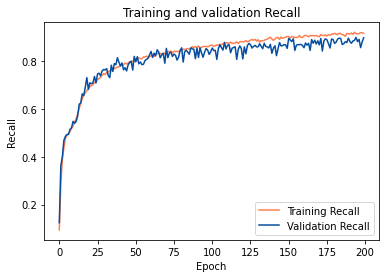

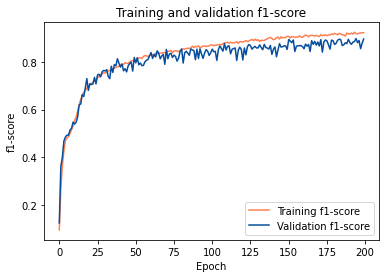

1636122328.5199192


In [743]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)


### 3层CNN 

1636122683.574594
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.4585 	 valid Loss: 0.3091
train acc1: 0.4752 	 valid acc1: 0.6261
train acc2: 0.6324 	 valid acc2: 0.7446
train acc3: 0.6974 	 valid acc3: 0.8250
train acc4: 0.7506 	 valid acc4: 0.8707
train acc5: 0.7894 	 valid acc5: 0.8929
train precision: 0.2927 	 valid precision: 0.2771
train recall: 0.1723 	 valid recall: 0.3184
train f1-score: 0.1778 	 valid f1-score: 0.2746
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2859 	 valid Loss: 0.2521
train acc1: 0.6482 	 valid acc1: 0.6789
train acc2: 0.7686 	 valid acc2: 0.8168
train acc3: 0.8335 	 valid acc3: 0.8818
train acc4: 0.8731 	 valid acc4: 0.9189
train acc5: 0.9064 	 valid acc5: 0.9393
train precision: 0.4035 	 valid precision: 0.4257
train recall: 0.3900 	 valid recall: 0.4294
train f1-score: 0.3734 	 valid f1-score: 0.4116
-------第 3 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2538 	 valid Loss: 0.2314
train acc1: 0.6740 	 valid acc1: 0.6889
train acc2: 0.8048 	 valid acc2: 0.8250
train acc3: 0.8821 	 valid acc3: 0.9079
train acc4: 0.9201 	 valid acc4: 0.9375
train acc5: 0.9498 	 valid acc5: 0.9593
train precision: 0.4622 	 valid precision: 0.4365
train recall: 0.4486 	 valid recall: 0.4503
train f1-score: 0.4376 	 valid f1-score: 0.4351
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2354 	 valid Loss: 0.2155
train acc1: 0.6889 	 valid acc1: 0.7214
train acc2: 0.8254 	 valid acc2: 0.8379
train acc3: 0.8995 	 valid acc3: 0.9114
train acc4: 0.9385 	 valid acc4: 0.9475
train acc5: 0.9612 	 valid acc5: 0.9718
train precision: 0.5247 	 valid precision: 0.5075
train recall: 0.4824 	 valid recall: 0.5161
train f1-score: 0.4750 	 valid f1-score: 0.5059
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2211 	 valid Loss: 0.2043
train acc1: 0.7042 	 valid acc1: 0.7200
train acc2: 0.8314 	 valid acc2: 0.8546
train acc3: 0.9063 	 valid acc3: 0.9229
train acc4: 0.9475 	 valid acc4: 0.9536
train acc5: 0.9738 	 valid acc5: 0.9768
train precision: 0.5371 	 valid precision: 0.5189
train recall: 0.5144 	 valid recall: 0.5090
train f1-score: 0.5117 	 valid f1-score: 0.5024
-------第 6 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2104 	 valid Loss: 0.1938
train acc1: 0.7085 	 valid acc1: 0.7314
train acc2: 0.8461 	 valid acc2: 0.8789
train acc3: 0.9180 	 valid acc3: 0.9339
train acc4: 0.9551 	 valid acc4: 0.9686
train acc5: 0.9775 	 valid acc5: 0.9821
train precision: 0.6056 	 valid precision: 0.5977
train recall: 0.5262 	 valid recall: 0.5375
train f1-score: 0.5209 	 valid f1-score: 0.5276
-------第 7 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2017 	 valid Loss: 0.1879
train acc1: 0.7132 	 valid acc1: 0.7339
train acc2: 0.8612 	 valid acc2: 0.8739
train acc3: 0.9240 	 valid acc3: 0.9404
train acc4: 0.9592 	 valid acc4: 0.9639
train acc5: 0.9793 	 valid acc5: 0.9811
train precision: 0.6492 	 valid precision: 0.5511
train recall: 0.5345 	 valid recall: 0.5374
train f1-score: 0.5305 	 valid f1-score: 0.5277
-------第 8 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1935 	 valid Loss: 0.1870
train acc1: 0.7176 	 valid acc1: 0.7275
train acc2: 0.8719 	 valid acc2: 0.8804
train acc3: 0.9357 	 valid acc3: 0.9411
train acc4: 0.9651 	 valid acc4: 0.9636
train acc5: 0.9815 	 valid acc5: 0.9804
train precision: 0.6979 	 valid precision: 0.6209
train recall: 0.5469 	 valid recall: 0.5189
train f1-score: 0.5444 	 valid f1-score: 0.5250
-------第 9 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1876 	 valid Loss: 0.1763
train acc1: 0.7280 	 valid acc1: 0.7468
train acc2: 0.8770 	 valid acc2: 0.8907
train acc3: 0.9405 	 valid acc3: 0.9514
train acc4: 0.9663 	 valid acc4: 0.9736
train acc5: 0.9833 	 valid acc5: 0.9861
train precision: 0.7039 	 valid precision: 0.7037
train recall: 0.5669 	 valid recall: 0.5841
train f1-score: 0.5728 	 valid f1-score: 0.5823
-------第 10 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1794 	 valid Loss: 0.1704
train acc1: 0.7424 	 valid acc1: 0.7596
train acc2: 0.8837 	 valid acc2: 0.9079
train acc3: 0.9439 	 valid acc3: 0.9511
train acc4: 0.9699 	 valid acc4: 0.9700
train acc5: 0.9851 	 valid acc5: 0.9857
train precision: 0.7590 	 valid precision: 0.7738
train recall: 0.5963 	 valid recall: 0.5978
train f1-score: 0.6121 	 valid f1-score: 0.6143
-------第 11 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1739 	 valid Loss: 0.1605
train acc1: 0.7512 	 valid acc1: 0.7693
train acc2: 0.8914 	 valid acc2: 0.9064
train acc3: 0.9482 	 valid acc3: 0.9625
train acc4: 0.9732 	 valid acc4: 0.9811
train acc5: 0.9880 	 valid acc5: 0.9889
train precision: 0.7573 	 valid precision: 0.7849
train recall: 0.6136 	 valid recall: 0.6085
train f1-score: 0.6310 	 valid f1-score: 0.6319
-------第 12 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1731 	 valid Loss: 0.1627
train acc1: 0.7555 	 valid acc1: 0.7793
train acc2: 0.8943 	 valid acc2: 0.9107
train acc3: 0.9463 	 valid acc3: 0.9521
train acc4: 0.9743 	 valid acc4: 0.9721
train acc5: 0.9868 	 valid acc5: 0.9886
train precision: 0.7420 	 valid precision: 0.7329
train recall: 0.6304 	 valid recall: 0.6654
train f1-score: 0.6470 	 valid f1-score: 0.6726
-------第 13 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1642 	 valid Loss: 0.1541
train acc1: 0.7718 	 valid acc1: 0.7811
train acc2: 0.9015 	 valid acc2: 0.9161
train acc3: 0.9538 	 valid acc3: 0.9593
train acc4: 0.9789 	 valid acc4: 0.9779
train acc5: 0.9905 	 valid acc5: 0.9900
train precision: 0.7567 	 valid precision: 0.8094
train recall: 0.6670 	 valid recall: 0.6324
train f1-score: 0.6810 	 valid f1-score: 0.6570
-------第 14 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1644 	 valid Loss: 0.1518
train acc1: 0.7658 	 valid acc1: 0.7679
train acc2: 0.9038 	 valid acc2: 0.9171
train acc3: 0.9555 	 valid acc3: 0.9604
train acc4: 0.9781 	 valid acc4: 0.9825
train acc5: 0.9896 	 valid acc5: 0.9932
train precision: 0.7441 	 valid precision: 0.7555
train recall: 0.6589 	 valid recall: 0.6158
train f1-score: 0.6722 	 valid f1-score: 0.6348
-------第 15 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1578 	 valid Loss: 0.1476
train acc1: 0.7817 	 valid acc1: 0.8046
train acc2: 0.9062 	 valid acc2: 0.9239
train acc3: 0.9563 	 valid acc3: 0.9643
train acc4: 0.9795 	 valid acc4: 0.9821
train acc5: 0.9900 	 valid acc5: 0.9925
train precision: 0.8234 	 valid precision: 0.7792
train recall: 0.6836 	 valid recall: 0.7104
train f1-score: 0.6995 	 valid f1-score: 0.7281
-------第 16 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1549 	 valid Loss: 0.1434
train acc1: 0.7860 	 valid acc1: 0.8011
train acc2: 0.9088 	 valid acc2: 0.9218
train acc3: 0.9576 	 valid acc3: 0.9639
train acc4: 0.9794 	 valid acc4: 0.9825
train acc5: 0.9902 	 valid acc5: 0.9954
train precision: 0.7615 	 valid precision: 0.7665
train recall: 0.6978 	 valid recall: 0.7066
train f1-score: 0.7097 	 valid f1-score: 0.7160
-------第 17 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1519 	 valid Loss: 0.1458
train acc1: 0.7848 	 valid acc1: 0.8111
train acc2: 0.9131 	 valid acc2: 0.9175
train acc3: 0.9623 	 valid acc3: 0.9614
train acc4: 0.9829 	 valid acc4: 0.9804
train acc5: 0.9921 	 valid acc5: 0.9911
train precision: 0.7594 	 valid precision: 0.8025
train recall: 0.7033 	 valid recall: 0.7351
train f1-score: 0.7157 	 valid f1-score: 0.7505
-------第 18 轮训练开始-------
train Loss: 0.1507 	 valid Loss: 0.1417
train acc1: 0.7921 	 valid acc1: 0.8114
train acc2: 0.9124 	 valid acc2: 0.9229
train acc3: 0.9606 	 valid acc3: 0.9671
train acc4: 0.9814 	 valid acc4: 0.9861
train acc5: 0.9912 	 valid acc5: 0.9936
train precision: 0.7843 	 valid precision: 0.8007
train recall: 0.7112 	 valid recall: 0.7380
train f1-score: 0.7234 	 valid f1-score: 0.7500
-------第 19 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1499 	 valid Loss: 0.1497
train acc1: 0.7888 	 valid acc1: 0.7925
train acc2: 0.9151 	 valid acc2: 0.9014
train acc3: 0.9601 	 valid acc3: 0.9500
train acc4: 0.9817 	 valid acc4: 0.9757
train acc5: 0.9923 	 valid acc5: 0.9861
train precision: 0.7853 	 valid precision: 0.7304
train recall: 0.7108 	 valid recall: 0.6657
train f1-score: 0.7217 	 valid f1-score: 0.6687
-------第 20 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1468 	 valid Loss: 0.1358
train acc1: 0.7960 	 valid acc1: 0.8050
train acc2: 0.9186 	 valid acc2: 0.9264
train acc3: 0.9611 	 valid acc3: 0.9671
train acc4: 0.9831 	 valid acc4: 0.9879
train acc5: 0.9930 	 valid acc5: 0.9946
train precision: 0.8053 	 valid precision: 0.7826
train recall: 0.7208 	 valid recall: 0.6999
train f1-score: 0.7327 	 valid f1-score: 0.7190
-------第 21 轮训练开始-------
train Loss: 0.1414 	 valid Loss: 0.1345
train acc1: 0.8006 	 valid acc1: 0.8171
train acc2: 0.9223 	 valid acc2: 0.9279
train acc3: 0.9656 	 valid acc3: 0.9664
train acc4: 0.9864 	 valid acc4: 0.9857
train acc5: 0.9943 	 valid acc5: 0.9939
train precision: 0.8024 	 valid precision: 0.8407
train recall: 0.7308 	 valid recall: 0.7252
train f1-score: 0.7391 	 valid f1-score: 0.7415
-------第 22 轮训练开始-------
train Loss: 0.1399 	 valid Loss: 0.1336
train acc1: 0.8051 	 valid acc1: 0.8246
train acc2: 0.9248 	 valid acc2: 0.9282
train acc3: 0.9689 	 valid acc3: 0.9646
train acc4: 0.9883 	 valid

train Loss: 0.1149 	 valid Loss: 0.1087
train acc1: 0.8423 	 valid acc1: 0.8504
train acc2: 0.9537 	 valid acc2: 0.9543
train acc3: 0.9840 	 valid acc3: 0.9879
train acc4: 0.9949 	 valid acc4: 0.9954
train acc5: 0.9982 	 valid acc5: 0.9975
train precision: 0.8477 	 valid precision: 0.8395
train recall: 0.8003 	 valid recall: 0.8022
train f1-score: 0.8107 	 valid f1-score: 0.8024
-------第 42 轮训练开始-------
train Loss: 0.1155 	 valid Loss: 0.1168
train acc1: 0.8387 	 valid acc1: 0.8407
train acc2: 0.9533 	 valid acc2: 0.9532
train acc3: 0.9830 	 valid acc3: 0.9814
train acc4: 0.9952 	 valid acc4: 0.9950
train acc5: 0.9988 	 valid acc5: 0.9982
train precision: 0.8440 	 valid precision: 0.8259
train recall: 0.8015 	 valid recall: 0.8202
train f1-score: 0.8092 	 valid f1-score: 0.8075
-------第 43 轮训练开始-------
train Loss: 0.1097 	 valid Loss: 0.1123
train acc1: 0.8476 	 valid acc1: 0.8446
train acc2: 0.9589 	 valid acc2: 0.9571
train acc3: 0.9875 	 valid acc3: 0.9811
train acc4: 0.9960 	 valid

train Loss: 0.0947 	 valid Loss: 0.0957
train acc1: 0.8646 	 valid acc1: 0.8757
train acc2: 0.9708 	 valid acc2: 0.9654
train acc3: 0.9930 	 valid acc3: 0.9914
train acc4: 0.9982 	 valid acc4: 0.9968
train acc5: 0.9995 	 valid acc5: 0.9982
train precision: 0.8679 	 valid precision: 0.8609
train recall: 0.8396 	 valid recall: 0.8659
train f1-score: 0.8472 	 valid f1-score: 0.8509
-------第 63 轮训练开始-------
train Loss: 0.0895 	 valid Loss: 0.0956
train acc1: 0.8777 	 valid acc1: 0.8704
train acc2: 0.9744 	 valid acc2: 0.9729
train acc3: 0.9931 	 valid acc3: 0.9893
train acc4: 0.9986 	 valid acc4: 0.9954
train acc5: 0.9999 	 valid acc5: 0.9982
train precision: 0.8837 	 valid precision: 0.8616
train recall: 0.8586 	 valid recall: 0.8422
train f1-score: 0.8637 	 valid f1-score: 0.8407
-------第 64 轮训练开始-------
train Loss: 0.0891 	 valid Loss: 0.0975
train acc1: 0.8775 	 valid acc1: 0.8711
train acc2: 0.9765 	 valid acc2: 0.9729
train acc3: 0.9930 	 valid acc3: 0.9907
train acc4: 0.9982 	 valid

train Loss: 0.0787 	 valid Loss: 0.0913
train acc1: 0.8905 	 valid acc1: 0.8775
train acc2: 0.9860 	 valid acc2: 0.9714
train acc3: 0.9968 	 valid acc3: 0.9882
train acc4: 0.9994 	 valid acc4: 0.9961
train acc5: 1.0000 	 valid acc5: 0.9979
train precision: 0.8948 	 valid precision: 0.8534
train recall: 0.8723 	 valid recall: 0.8703
train f1-score: 0.8783 	 valid f1-score: 0.8581
-------第 84 轮训练开始-------
train Loss: 0.0769 	 valid Loss: 0.0885
train acc1: 0.8968 	 valid acc1: 0.8836
train acc2: 0.9852 	 valid acc2: 0.9700
train acc3: 0.9968 	 valid acc3: 0.9911
train acc4: 0.9998 	 valid acc4: 0.9950
train acc5: 0.9999 	 valid acc5: 0.9964
train precision: 0.9033 	 valid precision: 0.8773
train recall: 0.8783 	 valid recall: 0.8591
train f1-score: 0.8857 	 valid f1-score: 0.8586
-------第 85 轮训练开始-------
train Loss: 0.0804 	 valid Loss: 0.0894
train acc1: 0.8876 	 valid acc1: 0.8793
train acc2: 0.9833 	 valid acc2: 0.9729
train acc3: 0.9969 	 valid acc3: 0.9889
train acc4: 0.9990 	 valid

train Loss: 0.0676 	 valid Loss: 0.0910
train acc1: 0.9088 	 valid acc1: 0.8757
train acc2: 0.9908 	 valid acc2: 0.9750
train acc3: 0.9980 	 valid acc3: 0.9893
train acc4: 0.9990 	 valid acc4: 0.9957
train acc5: 0.9995 	 valid acc5: 0.9971
train precision: 0.9143 	 valid precision: 0.8721
train recall: 0.8923 	 valid recall: 0.8129
train f1-score: 0.8985 	 valid f1-score: 0.8331
-------第 105 轮训练开始-------
train Loss: 0.0641 	 valid Loss: 0.0937
train acc1: 0.9131 	 valid acc1: 0.8729
train acc2: 0.9901 	 valid acc2: 0.9696
train acc3: 0.9981 	 valid acc3: 0.9857
train acc4: 0.9995 	 valid acc4: 0.9943
train acc5: 0.9998 	 valid acc5: 0.9971
train precision: 0.9196 	 valid precision: 0.8573
train recall: 0.8978 	 valid recall: 0.8393
train f1-score: 0.9047 	 valid f1-score: 0.8404
-------第 106 轮训练开始-------
train Loss: 0.0670 	 valid Loss: 0.0800
train acc1: 0.9106 	 valid acc1: 0.9000
train acc2: 0.9896 	 valid acc2: 0.9750
train acc3: 0.9981 	 valid acc3: 0.9911
train acc4: 0.9993 	 val

train Loss: 0.0568 	 valid Loss: 0.0758
train acc1: 0.9242 	 valid acc1: 0.9075
train acc2: 0.9938 	 valid acc2: 0.9757
train acc3: 0.9992 	 valid acc3: 0.9882
train acc4: 0.9999 	 valid acc4: 0.9925
train acc5: 0.9999 	 valid acc5: 0.9968
train precision: 0.9275 	 valid precision: 0.8973
train recall: 0.9105 	 valid recall: 0.8908
train f1-score: 0.9162 	 valid f1-score: 0.8865
-------第 126 轮训练开始-------
train Loss: 0.0583 	 valid Loss: 0.0775
train acc1: 0.9213 	 valid acc1: 0.9039
train acc2: 0.9926 	 valid acc2: 0.9764
train acc3: 0.9983 	 valid acc3: 0.9889
train acc4: 0.9994 	 valid acc4: 0.9939
train acc5: 0.9996 	 valid acc5: 0.9950
train precision: 0.9261 	 valid precision: 0.8938
train recall: 0.9072 	 valid recall: 0.8828
train f1-score: 0.9138 	 valid f1-score: 0.8814
-------第 127 轮训练开始-------
train Loss: 0.0574 	 valid Loss: 0.0876
train acc1: 0.9215 	 valid acc1: 0.8946
train acc2: 0.9929 	 valid acc2: 0.9711
train acc3: 0.9989 	 valid acc3: 0.9864
train acc4: 0.9998 	 val

train Loss: 0.0521 	 valid Loss: 0.0797
train acc1: 0.9300 	 valid acc1: 0.8979
train acc2: 0.9960 	 valid acc2: 0.9789
train acc3: 0.9998 	 valid acc3: 0.9896
train acc4: 0.9999 	 valid acc4: 0.9921
train acc5: 1.0000 	 valid acc5: 0.9936
train precision: 0.9358 	 valid precision: 0.8780
train recall: 0.9182 	 valid recall: 0.8802
train f1-score: 0.9245 	 valid f1-score: 0.8772
-------第 147 轮训练开始-------
train Loss: 0.0541 	 valid Loss: 0.0911
train acc1: 0.9265 	 valid acc1: 0.8789
train acc2: 0.9945 	 valid acc2: 0.9700
train acc3: 0.9993 	 valid acc3: 0.9832
train acc4: 0.9995 	 valid acc4: 0.9882
train acc5: 0.9999 	 valid acc5: 0.9939
train precision: 0.9320 	 valid precision: 0.8704
train recall: 0.9148 	 valid recall: 0.8385
train f1-score: 0.9212 	 valid f1-score: 0.8462
-------第 148 轮训练开始-------
train Loss: 0.0551 	 valid Loss: 0.0840
train acc1: 0.9252 	 valid acc1: 0.9021
train acc2: 0.9927 	 valid acc2: 0.9707
train acc3: 0.9983 	 valid acc3: 0.9857
train acc4: 0.9996 	 val

train Loss: 0.0508 	 valid Loss: 0.0788
train acc1: 0.9335 	 valid acc1: 0.9050
train acc2: 0.9945 	 valid acc2: 0.9746
train acc3: 0.9994 	 valid acc3: 0.9889
train acc4: 1.0000 	 valid acc4: 0.9946
train acc5: 1.0000 	 valid acc5: 0.9954
train precision: 0.9383 	 valid precision: 0.8881
train recall: 0.9205 	 valid recall: 0.8925
train f1-score: 0.9273 	 valid f1-score: 0.8852
-------第 168 轮训练开始-------
train Loss: 0.0478 	 valid Loss: 0.0840
train acc1: 0.9385 	 valid acc1: 0.8989
train acc2: 0.9960 	 valid acc2: 0.9732
train acc3: 0.9998 	 valid acc3: 0.9861
train acc4: 0.9999 	 valid acc4: 0.9921
train acc5: 1.0000 	 valid acc5: 0.9943
train precision: 0.9421 	 valid precision: 0.8877
train recall: 0.9294 	 valid recall: 0.8709
train f1-score: 0.9339 	 valid f1-score: 0.8764
-------第 169 轮训练开始-------
train Loss: 0.0474 	 valid Loss: 0.0803
train acc1: 0.9387 	 valid acc1: 0.9064
train acc2: 0.9958 	 valid acc2: 0.9757
train acc3: 0.9993 	 valid acc3: 0.9868
train acc4: 0.9999 	 val

train Loss: 0.0429 	 valid Loss: 0.0802
train acc1: 0.9438 	 valid acc1: 0.9025
train acc2: 0.9977 	 valid acc2: 0.9721
train acc3: 1.0000 	 valid acc3: 0.9854
train acc4: 1.0000 	 valid acc4: 0.9886
train acc5: 1.0000 	 valid acc5: 0.9911
train precision: 0.9473 	 valid precision: 0.8770
train recall: 0.9360 	 valid recall: 0.8954
train f1-score: 0.9403 	 valid f1-score: 0.8835
-------第 189 轮训练开始-------
train Loss: 0.0417 	 valid Loss: 0.0736
train acc1: 0.9435 	 valid acc1: 0.9129
train acc2: 0.9965 	 valid acc2: 0.9750
train acc3: 0.9998 	 valid acc3: 0.9846
train acc4: 1.0000 	 valid acc4: 0.9889
train acc5: 1.0000 	 valid acc5: 0.9914
train precision: 0.9444 	 valid precision: 0.8949
train recall: 0.9347 	 valid recall: 0.9014
train f1-score: 0.9383 	 valid f1-score: 0.8957
-------第 190 轮训练开始-------
train Loss: 0.0414 	 valid Loss: 0.0784
train acc1: 0.9467 	 valid acc1: 0.9039
train acc2: 0.9971 	 valid acc2: 0.9764
train acc3: 0.9998 	 valid acc3: 0.9839
train acc4: 0.9999 	 val

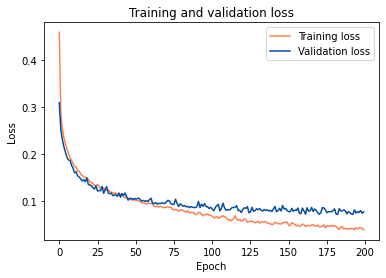

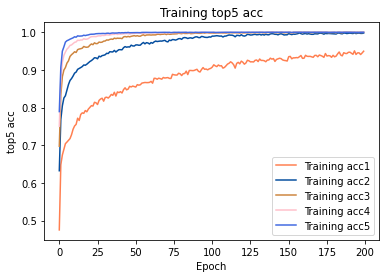

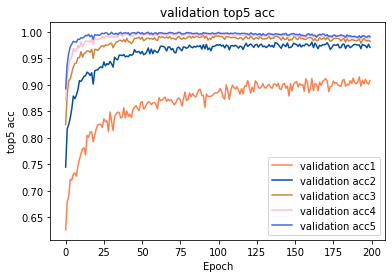

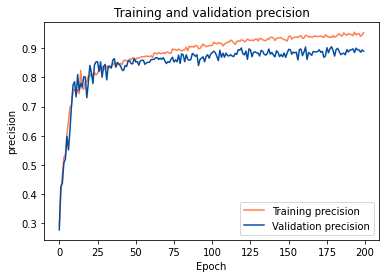

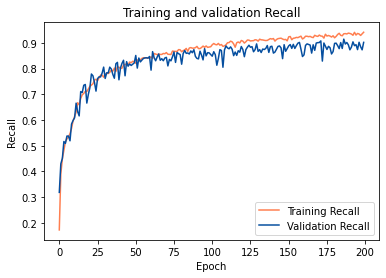

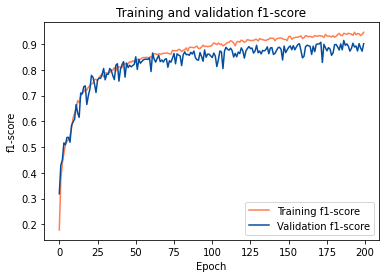

1636124087.7821481


In [763]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)


### 4层CNN 

1636116347.1922472
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1638 	 valid Loss: 0.1537
train acc1: 0.7677 	 valid acc1: 0.7886
train acc2: 0.9006 	 valid acc2: 0.9129
train acc3: 0.9526 	 valid acc3: 0.9639
train acc4: 0.9787 	 valid acc4: 0.9843
train acc5: 0.9915 	 valid acc5: 0.9907
train precision: 0.7433 	 valid precision: 0.7485
train recall: 0.6586 	 valid recall: 0.6960
train f1-score: 0.6751 	 valid f1-score: 0.7097
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1594 	 valid Loss: 0.1486
train acc1: 0.7733 	 valid acc1: 0.7904
train acc2: 0.9077 	 valid acc2: 0.9200
train acc3: 0.9589 	 valid acc3: 0.9636
train acc4: 0.9824 	 valid acc4: 0.9811
train acc5: 0.9920 	 valid acc5: 0.9907
train precision: 0.7460 	 valid precision: 0.7731
train recall: 0.6777 	 valid recall: 0.6892
train f1-score: 0.6910 	 valid f1-score: 0.7018
-------第 3 轮训练开始-------
train Loss: 0.1529 	 valid Loss: 0.1498
train acc1: 0.7826 	 valid acc1: 0.8082
train acc2: 0.9138 	 valid acc2: 0.9196
train acc3: 0.9627 	 valid acc3: 0.9639
train acc4: 0.9832 	 valid acc4: 0.9804
train acc5: 0.9925 	 valid acc5: 0.9879
train precision: 0.7853 	 valid precision: 0.7663
train recall: 0.6945 	 valid recall: 0.7324
train f1-score: 0.7077 	 valid f1-score: 0.7353
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1521 	 valid Loss: 0.1464
train acc1: 0.7858 	 valid acc1: 0.7982
train acc2: 0.9149 	 valid acc2: 0.9104
train acc3: 0.9631 	 valid acc3: 0.9614
train acc4: 0.9831 	 valid acc4: 0.9811
train acc5: 0.9918 	 valid acc5: 0.9936
train precision: 0.7851 	 valid precision: 0.7523
train recall: 0.7050 	 valid recall: 0.7492
train f1-score: 0.7154 	 valid f1-score: 0.7345
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1477 	 valid Loss: 0.1324
train acc1: 0.7875 	 valid acc1: 0.8125
train acc2: 0.9248 	 valid acc2: 0.9304
train acc3: 0.9660 	 valid acc3: 0.9750
train acc4: 0.9846 	 valid acc4: 0.9896
train acc5: 0.9933 	 valid acc5: 0.9946
train precision: 0.7982 	 valid precision: 0.7923
train recall: 0.7102 	 valid recall: 0.7322
train f1-score: 0.7218 	 valid f1-score: 0.7373
-------第 6 轮训练开始-------
train Loss: 0.1397 	 valid Loss: 0.1272
train acc1: 0.8061 	 valid acc1: 0.8096
train acc2: 0.9293 	 valid acc2: 0.9393
train acc3: 0.9719 	 valid acc3: 0.9814
train acc4: 0.9885 	 valid acc4: 0.9929
train acc5: 0.9949 	 valid acc5: 0.9971
train precision: 0.8191 	 valid precision: 0.8564
train recall: 0.7420 	 valid recall: 0.6953
train f1-score: 0.7505 	 valid f1-score: 0.7109
-------第 7 轮训练开始-------
train Loss: 0.1398 	 valid Loss: 0.1312
train acc1: 0.8032 	 valid acc1: 0.8100
train acc2: 0.9280 	 valid acc2: 0.9389
train acc3: 0.9693 	 valid acc3: 0.9729
train acc4: 0.9874 	 valid a

train Loss: 0.1097 	 valid Loss: 0.1120
train acc1: 0.8436 	 valid acc1: 0.8511
train acc2: 0.9605 	 valid acc2: 0.9557
train acc3: 0.9883 	 valid acc3: 0.9861
train acc4: 0.9964 	 valid acc4: 0.9961
train acc5: 0.9982 	 valid acc5: 0.9986
train precision: 0.8477 	 valid precision: 0.8381
train recall: 0.8122 	 valid recall: 0.8223
train f1-score: 0.8192 	 valid f1-score: 0.8236
-------第 27 轮训练开始-------
train Loss: 0.1066 	 valid Loss: 0.1079
train acc1: 0.8496 	 valid acc1: 0.8482
train acc2: 0.9629 	 valid acc2: 0.9661
train acc3: 0.9879 	 valid acc3: 0.9871
train acc4: 0.9962 	 valid acc4: 0.9961
train acc5: 0.9982 	 valid acc5: 0.9982
train precision: 0.8554 	 valid precision: 0.8324
train recall: 0.8181 	 valid recall: 0.8022
train f1-score: 0.8264 	 valid f1-score: 0.8003
-------第 28 轮训练开始-------
train Loss: 0.1052 	 valid Loss: 0.1046
train acc1: 0.8517 	 valid acc1: 0.8618
train acc2: 0.9627 	 valid acc2: 0.9604
train acc3: 0.9896 	 valid acc3: 0.9879
train acc4: 0.9958 	 valid

train Loss: 0.0854 	 valid Loss: 0.0982
train acc1: 0.8813 	 valid acc1: 0.8589
train acc2: 0.9789 	 valid acc2: 0.9718
train acc3: 0.9948 	 valid acc3: 0.9896
train acc4: 0.9986 	 valid acc4: 0.9946
train acc5: 0.9994 	 valid acc5: 0.9979
train precision: 0.8824 	 valid precision: 0.8545
train recall: 0.8638 	 valid recall: 0.8116
train f1-score: 0.8681 	 valid f1-score: 0.8240
-------第 48 轮训练开始-------
train Loss: 0.0843 	 valid Loss: 0.1048
train acc1: 0.8852 	 valid acc1: 0.8636
train acc2: 0.9786 	 valid acc2: 0.9618
train acc3: 0.9946 	 valid acc3: 0.9864
train acc4: 0.9985 	 valid acc4: 0.9954
train acc5: 0.9992 	 valid acc5: 0.9975
train precision: 0.8857 	 valid precision: 0.8338
train recall: 0.8681 	 valid recall: 0.8631
train f1-score: 0.8718 	 valid f1-score: 0.8391
-------第 49 轮训练开始-------
train Loss: 0.0824 	 valid Loss: 0.0927
train acc1: 0.8868 	 valid acc1: 0.8754
train acc2: 0.9818 	 valid acc2: 0.9704
train acc3: 0.9958 	 valid acc3: 0.9907
train acc4: 0.9990 	 valid

train Loss: 0.0680 	 valid Loss: 0.0860
train acc1: 0.9089 	 valid acc1: 0.8786
train acc2: 0.9889 	 valid acc2: 0.9757
train acc3: 0.9977 	 valid acc3: 0.9896
train acc4: 0.9995 	 valid acc4: 0.9932
train acc5: 1.0000 	 valid acc5: 0.9964
train precision: 0.9068 	 valid precision: 0.8777
train recall: 0.8932 	 valid recall: 0.8242
train f1-score: 0.8973 	 valid f1-score: 0.8412
-------第 69 轮训练开始-------
train Loss: 0.0637 	 valid Loss: 0.0824
train acc1: 0.9174 	 valid acc1: 0.8954
train acc2: 0.9913 	 valid acc2: 0.9754
train acc3: 0.9980 	 valid acc3: 0.9904
train acc4: 0.9995 	 valid acc4: 0.9929
train acc5: 1.0000 	 valid acc5: 0.9961
train precision: 0.9192 	 valid precision: 0.8765
train recall: 0.9034 	 valid recall: 0.8771
train f1-score: 0.9084 	 valid f1-score: 0.8726
-------第 70 轮训练开始-------
train Loss: 0.0655 	 valid Loss: 0.0954
train acc1: 0.9113 	 valid acc1: 0.8775
train acc2: 0.9893 	 valid acc2: 0.9671
train acc3: 0.9986 	 valid acc3: 0.9879
train acc4: 0.9996 	 valid

train Loss: 0.0547 	 valid Loss: 0.0821
train acc1: 0.9281 	 valid acc1: 0.8982
train acc2: 0.9938 	 valid acc2: 0.9761
train acc3: 0.9994 	 valid acc3: 0.9875
train acc4: 1.0000 	 valid acc4: 0.9925
train acc5: 1.0000 	 valid acc5: 0.9968
train precision: 0.9274 	 valid precision: 0.8813
train recall: 0.9166 	 valid recall: 0.8743
train f1-score: 0.9198 	 valid f1-score: 0.8741
-------第 90 轮训练开始-------
train Loss: 0.0570 	 valid Loss: 0.0853
train acc1: 0.9239 	 valid acc1: 0.8975
train acc2: 0.9930 	 valid acc2: 0.9721
train acc3: 0.9981 	 valid acc3: 0.9850
train acc4: 0.9995 	 valid acc4: 0.9904
train acc5: 0.9996 	 valid acc5: 0.9921
train precision: 0.9229 	 valid precision: 0.8769
train recall: 0.9128 	 valid recall: 0.8873
train f1-score: 0.9158 	 valid f1-score: 0.8774
-------第 91 轮训练开始-------
train Loss: 0.0560 	 valid Loss: 0.0824
train acc1: 0.9276 	 valid acc1: 0.8929
train acc2: 0.9912 	 valid acc2: 0.9771
train acc3: 0.9981 	 valid acc3: 0.9875
train acc4: 0.9998 	 valid

train Loss: 0.0466 	 valid Loss: 0.0784
train acc1: 0.9404 	 valid acc1: 0.9036
train acc2: 0.9954 	 valid acc2: 0.9743
train acc3: 0.9994 	 valid acc3: 0.9864
train acc4: 0.9995 	 valid acc4: 0.9904
train acc5: 1.0000 	 valid acc5: 0.9929
train precision: 0.9373 	 valid precision: 0.8831
train recall: 0.9331 	 valid recall: 0.8921
train f1-score: 0.9340 	 valid f1-score: 0.8857
-------第 111 轮训练开始-------
train Loss: 0.0518 	 valid Loss: 0.0891
train acc1: 0.9346 	 valid acc1: 0.8925
train acc2: 0.9920 	 valid acc2: 0.9679
train acc3: 0.9983 	 valid acc3: 0.9836
train acc4: 0.9995 	 valid acc4: 0.9889
train acc5: 0.9999 	 valid acc5: 0.9936
train precision: 0.9324 	 valid precision: 0.8637
train recall: 0.9230 	 valid recall: 0.8896
train f1-score: 0.9266 	 valid f1-score: 0.8741
-------第 112 轮训练开始-------
train Loss: 0.0461 	 valid Loss: 0.0801
train acc1: 0.9389 	 valid acc1: 0.9014
train acc2: 0.9961 	 valid acc2: 0.9746
train acc3: 0.9995 	 valid acc3: 0.9861
train acc4: 0.9999 	 val

train Loss: 0.0473 	 valid Loss: 0.0783
train acc1: 0.9412 	 valid acc1: 0.9071
train acc2: 0.9951 	 valid acc2: 0.9754
train acc3: 0.9994 	 valid acc3: 0.9836
train acc4: 0.9996 	 valid acc4: 0.9879
train acc5: 0.9999 	 valid acc5: 0.9918
train precision: 0.9384 	 valid precision: 0.8904
train recall: 0.9333 	 valid recall: 0.8962
train f1-score: 0.9349 	 valid f1-score: 0.8902
-------第 132 轮训练开始-------
train Loss: 0.0403 	 valid Loss: 0.0810
train acc1: 0.9496 	 valid acc1: 0.9050
train acc2: 0.9969 	 valid acc2: 0.9732
train acc3: 0.9995 	 valid acc3: 0.9836
train acc4: 0.9998 	 valid acc4: 0.9879
train acc5: 0.9998 	 valid acc5: 0.9907
train precision: 0.9471 	 valid precision: 0.8828
train recall: 0.9415 	 valid recall: 0.8942
train f1-score: 0.9435 	 valid f1-score: 0.8856
-------第 133 轮训练开始-------
train Loss: 0.0427 	 valid Loss: 0.0856
train acc1: 0.9473 	 valid acc1: 0.8982
train acc2: 0.9963 	 valid acc2: 0.9729
train acc3: 0.9993 	 valid acc3: 0.9843
train acc4: 0.9999 	 val

train Loss: 0.0381 	 valid Loss: 0.0880
train acc1: 0.9537 	 valid acc1: 0.8979
train acc2: 0.9971 	 valid acc2: 0.9679
train acc3: 0.9994 	 valid acc3: 0.9786
train acc4: 0.9998 	 valid acc4: 0.9850
train acc5: 1.0000 	 valid acc5: 0.9882
train precision: 0.9503 	 valid precision: 0.8718
train recall: 0.9460 	 valid recall: 0.8960
train f1-score: 0.9474 	 valid f1-score: 0.8796
-------第 153 轮训练开始-------
train Loss: 0.0468 	 valid Loss: 0.0772
train acc1: 0.9401 	 valid acc1: 0.9064
train acc2: 0.9957 	 valid acc2: 0.9750
train acc3: 0.9987 	 valid acc3: 0.9871
train acc4: 0.9994 	 valid acc4: 0.9900
train acc5: 0.9996 	 valid acc5: 0.9921
train precision: 0.9362 	 valid precision: 0.8911
train recall: 0.9296 	 valid recall: 0.8902
train f1-score: 0.9322 	 valid f1-score: 0.8858
-------第 154 轮训练开始-------
train Loss: 0.0395 	 valid Loss: 0.0807
train acc1: 0.9527 	 valid acc1: 0.9046
train acc2: 0.9965 	 valid acc2: 0.9714
train acc3: 0.9989 	 valid acc3: 0.9832
train acc4: 0.9994 	 val

train Loss: 0.0355 	 valid Loss: 0.0748
train acc1: 0.9575 	 valid acc1: 0.9150
train acc2: 0.9973 	 valid acc2: 0.9714
train acc3: 0.9992 	 valid acc3: 0.9796
train acc4: 0.9996 	 valid acc4: 0.9850
train acc5: 0.9998 	 valid acc5: 0.9889
train precision: 0.9521 	 valid precision: 0.8996
train recall: 0.9493 	 valid recall: 0.8992
train f1-score: 0.9498 	 valid f1-score: 0.8972
-------第 174 轮训练开始-------
train Loss: 0.0338 	 valid Loss: 0.0796
train acc1: 0.9608 	 valid acc1: 0.9079
train acc2: 0.9980 	 valid acc2: 0.9714
train acc3: 0.9996 	 valid acc3: 0.9818
train acc4: 0.9998 	 valid acc4: 0.9854
train acc5: 0.9999 	 valid acc5: 0.9889
train precision: 0.9570 	 valid precision: 0.8871
train recall: 0.9534 	 valid recall: 0.8990
train f1-score: 0.9545 	 valid f1-score: 0.8908
-------第 175 轮训练开始-------
train Loss: 0.0363 	 valid Loss: 0.0782
train acc1: 0.9565 	 valid acc1: 0.8996
train acc2: 0.9979 	 valid acc2: 0.9721
train acc3: 0.9995 	 valid acc3: 0.9807
train acc4: 0.9998 	 val

train Loss: 0.0302 	 valid Loss: 0.0768
train acc1: 0.9640 	 valid acc1: 0.9114
train acc2: 0.9994 	 valid acc2: 0.9718
train acc3: 0.9999 	 valid acc3: 0.9807
train acc4: 0.9999 	 valid acc4: 0.9843
train acc5: 1.0000 	 valid acc5: 0.9864
train precision: 0.9597 	 valid precision: 0.8927
train recall: 0.9583 	 valid recall: 0.8995
train f1-score: 0.9585 	 valid f1-score: 0.8934
-------第 195 轮训练开始-------
train Loss: 0.0358 	 valid Loss: 0.0824
train acc1: 0.9557 	 valid acc1: 0.9029
train acc2: 0.9962 	 valid acc2: 0.9689
train acc3: 0.9989 	 valid acc3: 0.9793
train acc4: 0.9995 	 valid acc4: 0.9850
train acc5: 0.9998 	 valid acc5: 0.9879
train precision: 0.9503 	 valid precision: 0.8929
train recall: 0.9496 	 valid recall: 0.8791
train f1-score: 0.9494 	 valid f1-score: 0.8820
-------第 196 轮训练开始-------
train Loss: 0.0390 	 valid Loss: 0.0867
train acc1: 0.9524 	 valid acc1: 0.9068
train acc2: 0.9974 	 valid acc2: 0.9654
train acc3: 0.9996 	 valid acc3: 0.9775
train acc4: 0.9998 	 val

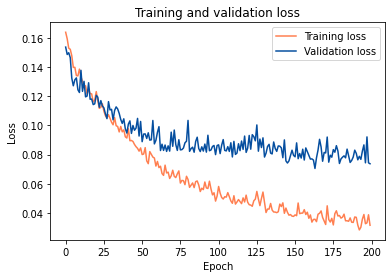

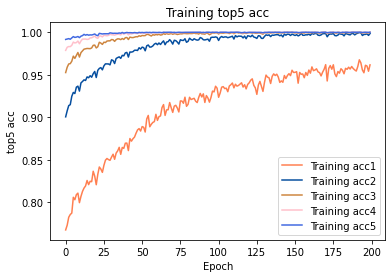

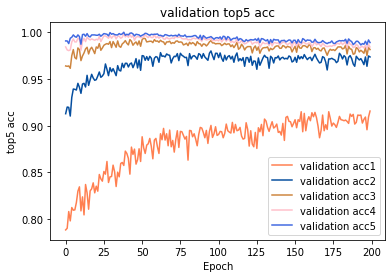

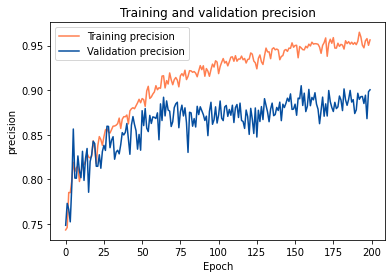

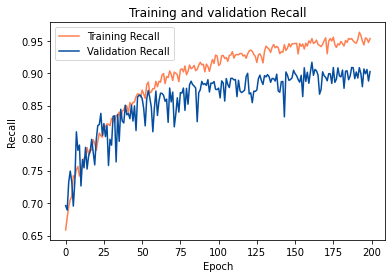

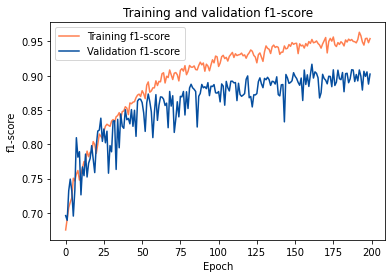

1636119300.278559


In [680]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)

### 5层CNN 

1636530161.836032
-------第 1 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.4090 	 valid Loss: 0.2831
train acc1: 0.5476 	 valid acc1: 0.6407
train acc2: 0.6438 	 valid acc2: 0.7871
train acc3: 0.7044 	 valid acc3: 0.8414
train acc4: 0.7545 	 valid acc4: 0.8804
train acc5: 0.7975 	 valid acc5: 0.9082
train precision: 0.3080 	 valid precision: 0.4089
train recall: 0.1877 	 valid recall: 0.3803
train f1-score: 0.2075 	 valid f1-score: 0.3439
-------第 2 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2654 	 valid Loss: 0.2425
train acc1: 0.6698 	 valid acc1: 0.6957
train acc2: 0.7930 	 valid acc2: 0.8271
train acc3: 0.8623 	 valid acc3: 0.8871
train acc4: 0.9079 	 valid acc4: 0.9232
train acc5: 0.9387 	 valid acc5: 0.9518
train precision: 0.4618 	 valid precision: 0.4745
train recall: 0.4442 	 valid recall: 0.4901
train f1-score: 0.4346 	 valid f1-score: 0.4752
-------第 3 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2420 	 valid Loss: 0.2301
train acc1: 0.6846 	 valid acc1: 0.7011
train acc2: 0.8155 	 valid acc2: 0.8293
train acc3: 0.8868 	 valid acc3: 0.9039
train acc4: 0.9268 	 valid acc4: 0.9421
train acc5: 0.9588 	 valid acc5: 0.9664
train precision: 0.5590 	 valid precision: 0.4883
train recall: 0.4797 	 valid recall: 0.4967
train f1-score: 0.4713 	 valid f1-score: 0.4878
-------第 4 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2327 	 valid Loss: 0.2292
train acc1: 0.6889 	 valid acc1: 0.7061
train acc2: 0.8185 	 valid acc2: 0.8268
train acc3: 0.8902 	 valid acc3: 0.8986
train acc4: 0.9317 	 valid acc4: 0.9414
train acc5: 0.9615 	 valid acc5: 0.9593
train precision: 0.5301 	 valid precision: 0.5259
train recall: 0.4952 	 valid recall: 0.5249
train f1-score: 0.4936 	 valid f1-score: 0.5176
-------第 5 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2213 	 valid Loss: 0.2146
train acc1: 0.7004 	 valid acc1: 0.7046
train acc2: 0.8325 	 valid acc2: 0.8482
train acc3: 0.9040 	 valid acc3: 0.9114
train acc4: 0.9396 	 valid acc4: 0.9464
train acc5: 0.9674 	 valid acc5: 0.9675
train precision: 0.6039 	 valid precision: 0.5592
train recall: 0.5198 	 valid recall: 0.5309
train f1-score: 0.5192 	 valid f1-score: 0.5178
-------第 6 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2137 	 valid Loss: 0.2121
train acc1: 0.7075 	 valid acc1: 0.7111
train acc2: 0.8418 	 valid acc2: 0.8529
train acc3: 0.9114 	 valid acc3: 0.9086
train acc4: 0.9506 	 valid acc4: 0.9550
train acc5: 0.9738 	 valid acc5: 0.9746
train precision: 0.6055 	 valid precision: 0.5989
train recall: 0.5351 	 valid recall: 0.5488
train f1-score: 0.5330 	 valid f1-score: 0.5382
-------第 7 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.2059 	 valid Loss: 0.1950
train acc1: 0.7107 	 valid acc1: 0.7257
train acc2: 0.8575 	 valid acc2: 0.8707
train acc3: 0.9246 	 valid acc3: 0.9243
train acc4: 0.9577 	 valid acc4: 0.9611
train acc5: 0.9779 	 valid acc5: 0.9779
train precision: 0.6040 	 valid precision: 0.6125
train recall: 0.5404 	 valid recall: 0.5739
train f1-score: 0.5390 	 valid f1-score: 0.5568
-------第 8 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1928 	 valid Loss: 0.1795
train acc1: 0.7238 	 valid acc1: 0.7561
train acc2: 0.8739 	 valid acc2: 0.8864
train acc3: 0.9326 	 valid acc3: 0.9443
train acc4: 0.9671 	 valid acc4: 0.9714
train acc5: 0.9826 	 valid acc5: 0.9843
train precision: 0.6465 	 valid precision: 0.6532
train recall: 0.5671 	 valid recall: 0.6190
train f1-score: 0.5706 	 valid f1-score: 0.6176
-------第 9 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1884 	 valid Loss: 0.2018
train acc1: 0.7337 	 valid acc1: 0.7321
train acc2: 0.8768 	 valid acc2: 0.8532
train acc3: 0.9371 	 valid acc3: 0.9132
train acc4: 0.9670 	 valid acc4: 0.9443
train acc5: 0.9848 	 valid acc5: 0.9657
train precision: 0.6511 	 valid precision: 0.6374
train recall: 0.5924 	 valid recall: 0.5820
train f1-score: 0.5951 	 valid f1-score: 0.5773
-------第 10 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1816 	 valid Loss: 0.1815
train acc1: 0.7471 	 valid acc1: 0.7554
train acc2: 0.8814 	 valid acc2: 0.8732
train acc3: 0.9426 	 valid acc3: 0.9393
train acc4: 0.9719 	 valid acc4: 0.9679
train acc5: 0.9862 	 valid acc5: 0.9850
train precision: 0.7011 	 valid precision: 0.7425
train recall: 0.6174 	 valid recall: 0.6537
train f1-score: 0.6249 	 valid f1-score: 0.6419
-------第 11 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1798 	 valid Loss: 0.1670
train acc1: 0.7513 	 valid acc1: 0.7679
train acc2: 0.8839 	 valid acc2: 0.9018
train acc3: 0.9435 	 valid acc3: 0.9511
train acc4: 0.9731 	 valid acc4: 0.9764
train acc5: 0.9890 	 valid acc5: 0.9879
train precision: 0.7223 	 valid precision: 0.7459
train recall: 0.6298 	 valid recall: 0.6449
train f1-score: 0.6346 	 valid f1-score: 0.6381
-------第 12 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1704 	 valid Loss: 0.1707
train acc1: 0.7633 	 valid acc1: 0.7625
train acc2: 0.8981 	 valid acc2: 0.8889
train acc3: 0.9507 	 valid acc3: 0.9471
train acc4: 0.9781 	 valid acc4: 0.9746
train acc5: 0.9906 	 valid acc5: 0.9864
train precision: 0.7393 	 valid precision: 0.7161
train recall: 0.6546 	 valid recall: 0.6509
train f1-score: 0.6605 	 valid f1-score: 0.6280
-------第 13 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1685 	 valid Loss: 0.1712
train acc1: 0.7592 	 valid acc1: 0.7754
train acc2: 0.9017 	 valid acc2: 0.8821
train acc3: 0.9513 	 valid acc3: 0.9479
train acc4: 0.9794 	 valid acc4: 0.9761
train acc5: 0.9904 	 valid acc5: 0.9879
train precision: 0.7205 	 valid precision: 0.7543
train recall: 0.6533 	 valid recall: 0.6714
train f1-score: 0.6554 	 valid f1-score: 0.6631
-------第 14 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1675 	 valid Loss: 0.1656
train acc1: 0.7629 	 valid acc1: 0.7579
train acc2: 0.8933 	 valid acc2: 0.9089
train acc3: 0.9504 	 valid acc3: 0.9596
train acc4: 0.9795 	 valid acc4: 0.9761
train acc5: 0.9905 	 valid acc5: 0.9846
train precision: 0.7389 	 valid precision: 0.7433
train recall: 0.6550 	 valid recall: 0.6153
train f1-score: 0.6611 	 valid f1-score: 0.6238
-------第 15 轮训练开始-------
train Loss: 0.1597 	 valid Loss: 0.1668
train acc1: 0.7730 	 valid acc1: 0.7739
train acc2: 0.9105 	 valid acc2: 0.9050
train acc3: 0.9595 	 valid acc3: 0.9539
train acc4: 0.9837 	 valid acc4: 0.9761
train acc5: 0.9917 	 valid acc5: 0.9861
train precision: 0.8146 	 valid precision: 0.8007
train recall: 0.6708 	 valid recall: 0.6664
train f1-score: 0.6785 	 valid f1-score: 0.6531
-------第 16 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1557 	 valid Loss: 0.1574
train acc1: 0.7745 	 valid acc1: 0.7854
train acc2: 0.9142 	 valid acc2: 0.9100
train acc3: 0.9656 	 valid acc3: 0.9579
train acc4: 0.9865 	 valid acc4: 0.9771
train acc5: 0.9938 	 valid acc5: 0.9882
train precision: 0.7824 	 valid precision: 0.7836
train recall: 0.6774 	 valid recall: 0.6892
train f1-score: 0.6813 	 valid f1-score: 0.6961
-------第 17 轮训练开始-------
train Loss: 0.1529 	 valid Loss: 0.1530
train acc1: 0.7773 	 valid acc1: 0.7839
train acc2: 0.9179 	 valid acc2: 0.9157
train acc3: 0.9656 	 valid acc3: 0.9600
train acc4: 0.9867 	 valid acc4: 0.9807
train acc5: 0.9932 	 valid acc5: 0.9904
train precision: 0.8140 	 valid precision: 0.8647
train recall: 0.6830 	 valid recall: 0.6844
train f1-score: 0.6923 	 valid f1-score: 0.6841
-------第 18 轮训练开始-------
train Loss: 0.1552 	 valid Loss: 0.1539
train acc1: 0.7745 	 valid acc1: 0.7864
train acc2: 0.9137 	 valid acc2: 0.9193
train acc3: 0.9620 	 valid acc3: 0.9596
train acc4: 0.9849 	 valid

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1466 	 valid Loss: 0.1406
train acc1: 0.7892 	 valid acc1: 0.7921
train acc2: 0.9277 	 valid acc2: 0.9318
train acc3: 0.9720 	 valid acc3: 0.9718
train acc4: 0.9894 	 valid acc4: 0.9896
train acc5: 0.9956 	 valid acc5: 0.9929
train precision: 0.8122 	 valid precision: 0.7790
train recall: 0.7062 	 valid recall: 0.6937
train f1-score: 0.7170 	 valid f1-score: 0.7097
-------第 22 轮训练开始-------


/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



train Loss: 0.1463 	 valid Loss: 0.1412
train acc1: 0.7924 	 valid acc1: 0.8018
train acc2: 0.9232 	 valid acc2: 0.9286
train acc3: 0.9680 	 valid acc3: 0.9707
train acc4: 0.9886 	 valid acc4: 0.9850
train acc5: 0.9951 	 valid acc5: 0.9921
train precision: 0.8012 	 valid precision: 0.7788
train recall: 0.7074 	 valid recall: 0.7207
train f1-score: 0.7203 	 valid f1-score: 0.7259
-------第 23 轮训练开始-------
train Loss: 0.1385 	 valid Loss: 0.1346
train acc1: 0.8000 	 valid acc1: 0.8111
train acc2: 0.9369 	 valid acc2: 0.9368
train acc3: 0.9750 	 valid acc3: 0.9721
train acc4: 0.9910 	 valid acc4: 0.9879
train acc5: 0.9961 	 valid acc5: 0.9943
train precision: 0.8097 	 valid precision: 0.8287
train recall: 0.7338 	 valid recall: 0.7273
train f1-score: 0.7450 	 valid f1-score: 0.7355
-------第 24 轮训练开始-------
train Loss: 0.1378 	 valid Loss: 0.1417
train acc1: 0.8025 	 valid acc1: 0.8050
train acc2: 0.9346 	 valid acc2: 0.9279
train acc3: 0.9755 	 valid acc3: 0.9718
train acc4: 0.9917 	 valid

train Loss: 0.1119 	 valid Loss: 0.1222
train acc1: 0.8410 	 valid acc1: 0.8336
train acc2: 0.9589 	 valid acc2: 0.9525
train acc3: 0.9885 	 valid acc3: 0.9807
train acc4: 0.9963 	 valid acc4: 0.9918
train acc5: 0.9985 	 valid acc5: 0.9939
train precision: 0.8438 	 valid precision: 0.8506
train recall: 0.8014 	 valid recall: 0.7680
train f1-score: 0.8083 	 valid f1-score: 0.7813
-------第 44 轮训练开始-------
train Loss: 0.1129 	 valid Loss: 0.1126
train acc1: 0.8398 	 valid acc1: 0.8464
train acc2: 0.9630 	 valid acc2: 0.9589
train acc3: 0.9886 	 valid acc3: 0.9846
train acc4: 0.9958 	 valid acc4: 0.9925
train acc5: 0.9982 	 valid acc5: 0.9961
train precision: 0.8434 	 valid precision: 0.8499
train recall: 0.7998 	 valid recall: 0.7949
train f1-score: 0.8068 	 valid f1-score: 0.8085
-------第 45 轮训练开始-------
train Loss: 0.1068 	 valid Loss: 0.1175
train acc1: 0.8521 	 valid acc1: 0.8418
train acc2: 0.9631 	 valid acc2: 0.9479
train acc3: 0.9900 	 valid acc3: 0.9768
train acc4: 0.9970 	 valid

train Loss: 0.0856 	 valid Loss: 0.0995
train acc1: 0.8845 	 valid acc1: 0.8650
train acc2: 0.9790 	 valid acc2: 0.9668
train acc3: 0.9951 	 valid acc3: 0.9882
train acc4: 0.9988 	 valid acc4: 0.9954
train acc5: 0.9996 	 valid acc5: 0.9968
train precision: 0.8907 	 valid precision: 0.8606
train recall: 0.8594 	 valid recall: 0.8403
train f1-score: 0.8658 	 valid f1-score: 0.8441
-------第 65 轮训练开始-------
train Loss: 0.0886 	 valid Loss: 0.1175
train acc1: 0.8800 	 valid acc1: 0.8379
train acc2: 0.9767 	 valid acc2: 0.9596
train acc3: 0.9946 	 valid acc3: 0.9843
train acc4: 0.9987 	 valid acc4: 0.9921
train acc5: 0.9998 	 valid acc5: 0.9950
train precision: 0.8865 	 valid precision: 0.8227
train recall: 0.8551 	 valid recall: 0.8183
train f1-score: 0.8624 	 valid f1-score: 0.8102
-------第 66 轮训练开始-------
train Loss: 0.0944 	 valid Loss: 0.1061
train acc1: 0.8704 	 valid acc1: 0.8579
train acc2: 0.9735 	 valid acc2: 0.9650
train acc3: 0.9930 	 valid acc3: 0.9871
train acc4: 0.9983 	 valid

train Loss: 0.0756 	 valid Loss: 0.0920
train acc1: 0.8985 	 valid acc1: 0.8829
train acc2: 0.9851 	 valid acc2: 0.9725
train acc3: 0.9971 	 valid acc3: 0.9896
train acc4: 0.9996 	 valid acc4: 0.9961
train acc5: 0.9999 	 valid acc5: 0.9964
train precision: 0.9040 	 valid precision: 0.8894
train recall: 0.8789 	 valid recall: 0.8545
train f1-score: 0.8852 	 valid f1-score: 0.8606
-------第 86 轮训练开始-------
train Loss: 0.0736 	 valid Loss: 0.0907
train acc1: 0.9029 	 valid acc1: 0.8789
train acc2: 0.9874 	 valid acc2: 0.9775
train acc3: 0.9974 	 valid acc3: 0.9932
train acc4: 0.9995 	 valid acc4: 0.9957
train acc5: 0.9996 	 valid acc5: 0.9975
train precision: 0.9121 	 valid precision: 0.8713
train recall: 0.8802 	 valid recall: 0.8576
train f1-score: 0.8886 	 valid f1-score: 0.8576
-------第 87 轮训练开始-------
train Loss: 0.0743 	 valid Loss: 0.0883
train acc1: 0.9006 	 valid acc1: 0.8825
train acc2: 0.9873 	 valid acc2: 0.9757
train acc3: 0.9974 	 valid acc3: 0.9904
train acc4: 0.9995 	 valid

train Loss: 0.0650 	 valid Loss: 0.0869
train acc1: 0.9135 	 valid acc1: 0.8907
train acc2: 0.9894 	 valid acc2: 0.9754
train acc3: 0.9983 	 valid acc3: 0.9882
train acc4: 0.9998 	 valid acc4: 0.9925
train acc5: 0.9999 	 valid acc5: 0.9950
train precision: 0.9172 	 valid precision: 0.8854
train recall: 0.8984 	 valid recall: 0.8846
train f1-score: 0.9039 	 valid f1-score: 0.8814
-------第 107 轮训练开始-------
train Loss: 0.0711 	 valid Loss: 0.0912
train acc1: 0.9026 	 valid acc1: 0.8804
train acc2: 0.9882 	 valid acc2: 0.9732
train acc3: 0.9980 	 valid acc3: 0.9886
train acc4: 0.9998 	 valid acc4: 0.9914
train acc5: 0.9999 	 valid acc5: 0.9939
train precision: 0.9051 	 valid precision: 0.8794
train recall: 0.8861 	 valid recall: 0.8583
train f1-score: 0.8904 	 valid f1-score: 0.8654
-------第 108 轮训练开始-------
train Loss: 0.0676 	 valid Loss: 0.0988
train acc1: 0.9118 	 valid acc1: 0.8757
train acc2: 0.9885 	 valid acc2: 0.9664
train acc3: 0.9976 	 valid acc3: 0.9846
train acc4: 0.9995 	 val

train Loss: 0.0593 	 valid Loss: 0.0821
train acc1: 0.9245 	 valid acc1: 0.8921
train acc2: 0.9914 	 valid acc2: 0.9804
train acc3: 0.9981 	 valid acc3: 0.9914
train acc4: 0.9993 	 valid acc4: 0.9946
train acc5: 1.0000 	 valid acc5: 0.9975
train precision: 0.9294 	 valid precision: 0.8846
train recall: 0.9125 	 valid recall: 0.8719
train f1-score: 0.9173 	 valid f1-score: 0.8735
-------第 128 轮训练开始-------
train Loss: 0.0594 	 valid Loss: 0.0844
train acc1: 0.9232 	 valid acc1: 0.8914
train acc2: 0.9920 	 valid acc2: 0.9700
train acc3: 0.9986 	 valid acc3: 0.9857
train acc4: 0.9996 	 valid acc4: 0.9904
train acc5: 0.9998 	 valid acc5: 0.9943
train precision: 0.9268 	 valid precision: 0.8916
train recall: 0.9099 	 valid recall: 0.8700
train f1-score: 0.9154 	 valid f1-score: 0.8767
-------第 129 轮训练开始-------
train Loss: 0.0595 	 valid Loss: 0.0846
train acc1: 0.9223 	 valid acc1: 0.8911
train acc2: 0.9923 	 valid acc2: 0.9768
train acc3: 0.9985 	 valid acc3: 0.9904
train acc4: 1.0000 	 val

train Loss: 0.0528 	 valid Loss: 0.0761
train acc1: 0.9319 	 valid acc1: 0.9011
train acc2: 0.9946 	 valid acc2: 0.9789
train acc3: 0.9993 	 valid acc3: 0.9889
train acc4: 0.9999 	 valid acc4: 0.9939
train acc5: 1.0000 	 valid acc5: 0.9961
train precision: 0.9359 	 valid precision: 0.8974
train recall: 0.9202 	 valid recall: 0.8940
train f1-score: 0.9252 	 valid f1-score: 0.8936
-------第 149 轮训练开始-------
train Loss: 0.0524 	 valid Loss: 0.0854
train acc1: 0.9311 	 valid acc1: 0.8932
train acc2: 0.9948 	 valid acc2: 0.9775
train acc3: 0.9994 	 valid acc3: 0.9886
train acc4: 0.9998 	 valid acc4: 0.9936
train acc5: 0.9999 	 valid acc5: 0.9946
train precision: 0.9353 	 valid precision: 0.8879
train recall: 0.9190 	 valid recall: 0.8908
train f1-score: 0.9242 	 valid f1-score: 0.8880
-------第 150 轮训练开始-------
train Loss: 0.0551 	 valid Loss: 0.0829
train acc1: 0.9263 	 valid acc1: 0.8925
train acc2: 0.9944 	 valid acc2: 0.9782
train acc3: 0.9988 	 valid acc3: 0.9886
train acc4: 0.9995 	 val

train Loss: 0.0568 	 valid Loss: 0.0899
train acc1: 0.9274 	 valid acc1: 0.8879
train acc2: 0.9930 	 valid acc2: 0.9711
train acc3: 0.9987 	 valid acc3: 0.9861
train acc4: 0.9998 	 valid acc4: 0.9911
train acc5: 0.9999 	 valid acc5: 0.9932
train precision: 0.9308 	 valid precision: 0.8918
train recall: 0.9158 	 valid recall: 0.8638
train f1-score: 0.9207 	 valid f1-score: 0.8723
-------第 170 轮训练开始-------
train Loss: 0.0509 	 valid Loss: 0.0827
train acc1: 0.9358 	 valid acc1: 0.8921
train acc2: 0.9944 	 valid acc2: 0.9746
train acc3: 0.9988 	 valid acc3: 0.9861
train acc4: 0.9998 	 valid acc4: 0.9896
train acc5: 0.9999 	 valid acc5: 0.9939
train precision: 0.9405 	 valid precision: 0.8945
train recall: 0.9269 	 valid recall: 0.8716
train f1-score: 0.9318 	 valid f1-score: 0.8807
-------第 171 轮训练开始-------
train Loss: 0.0532 	 valid Loss: 0.0880
train acc1: 0.9317 	 valid acc1: 0.8825
train acc2: 0.9942 	 valid acc2: 0.9689
train acc3: 0.9996 	 valid acc3: 0.9829
train acc4: 0.9996 	 val

train Loss: 0.0424 	 valid Loss: 0.0764
train acc1: 0.9480 	 valid acc1: 0.9086
train acc2: 0.9979 	 valid acc2: 0.9754
train acc3: 0.9998 	 valid acc3: 0.9854
train acc4: 0.9999 	 valid acc4: 0.9889
train acc5: 0.9999 	 valid acc5: 0.9907
train precision: 0.9510 	 valid precision: 0.8977
train recall: 0.9417 	 valid recall: 0.9087
train f1-score: 0.9448 	 valid f1-score: 0.9010
-------第 191 轮训练开始-------
train Loss: 0.0426 	 valid Loss: 0.0797
train acc1: 0.9473 	 valid acc1: 0.9011
train acc2: 0.9980 	 valid acc2: 0.9746
train acc3: 0.9999 	 valid acc3: 0.9839
train acc4: 1.0000 	 valid acc4: 0.9904
train acc5: 1.0000 	 valid acc5: 0.9936
train precision: 0.9463 	 valid precision: 0.8941
train recall: 0.9389 	 valid recall: 0.8999
train f1-score: 0.9413 	 valid f1-score: 0.8961
-------第 192 轮训练开始-------
train Loss: 0.0455 	 valid Loss: 0.0804
train acc1: 0.9432 	 valid acc1: 0.9039
train acc2: 0.9961 	 valid acc2: 0.9750
train acc3: 0.9998 	 valid acc3: 0.9846
train acc4: 0.9998 	 val

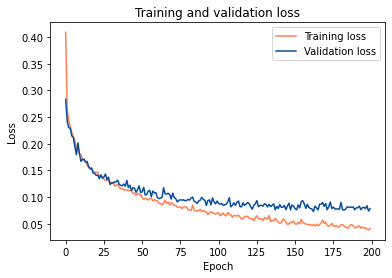

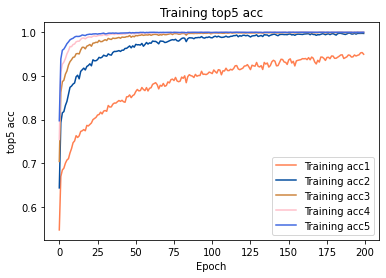

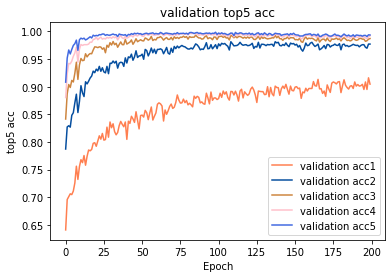

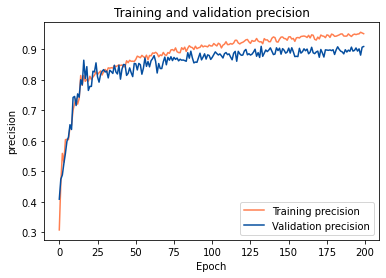

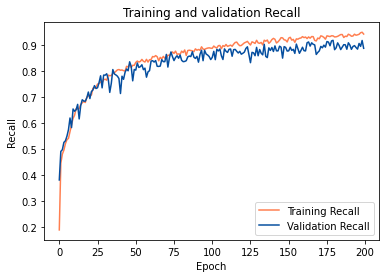

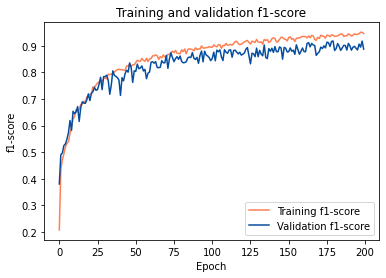

1636538683.763082


In [34]:
# training for 3 epochs
start = time.time()
print(start)
n_epochs = 200
train(capsule_net, criterion, optimizer, n_epochs=n_epochs)
end = time.time()
print(end)


## 3.3 测试模型

In [87]:
def test(capsule_net, test_loader):
    '''打印给定胶囊网络的测试统计数据。
       参数capsule_net：训练好的胶囊网络
       参数 test_loader：测试数据加载器
       return：返回最后一批测试图像数据和对应的重建
       '''
    #------计算各类别的分类准确率--------------
#     # 最开始初始化为0
    classes = ['0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9', '10', '11', '12', '13','14']
    class_correct = list(0. for i in range(16))
    
#     # 初始化为0
    class_total = list(0. for i in range(16))
    
    test_loss = 0 # loss tracking
    correct, correct1, correct2, correct3, correct4, correct5 = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    test_acc1, test_acc2, test_acc3, test_acc4, test_acc5 = 0.0, 0.0, 0.0, 0.0, 0.0
    precision, recall, f1 = 0.0, 0.0, 0.0
    test_preds = []
    test_trues = []
    
    preds = []
    trues = []
    
    count = 0
    # 模型的结构
    capsule_net.eval() # eval mode

    for batch_i, (data, target) in enumerate(test_loader):
        # target: torch.Size([20, 10])
        data = data.unsqueeze(0)
        data = data.permute(1,2,0)
        target = target.squeeze()
        target = One_hot(target)
        # 转tensor，batch_labels: torch.Size([32, 16])
        target = torch.from_numpy(target) 
        
        batch_size = data.size(0)

#         if TRAIN_ON_GPU:
#             images, target = images.cuda(), target.cuda()

        # forward pass: compute predicted outputs by passing inputs to the model
        logits, reconstruction = capsule_net(data)
        
        
        # 计算AUC，绘制AUC曲线
        preds.append(logits.cpu().detach().numpy())
        trues.append(target.cpu().detach().numpy())
        
        # 计算topk准确率，k=1-5
        _, pred = logits.topk(5, 1, largest=True, sorted=True)
        _, labels = torch.max(target.data.cpu(), 1)
        _, labels1 = torch.max(target.data.cpu(), 1)
        labels = labels.view(labels.size(0), -1).expand_as(pred)
        
#         print("topk k pred:", pred)
#         print("topk k labels:", labels)
        
        count += labels.shape[0]
        correct = pred.eq(labels).float()
        correct5 += correct[:, :5].sum()
        correct4 += correct[:, :4].sum()
        correct3 += correct[:, :3].sum()
        correct2 += correct[:, :2].sum()
        correct1 += correct[:, :1].sum()
                
        #-----------计算precision、f1-score、recall--------------
        _, output = torch.max(logits.data.cpu(), 1)
#             print("train_outputs:", train_outputs)
        _, label = torch.max(target.data.cpu(), 1)
#             print("batch_labels:", batch_labels)
        test_trues.append(label.cpu().detach().numpy())
        test_preds.append(output.cpu().detach().numpy())
            
            # calculate loss
        loss = criterion(data, target , logits, reconstruction)

        # update average test loss 
        test_loss += loss.item()
        
        correct = np.squeeze(output.eq(label.data.view_as(output)))
#         print("correct:", correct)
#         print(label.data[i])
        for i in range(batch_size):
            test_label = label.data[i]
#             print("test_label:", test_label)
            class_correct[test_label] +=  correct[i].item()
            class_total[test_label] += 1
        
    test_acc1 = correct1/count
    test_acc2 = correct2/count
    test_acc3 = correct3/count
    test_acc4 = correct4/count
    test_acc5 = correct5/count
    
    y_true = np.concatenate(test_trues)
    y_pred = np.concatenate(test_preds)
    
#     print("y_true:", y_true)
#     print("y_pred:", y_pred)
    
    ans = classification_report(y_true, y_pred,digits=5) # 小数点后保留5位有效数字
    print("测试集各标签分类情况：")
    print(ans)
    
    #---------各标签分类准确率------------
    for i in range(16):
        if class_total[i]>0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
     
    precision, recall, f1 = precision_recall_fscore_support(y_true,y_pred,average='macro')[:-1]
#         val_AUC = roc_auc_score(y_val_true, y_val_preds, multi_class='ovo')
    test_loss = test_loss/len(test_loader)
    test_loss = test_loss/100.0
    print('test Loss: {:.4f} \t'.format(test_loss))
    print('test acc1: {:.4f} \t'.format(test_acc1))
    print('test acc2: {:.4f} \t'.format(test_acc2))
    print('test acc3: {:.4f} \t'.format(test_acc3))
    print('test acc4: {:.4f} \t'.format(test_acc4))
    print('test acc5: {:.4f} \t'.format(test_acc5))
    print('test precision: {:.4f} \t test recall: {:.4f} \t test f1-score: {:.4f}'.format(precision, recall, f1))
    
    preds = np.array(preds)
    preds = preds.reshape(2800, 16)
#     print("preds:", preds)
    
    trues = np.array(trues)
    trues = trues.reshape(2800, 16)
#     print("trues:", trues)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict() 
    n_classes = 16

    #compute fpr and tpr with roc_curve from the ytest true labels to the scores
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # trues.ravel()合并为一行, (38400,)
    
    #---------------计算micro average roc_auc-----------------
    fpr["micro"], tpr["micro"], _ = roc_curve(trues.ravel(), preds.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print("micro roc_auc:", roc_auc["micro"])
    
    #---------------计算macro average roc_auc-----------------
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
      # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
      # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    print("macro roc_auc:", roc_auc["macro"])
    
    colors = cycle(['blue', 'red', 'green', 'brown', 'purple', 'pink', 'orange', 'black', 'yellow', 'cyan', 'coral', 'crimson', 'darkgoldenrod', 'lavender', 'lime', 'gold'])
    class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15']
    
    plt.figure(figsize=(12,10))
    plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]),color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc["macro"]),color='navy', linestyle=':', linewidth=4)
    
    #-------------画ROC曲线图------------------------
    for i, color, lbl in zip(range(n_classes), colors, class_labels):
        plt.plot(fpr[i], tpr[i], color = color, lw = 1.5,
        label = 'ROC Curve of class {0} (area = {1:0.3f})'.format(lbl, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for 16 Multi-Class Data')
    plt.legend(loc = 'lower right', prop = {'size': 9})
#     fullpath = save_plot_path.joinpath(save_plot_path.stem +'_roc_curve.png')
#     plt.savefig(fullpath)
    plt.show()
    

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.74898   0.91317   0.82296      1405
           1    1.00000   1.00000   1.00000        92
           2    1.00000   0.90909   0.95238        77
           3    0.96104   1.00000   0.98013        74
           4    0.98507   1.00000   0.99248        66
           5    0.85714   0.88000   0.86842        75
           6    0.98795   0.94253   0.96471        87
           7    0.93243   0.94521   0.93878        73
           8    0.90667   0.91892   0.91275        74
           9    0.98864   1.00000   0.99429        87
          10    0.88608   0.85366   0.86957        82
          11    0.59016   0.29268   0.39130       123
          12    0.50000   0.30328   0.37755       122
          13    0.38095   0.07143   0.12030       112
          14    0.39535   0.29060   0.33498       117
          15    0.44444   0.20896   0.28426       134

    accuracy                        0.77500      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



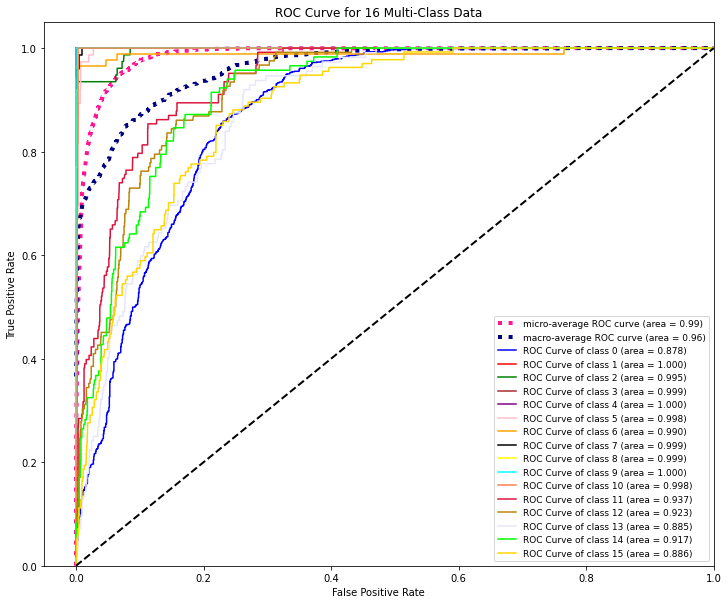

In [88]:
test(capsule_net, test_loader)

# 1层CNN(test)

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.86522   0.91574   0.88977      1353
           1    1.00000   1.00000   1.00000        79
           2    1.00000   0.91011   0.95294        89
           3    0.95745   1.00000   0.97826        90
           4    0.94872   0.96104   0.95484        77
           5    0.92857   0.89041   0.90909        73
           6    1.00000   0.96471   0.98204        85
           7    0.78161   0.76404   0.77273        89
           8    0.93333   0.97674   0.95455        86
           9    0.96842   1.00000   0.98396        92
          10    0.73611   0.67089   0.70199        79
          11    0.69128   0.81102   0.74638       127
          12    0.65306   0.82051   0.72727       117
          13    0.62963   0.14286   0.23288       119
          14    0.70213   0.79200   0.74436       125
          15    0.60526   0.38333   0.46939       120

    accuracy                        0.84571      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



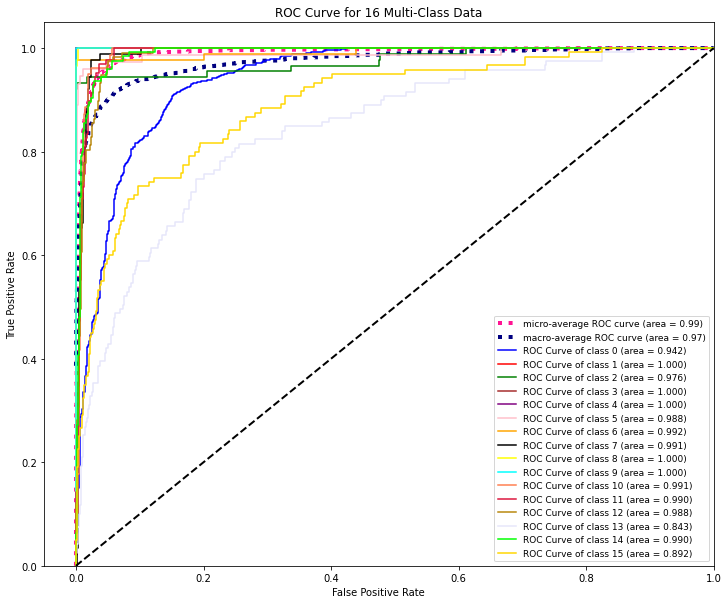

In [599]:
test(capsule_net, test_loader)

### 2层CNN

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.91970   0.91426   0.91698      1353
           1    1.00000   1.00000   1.00000        79
           2    1.00000   0.92135   0.95906        89
           3    0.97826   1.00000   0.98901        90
           4    0.97436   0.98701   0.98065        77
           5    0.90667   0.93151   0.91892        73
           6    0.98810   0.97647   0.98225        85
           7    0.90909   0.89888   0.90395        89
           8    0.95402   0.96512   0.95954        86
           9    0.97872   1.00000   0.98925        92
          10    0.83908   0.92405   0.87952        79
          11    0.80392   0.96850   0.87857       127
          12    0.80000   0.82051   0.81013       117
          13    0.52273   0.38655   0.44444       119
          14    0.81022   0.88800   0.84733       125
          15    0.63964   0.59167   0.61472       120

    accuracy                        0.88929      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



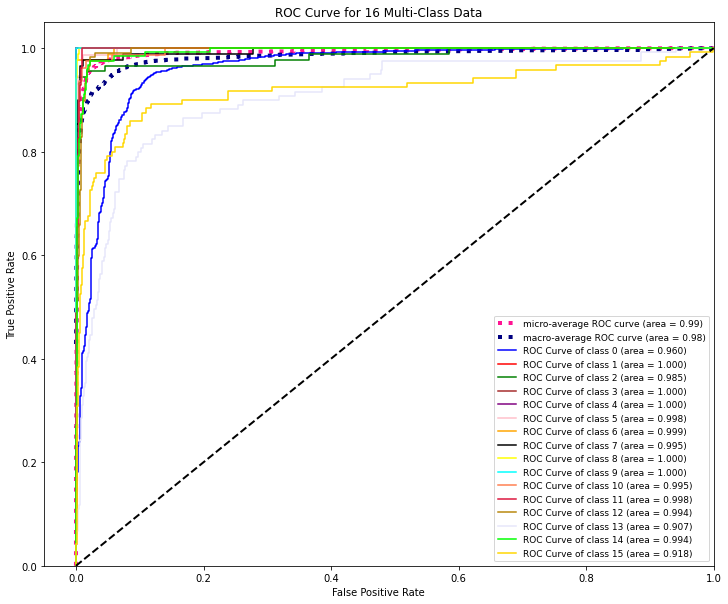

In [633]:
test(capsule_net, test_loader)

### 3层CNN 

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.91066   0.93422   0.92229      1353
           1    1.00000   1.00000   1.00000        79
           2    1.00000   0.92135   0.95906        89
           3    0.93750   1.00000   0.96774        90
           4    0.97468   1.00000   0.98718        77
           5    0.88000   0.90411   0.89189        73
           6    1.00000   0.97647   0.98810        85
           7    0.86869   0.96629   0.91489        89
           8    0.97590   0.94186   0.95858        86
           9    0.97872   1.00000   0.98925        92
          10    0.84337   0.88608   0.86420        79
          11    0.88793   0.81102   0.84774       127
          12    0.74074   0.85470   0.79365       117
          13    0.57955   0.42857   0.49275       119
          14    0.84328   0.90400   0.87259       125
          15    0.81395   0.58333   0.67961       120

    accuracy                        0.89536      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



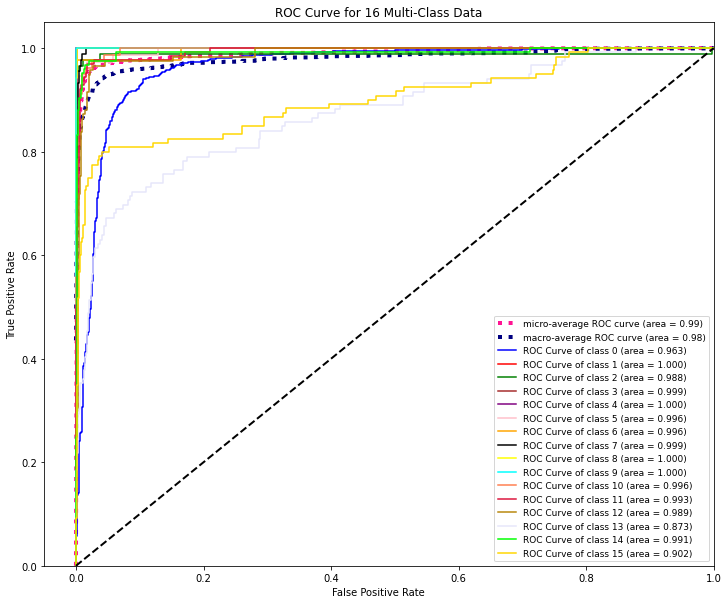

In [656]:
test(capsule_net, test_loader)

### 4层CNN 

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.92847   0.94013   0.93426      1353
           1    1.00000   1.00000   1.00000        79
           2    1.00000   0.93258   0.96512        89
           3    0.95745   1.00000   0.97826        90
           4    0.97368   0.96104   0.96732        77
           5    0.94118   0.87671   0.90780        73
           6    0.96512   0.97647   0.97076        85
           7    0.89362   0.94382   0.91803        89
           8    0.93407   0.98837   0.96045        86
           9    0.97872   1.00000   0.98925        92
          10    0.82927   0.86076   0.84472        79
          11    0.88811   1.00000   0.94074       127
          12    0.87097   0.92308   0.89627       117
          13    0.70000   0.47059   0.56281       119
          14    0.86923   0.90400   0.88627       125
          15    0.78302   0.69167   0.73451       120

    accuracy                        0.91464      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



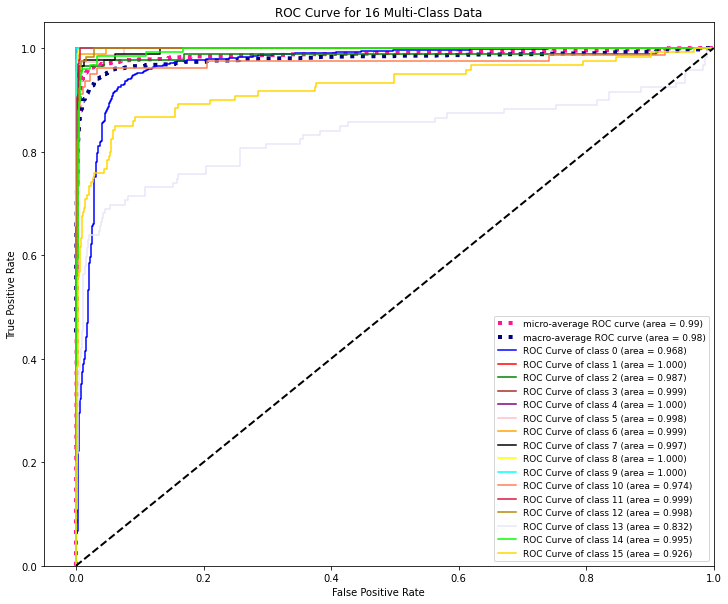

In [681]:
test(capsule_net, test_loader)

### 5层CNN

测试集各标签分类情况：
              precision    recall  f1-score   support

           0    0.90964   0.94270   0.92588      1431
           1    1.00000   1.00000   1.00000        88
           2    1.00000   0.96296   0.98113        81
           3    0.94667   1.00000   0.97260        71
           4    0.96667   1.00000   0.98305        87
           5    0.95833   0.90789   0.93243        76
           6    1.00000   0.93671   0.96732        79
           7    0.82192   0.76923   0.79470        78
           8    0.96471   0.96471   0.96471        85
           9    0.96809   1.00000   0.98378        91
          10    0.77500   0.79487   0.78481        78
          11    0.86364   0.92233   0.89202       103
          12    0.80374   0.76786   0.78539       112
          13    0.61616   0.54464   0.57820       112
          14    0.83898   0.88393   0.86087       112
          15    0.83784   0.53448   0.65263       116

    accuracy                        0.89786      2800
   macro avg  

/Users/pro/Documents/anaconda3/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:159: DeprecationWarning:

scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead



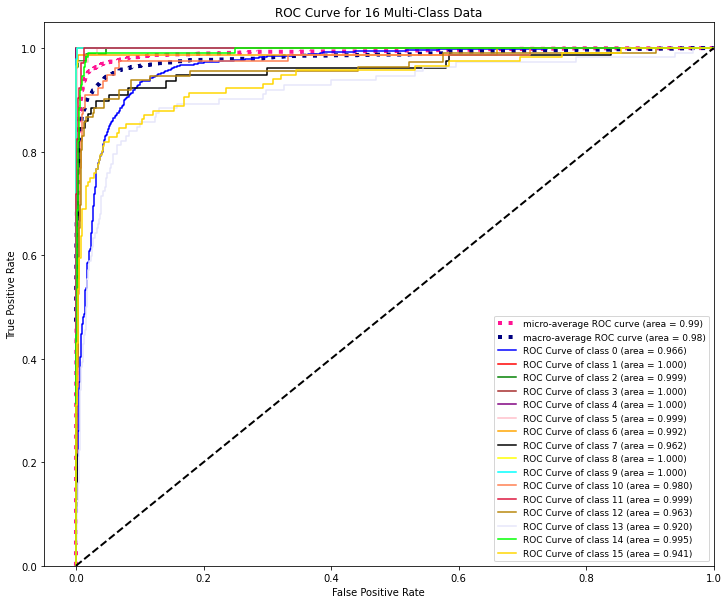

In [37]:
test(capsule_net, test_loader)